In [21]:
sdss_general_path = "/media/lrikozavr/0402A64D02A64390/Users/lrik/Work/"
sdss_filename_fits = "specObj-dr17.fits"
sdss_filename_origin = f"{sdss_general_path}sdssdr17.csv"
sdss_filename_class_sample = f"{sdss_general_path}SDSS.csv"

In [3]:
import wget
sdssdr17_url = "https://data.sdss.org/sas/dr17/sdss/spectro/redux/specObj-dr17.fits"
wget.download(sdssdr17_url, 'specObj-dr17.fits')

'C:\\Users\\lrik\\Work\\specObj-dr17.fits'

In [1]:
import pandas as pd
import numpy as np
import os

In [31]:
from astropy.io import fits
fits_file = fits.open(sdss_filename_fits)
hdr = fits_file[1].header
#['SURVEY' 'PLATEQUALITY' 'SOURCETYPE' 'PLUG_RA' 'PLUG_DEC' 'CLASS' 'SUBCLASS' 'Z' 'Z_ERR' 'ZWARNING' 'Z_NOQSO' 'Z_ERR_NOQSO' 'ZWARNING_NOQSO' 'CLASS_NOQSO' 'SUBCLASS_NOQSO']
columns = [hdr[14],hdr[19],hdr[50],hdr[80],hdr[81],hdr[82],hdr[83],hdr[84],hdr[85],hdr[103],hdr[135],hdr[136],hdr[137],hdr[138],hdr[139]]
#ax1_count = hdr[3]
ax2_count = hdr[4] #count
data = fits_file[1].data
f = open(sdss_filename_origin,"w")
f.write(','.join(columns) + "\n")
for i in range(int(ax2_count)):
	f.write(f"{str(data[i][0])},{str(data[i][5])},{str(data[i][36])},{str(data[i][66])},{str(data[i][67])},{str(data[i][68])},{str(data[i][69])},{str(data[i][70])},{str(data[i][71])},{str(data[i][89])},{str(data[i][121])},{str(data[i][122])},{str(data[i][123])},{str(data[i][124])},{str(data[i][125])}\n")
f.close()
fits_file.close()

del data, f, fits_file, i, columns, ax2_count #ax1_count

In [28]:
data = pd.read_csv(sdss_filename_origin, header=0, sep=",")

/tmp/ipykernel_53468/3876214978.py:1: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(sdss_filename_origin, header=0, sep=",")


<h1>PreClassification<h1>

Classification

In [29]:
class_name_column = "class_name"

data.loc[(data["CLASS"] == "QSO") & ((data["SUBCLASS"].str.contains("STAR", na=True)) | (data["SUBCLASS"] == "BROADLINE")), class_name_column] = "qso"
#
data.loc[((data["CLASS"] == "QSO") | (data["CLASS"] == "GALAXY")) & (data["SUBCLASS"].str.contains("AGN", na=False)), class_name_column] = "agn"
#
data.loc[(data["CLASS"] == "GALAXY") & (data["SUBCLASS"].str.contains("STARBURST", na=False)), class_name_column] = "sbg"
#
data.loc[(data["CLASS"] == "GALAXY") & (data["SUBCLASS"].str.contains("STARFORMING", na=False)), class_name_column] = "sfg"
#
data.loc[(data["CLASS"] == "GALAXY") & ((data["SUBCLASS"].str.contains("NaN",na=True) | (data["SUBCLASS"] == "BROADLINE"))), class_name_column] = "gal"
#
data.loc[data["CLASS"] == "STAR", class_name_column] = "star"


In [30]:
data = data.rename(columns={"PLUG_RA": "RA", "PLUG_DEC": "DEC", "Z": "z", "Z_ERR": "z_err"})

Redshift cut off

In [31]:
data = data[(data["ZWARNING"] == 0) & (0.1 > abs(data["z_err"]/data["z"])) & (data["z"] <= 4.0)]

In [32]:
data = data.sort_values(by=["DEC"], ascending=True)
data

,SURVEY,PLATEQUALITY,SOURCETYPE,RA,DEC,CLASS,SUBCLASS,z,z_err,ZWARNING,Z_NOQSO,Z_ERR_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,class_name
1609086,segue1,good,NONLEGACY,7.715366,-19.702714,STAR,F5,0.000248,0.000022,0,0.0,0.0,0,NaN,NaN,star
1609083,segue1,good,NONLEGACY,7.679973,-19.641483,STAR,F5,-0.000613,0.000022,0,0.0,0.0,0,NaN,NaN,star
1609048,segue1,good,NONLEGACY,8.139904,-19.639879,STAR,G2,-0.000164,0.000014,0,0.0,0.0,0,NaN,NaN,star
1609043,segue1,good,NONLEGACY,8.163993,-19.615857,STAR,A0,0.000249,0.000010,0,0.0,0.0,0,NaN,NaN,star
1609205,segue1,good,NONLEGACY,7.132664,-19.603615,STAR,F9,-0.000164,0.000009,0,0.0,0.0,0,NaN,NaN,star
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451450,segue1,good,NONLEGACY,98.019854,84.791898,STAR,F5,-0.000761,0.000009,0,0.0,0.0,0,NaN,NaN,star
1455880,segue1,good,NONLEGACY,97.666877,84.793093,STAR,F2,-0.000391,0.000023,0,0.0,0.0,0,NaN,NaN,star
1451418,segue1,good,NONLEGACY,92.883648,84.794836,STAR,F9,-0.000158,0.000009,0,0.0,0.0,0,NaN,NaN,star
1455809,segue1,good,NONLEGACY,94.478598,84.837773,STAR,F9,-0.000321,0.000017,0,0.0,0.0,0,NaN,NaN,star


In [33]:
data.to_csv(sdss_filename_class_sample, index=False)

In [34]:
del class_name_column

<h1>MAIN</h1>

In [2]:
import json

class Config():

    def __init__(self,fconfig):
        config = json.load(fconfig)
        self.name_main_sample = config['name_sample']
        self.name_sample = config['name_sample'] + config['additional_name']
        self.general_path = config['general_path']
        self.data_path = config['data_path']
        self.prediction_path = config['prediction_path']
        self.test_path = config['test_path'] ############
        self.flags = config['flags']
        self.hyperparam = config['hyperparam']
        self.features = config['features']
        self.name_class = config['name_class']
        self.name_class_column = config["name_class_column"]
        self.base = config["base"]
        self.picture = config['picture']
        self.statistic = config['statistic']
        #
        self.path_ml_data = f'{self.general_path}/ml/data'
        self.path_ml = f'{self.general_path}/ml'
        self.path_sample = f'{self.general_path}/sample'
        self.path_pic = f'{self.general_path}/ml/picture'
        self.path_stat = f'{self.general_path}/statistic'
        #
        self.path_model = f"{self.path_ml}/model/mod_{self.name_sample}"
        self.path_weight = f"{self.path_ml}/model/weight_{self.name_sample}"
        self.path_eval = f"{self.path_ml}/eval/{self.name_sample}"
        self.path_predict = f"{self.path_ml}/prediction/{self.name_sample}"
        #
        columns = []
        columns_prob = []
        for col in self.name_class:
            columns.append(f"{col}_cls")
            columns_prob.append(f"{col}_cls_prob")
        self.name_class_cls = columns
        self.name_class_prob = columns_prob

<h1>Read config<h1>

In [27]:
fconfig = open('config_agn_sdss.json')
config = Config(fconfig)
fconfig.close()
del fconfig

<h1>Create file system<h1>

In [5]:
def dir(save_path,name):
    dir_name = f"{save_path}/{name}"
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)

if not os.path.isdir(config.general_path):
    os.mkdir(config.general_path)

dir(config.general_path,'sample')
dir(config.general_path,'statistic')
dir(config.general_path,'ml')
dir(config.path_ml,'data')
dir(config.path_ml,'model')
dir(config.path_ml,'eval')
dir(config.path_ml,'prediction')
dir(config.path_ml,'picture')

<h1>Downloading&Cross-match<h1>

In [37]:
from data_download import Download
config_base = dict(name_class=config.name_class,
                   base=config.base,
                   features=config.features["data"],
                   path_sample=config.path_sample)
#print(config_base["features"])
dow = Download(config_spec=config.flags["data_downloading"],config_base=config_base)

In [38]:
dow.diff_class(config.data_path,config.name_class_column)

qso 		 942881.0
agn 		 36172.0
sbg 		 99385.0
sfg 		 287806.0
gal 		 2444919.0
star 		 443269.0


In [39]:
dow.all_class_download(config.path_stat)

del dow

cut to slice start for  /home/lrikozavr/ML_work/agn_sdss/sample/qso_origin.csv
Origin catalog columns:	 ['RA', 'DEC', 'z', 'z_err']
cut to slice finish with  9  slices
total count of lines is  942881
/home/lrikozavr/ML_work/agn_sdss/sample/qso_origin/0_catwise.csv
{'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
[1, 2, 3, 4, 0, 15, 31, 32, 17, 33, 34, 35, 36, 37, 38]

/home/lrikozavr/ML_work/agn_sdss/sample/qso_origin/1_catwise.csv
{'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPma

<h1>["PM","Plx","e_Plx","RUWE","pscol"] saga</h1>

Null value visualisation

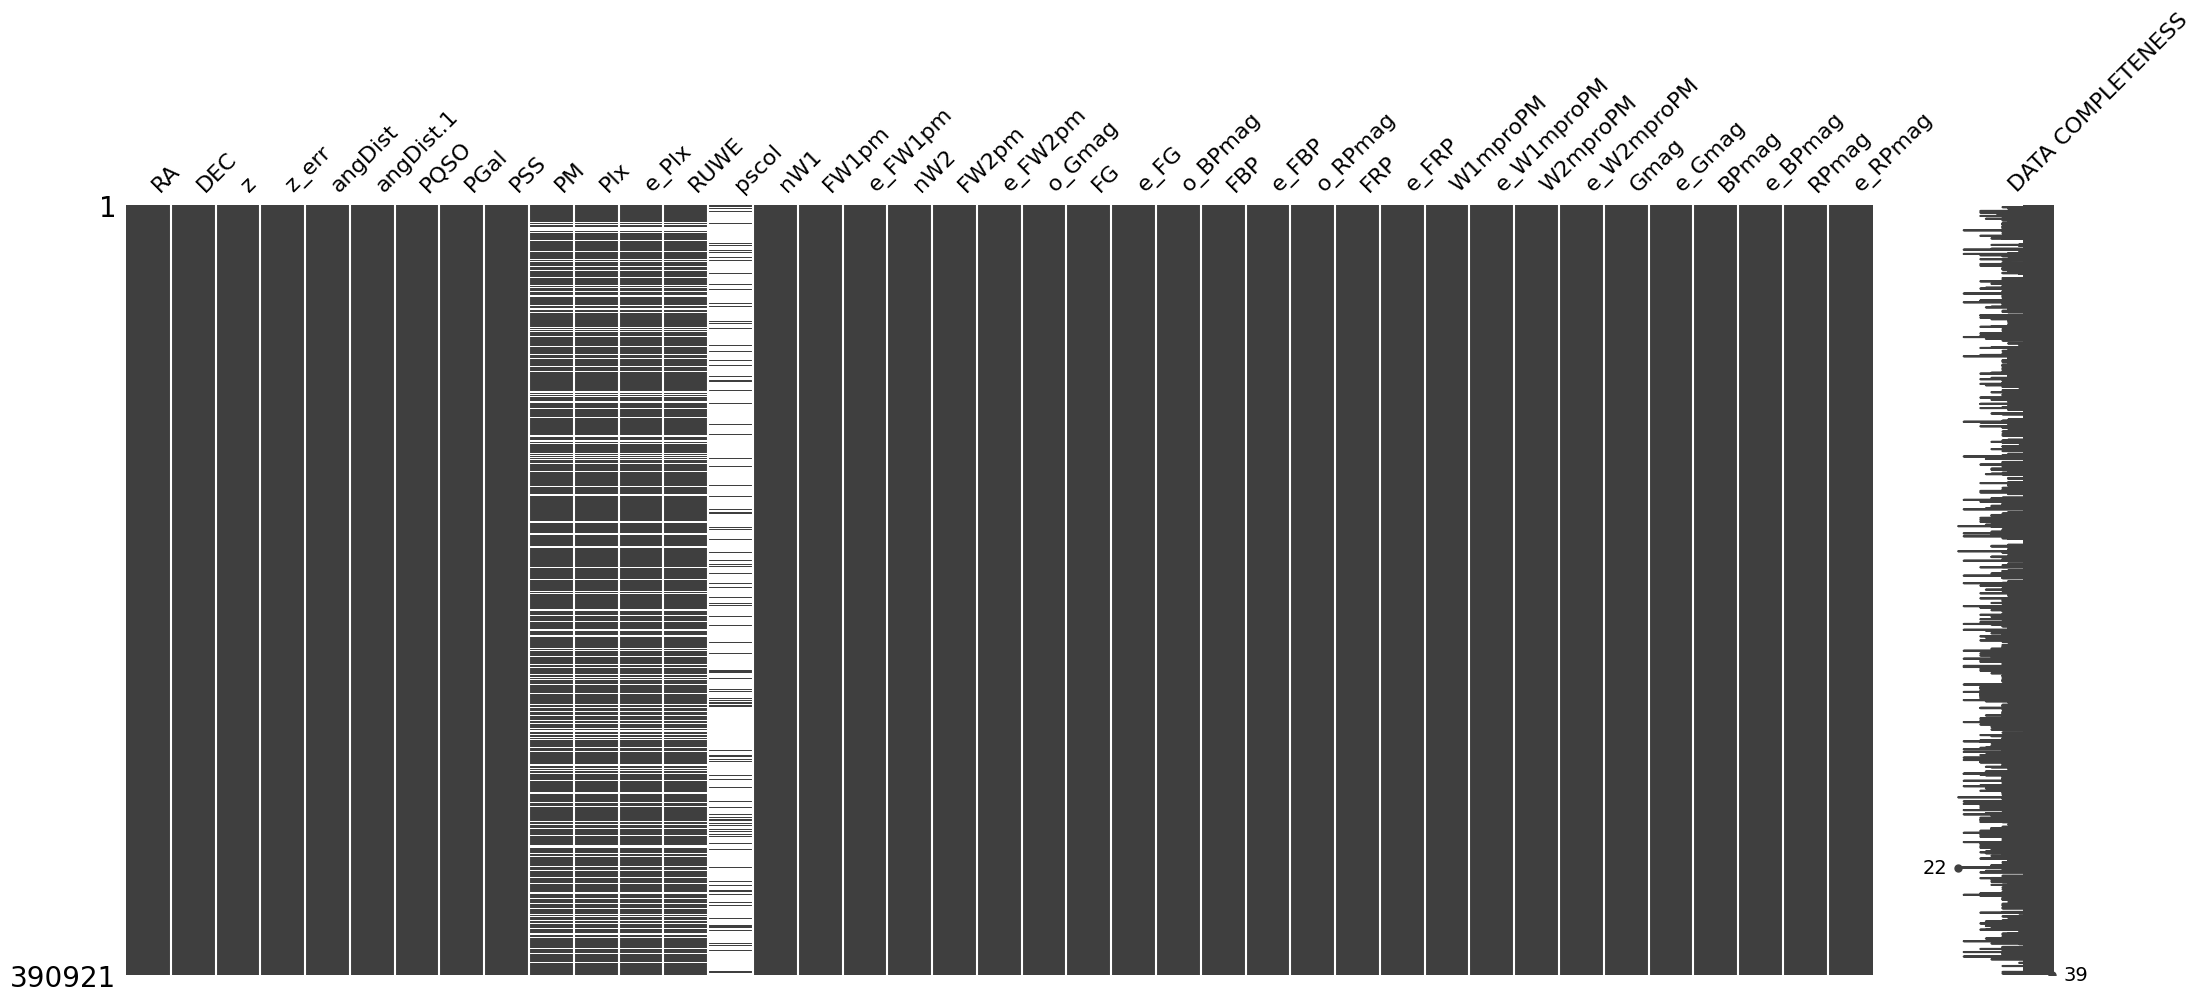

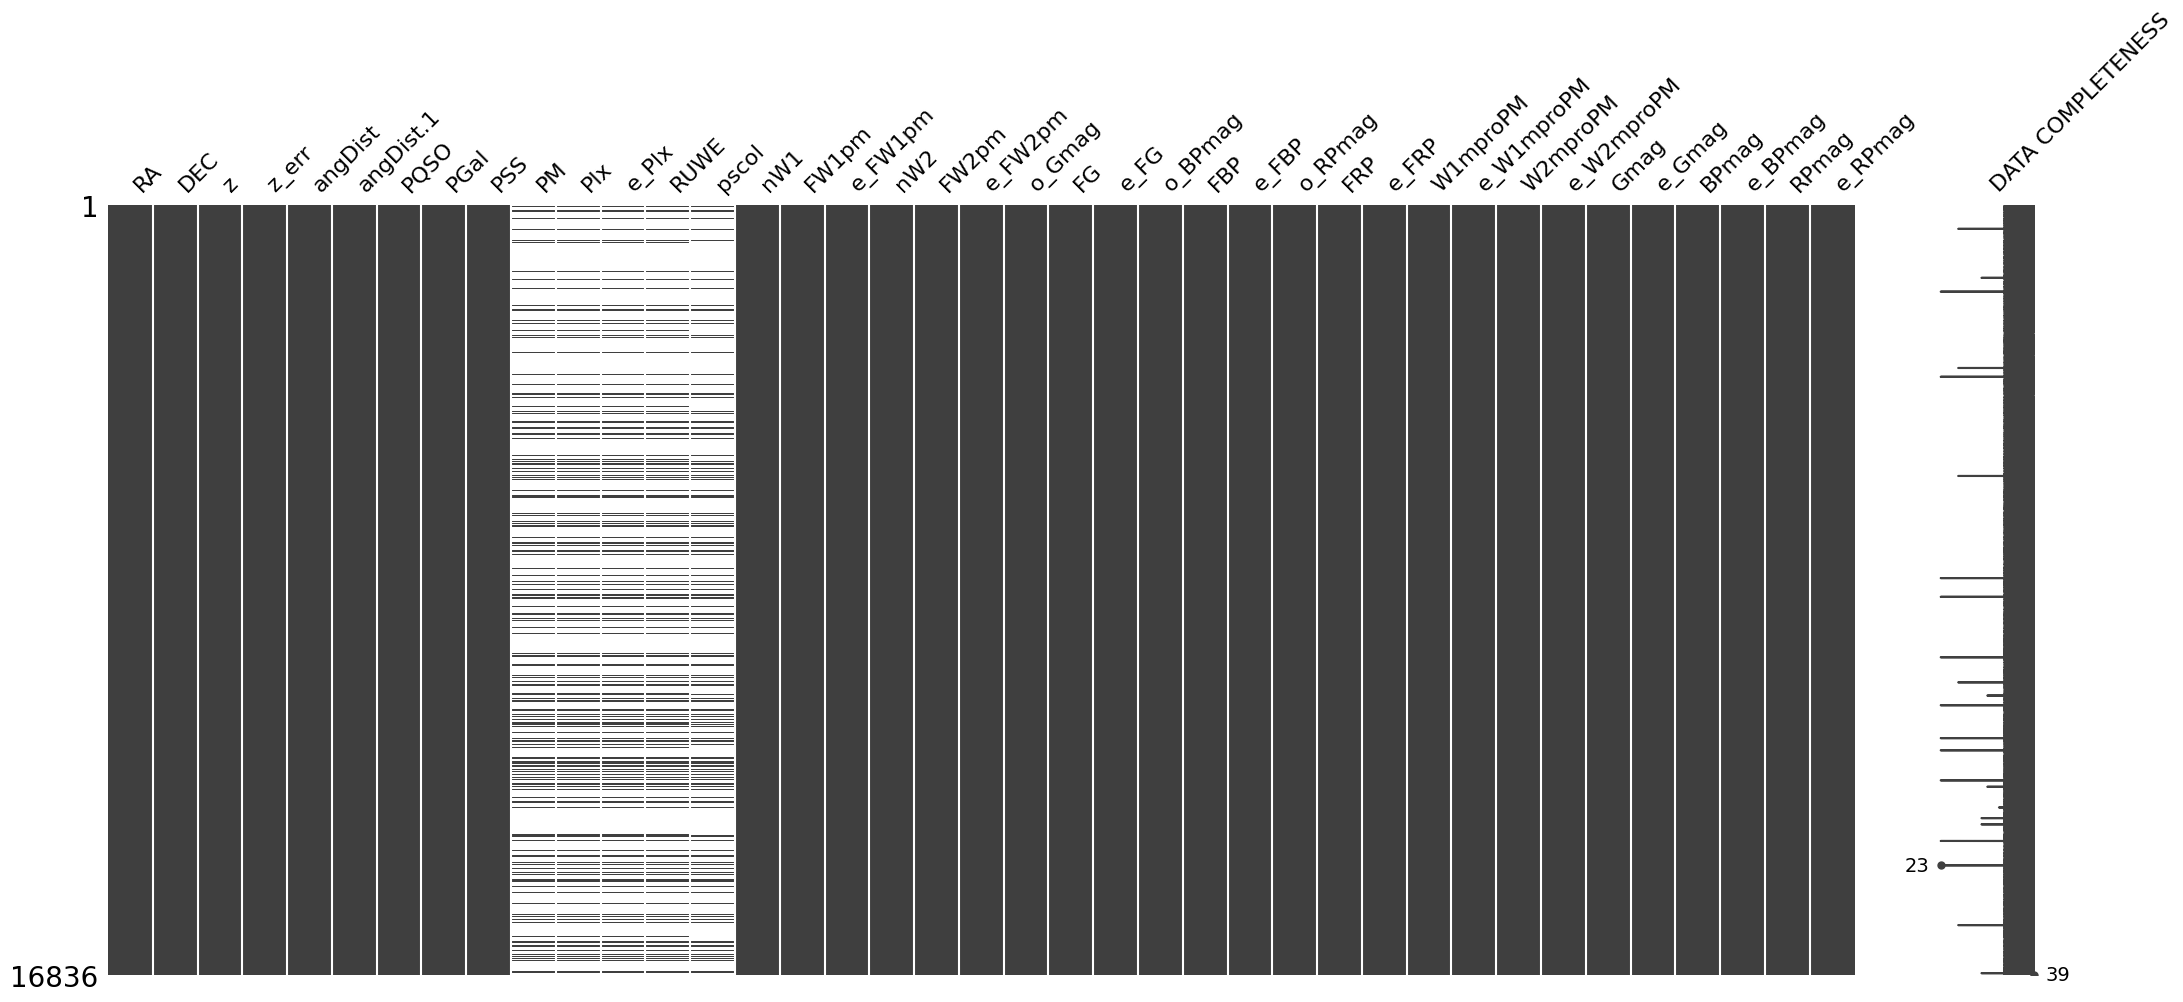

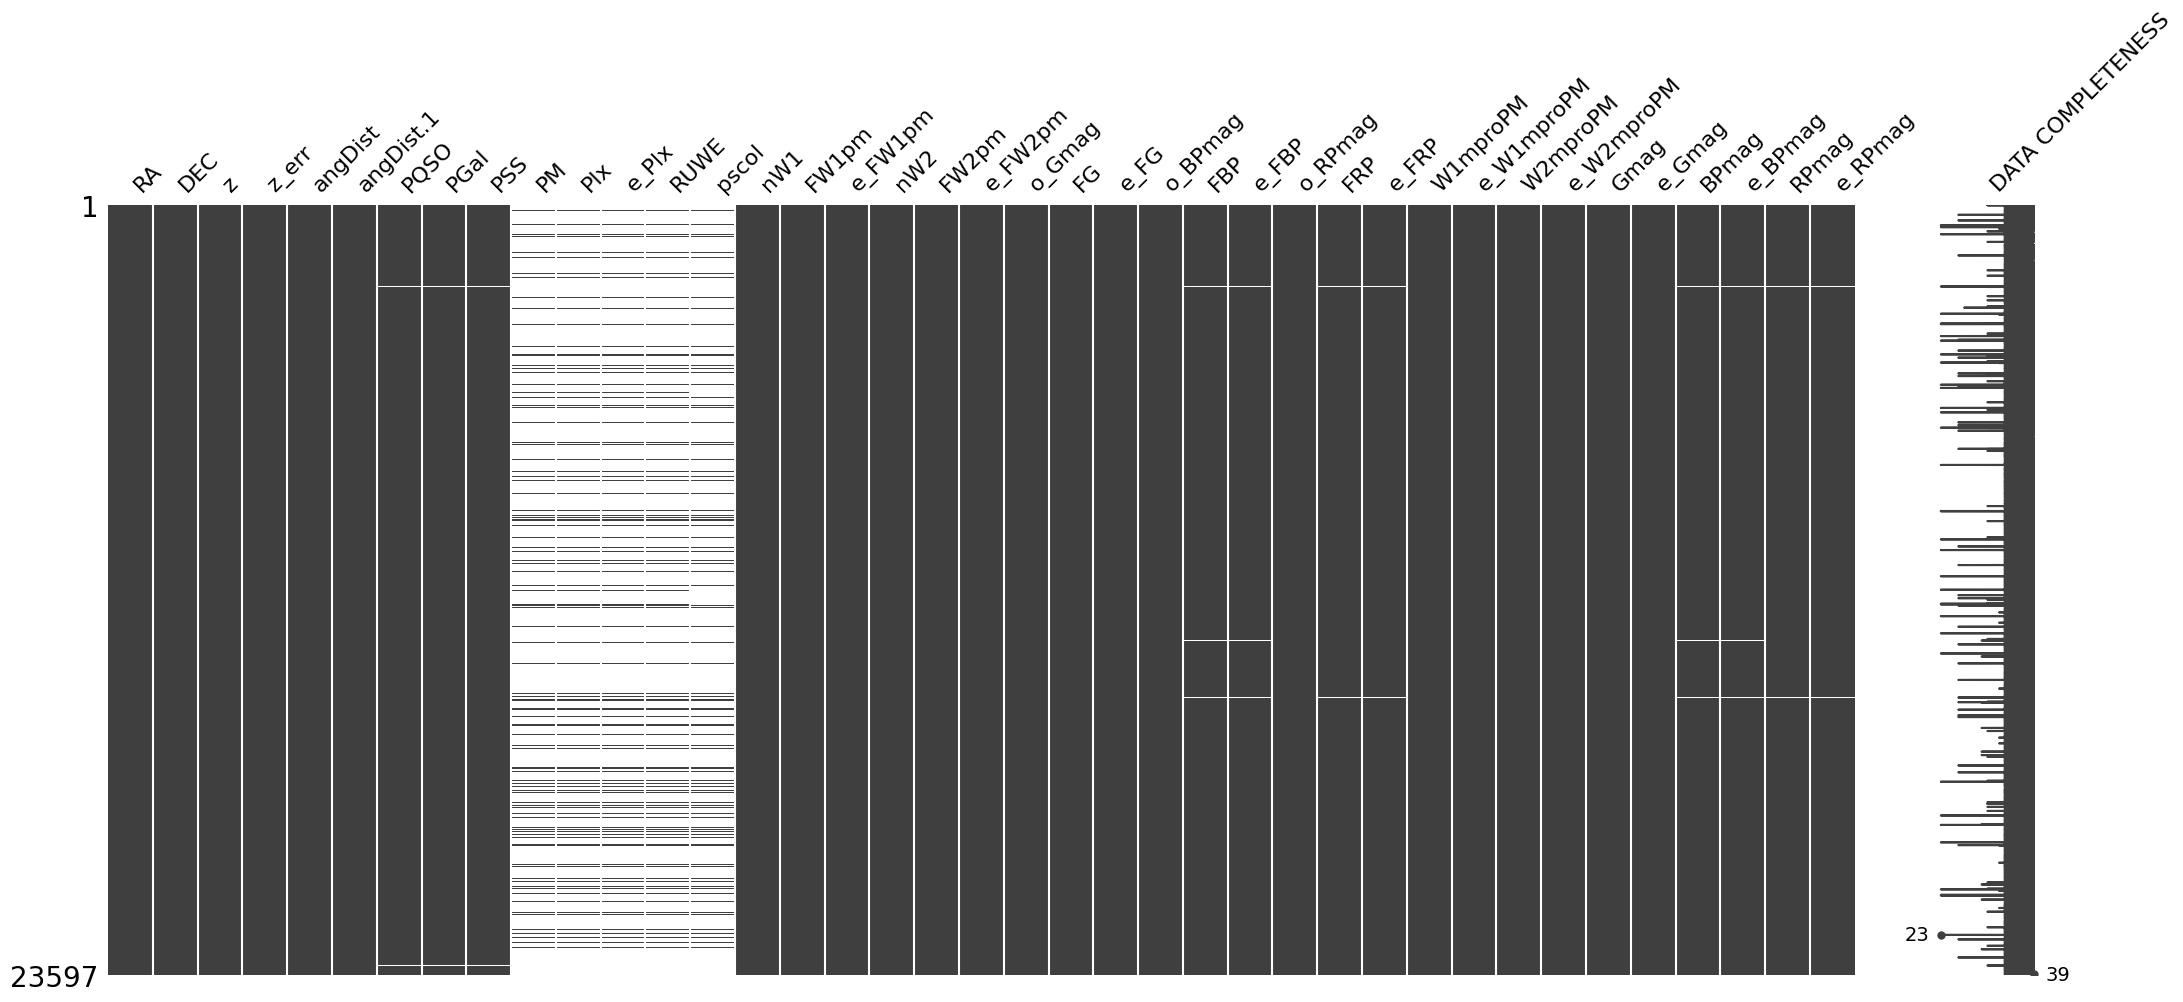

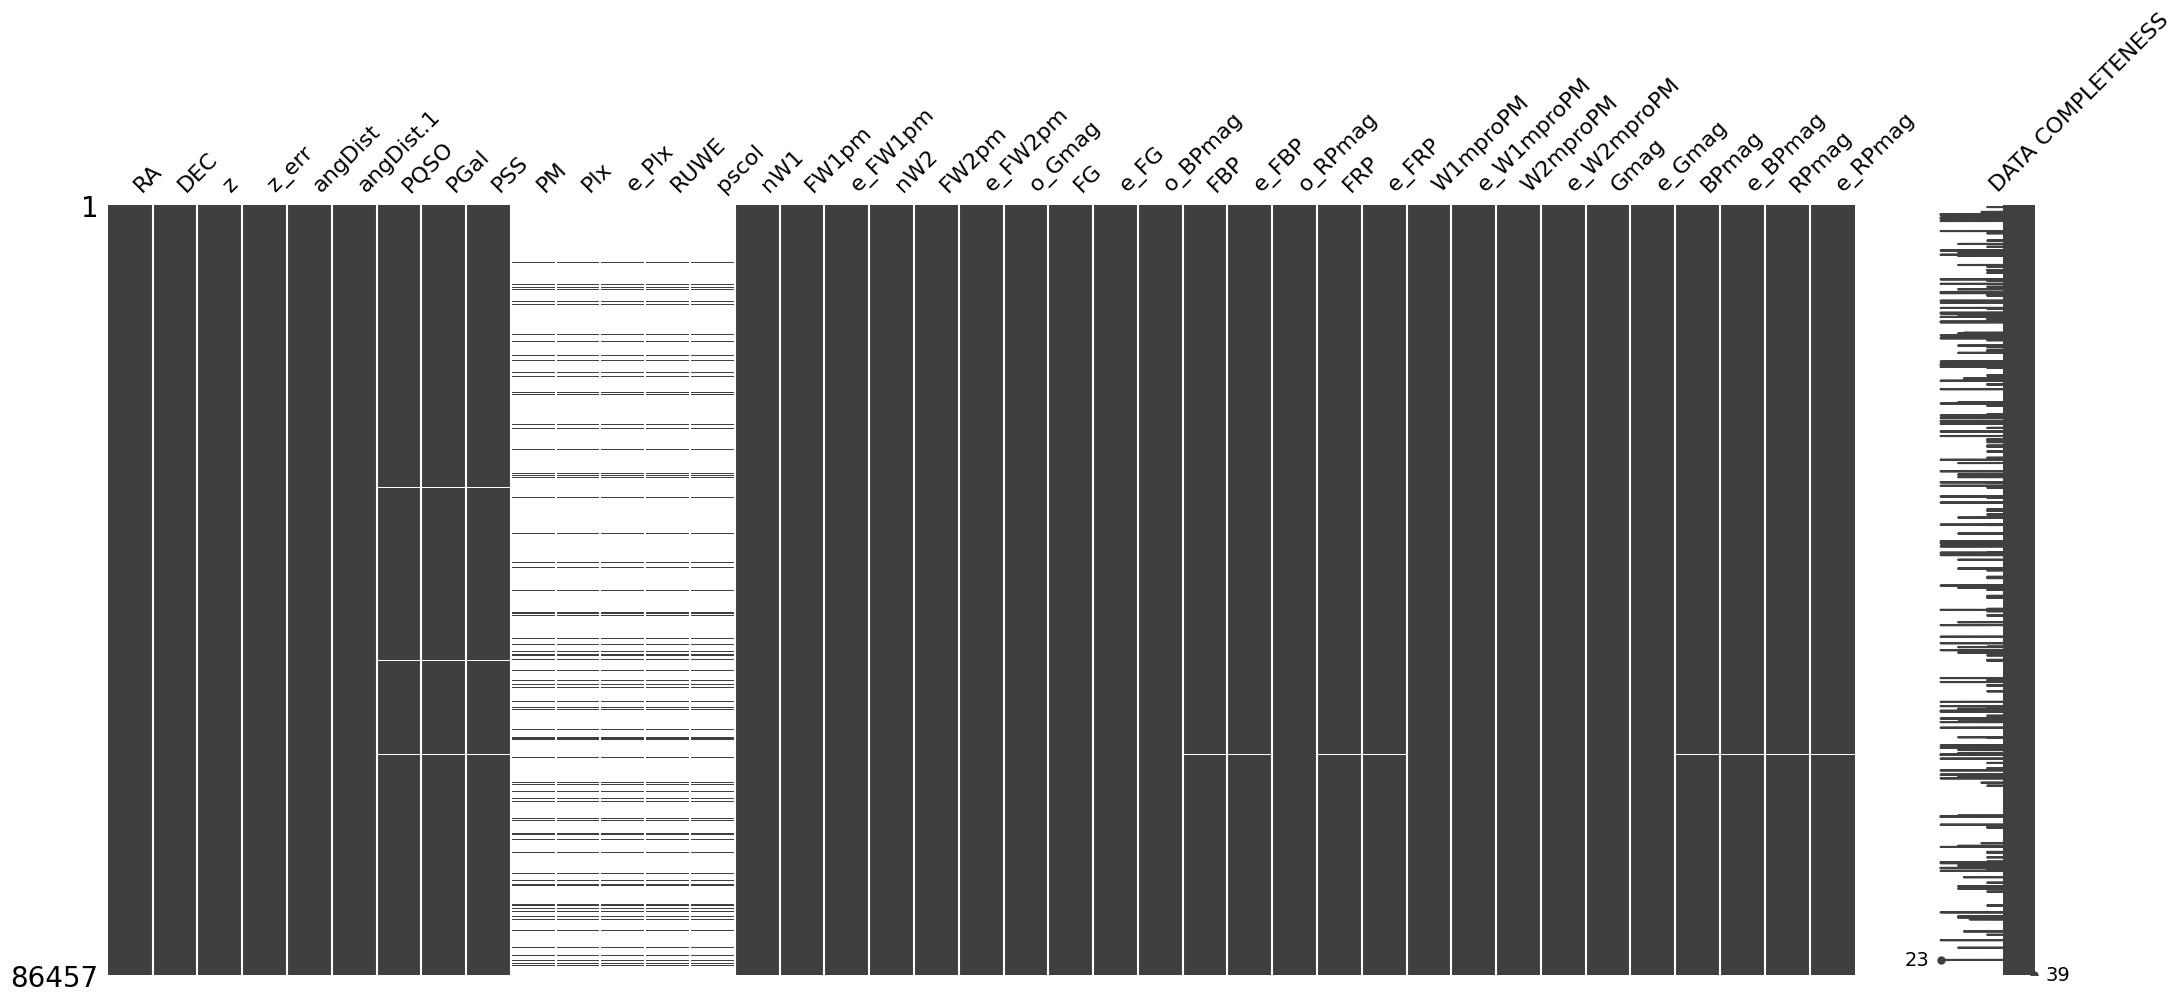

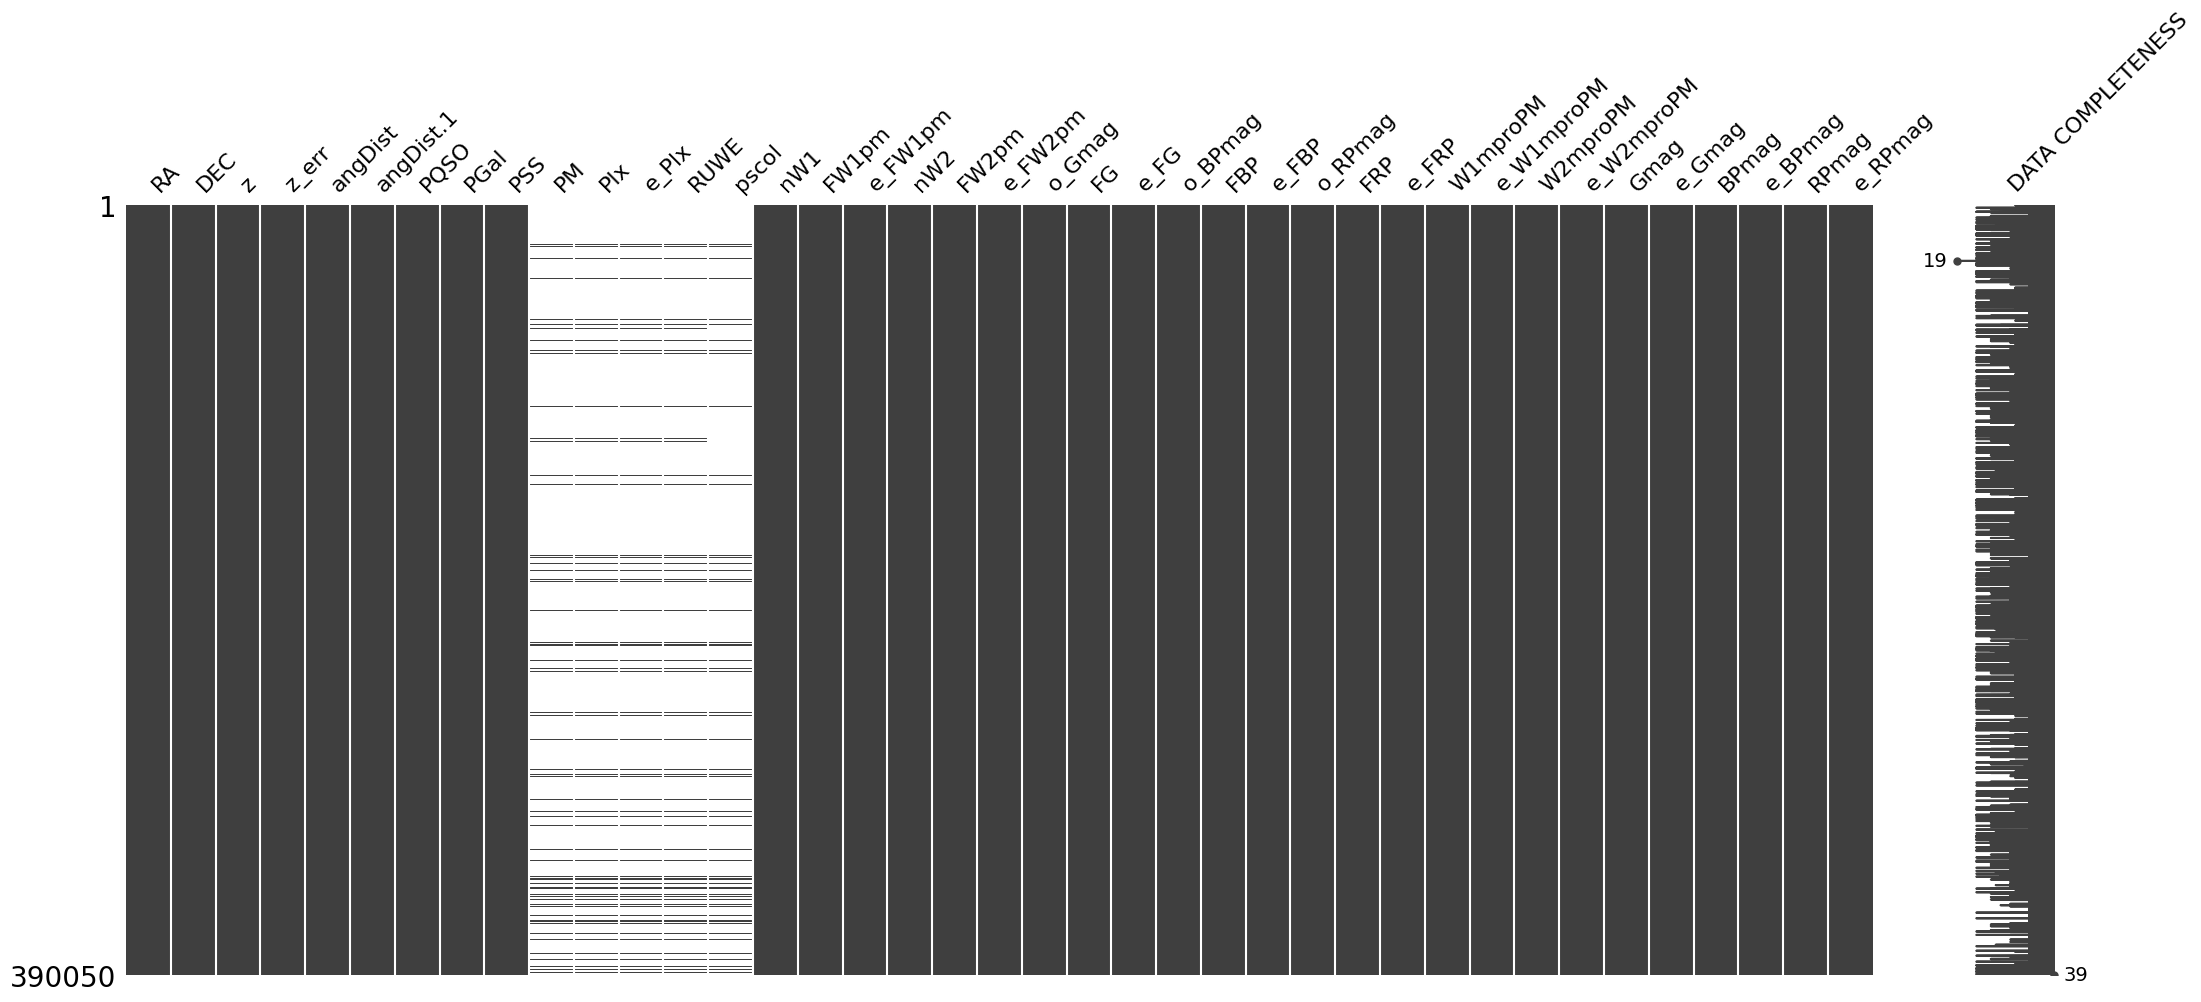

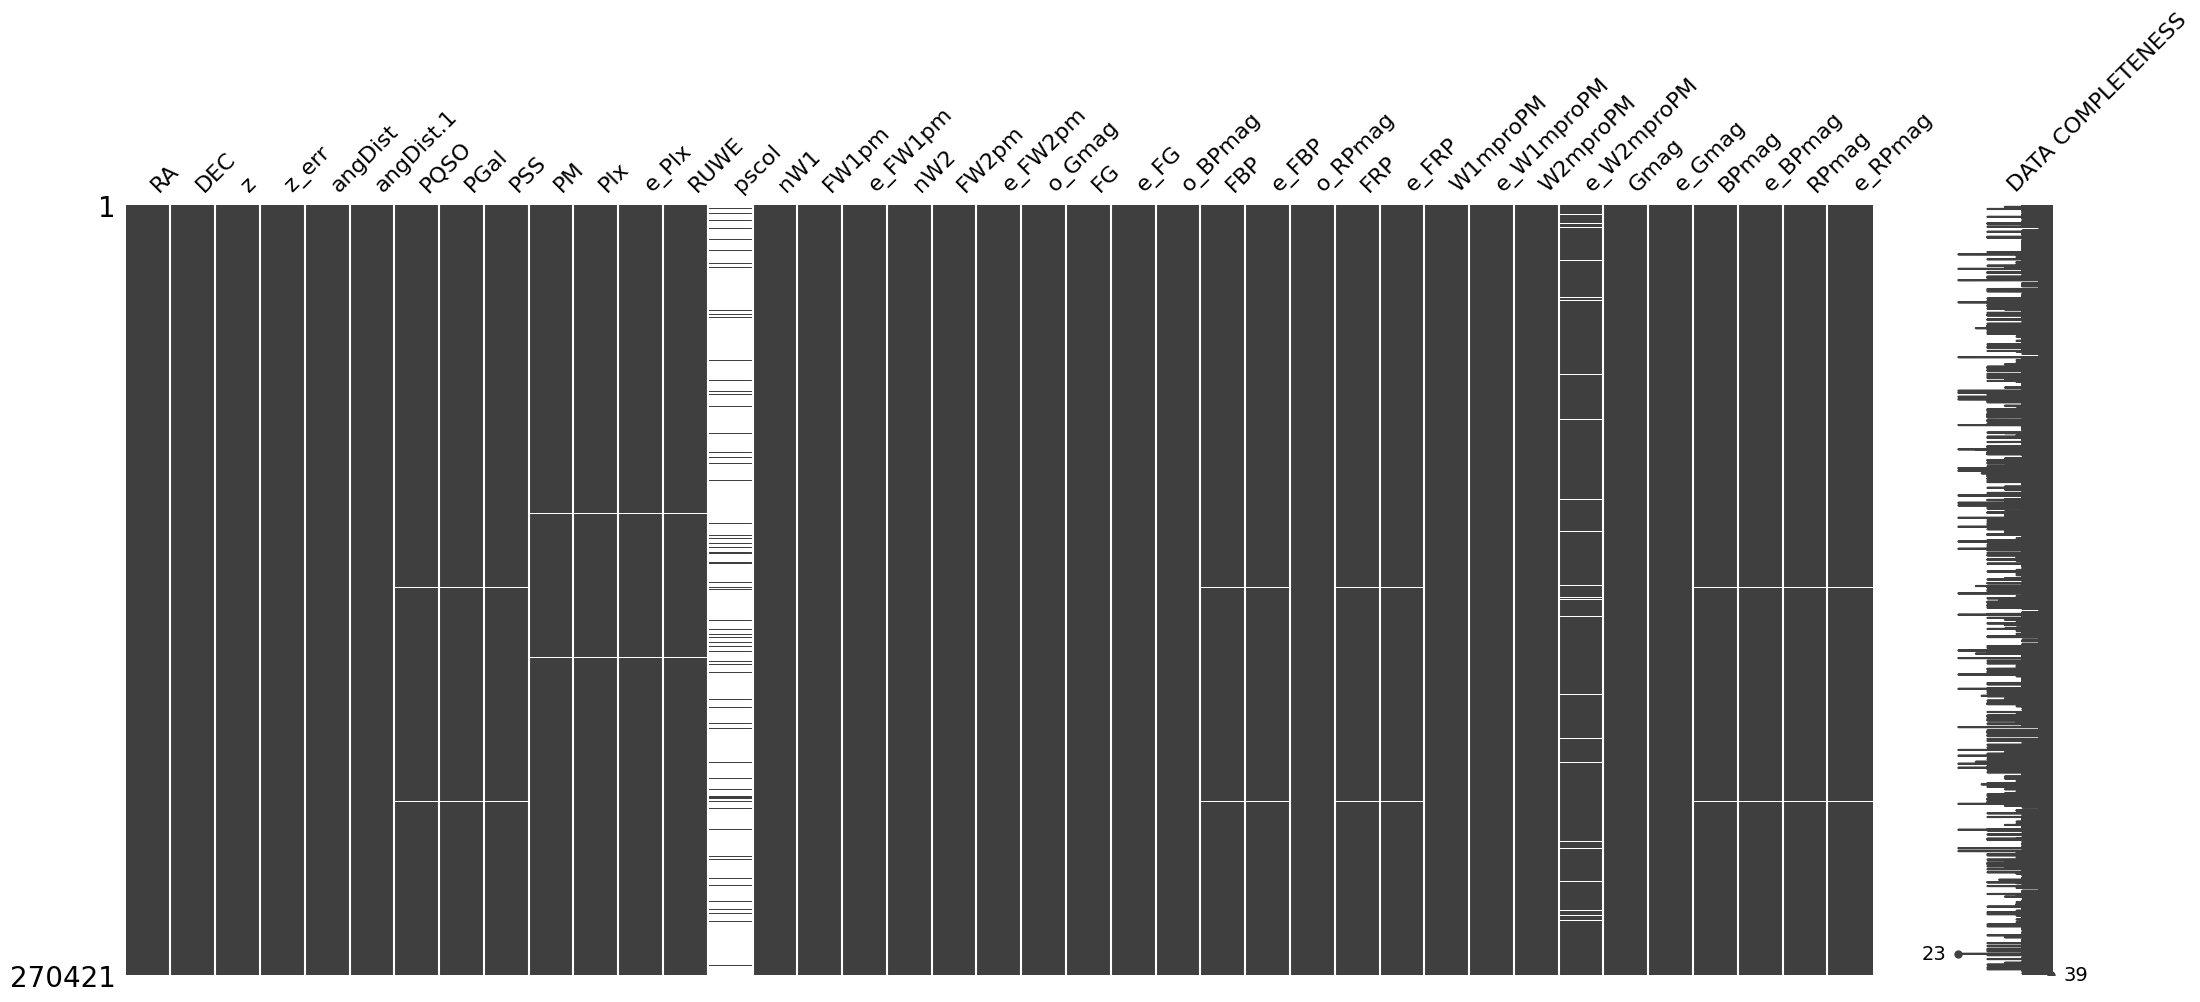

In [38]:
import missingno as msno

for name in config.name_class:
    data = pd.read_csv(f'/home/lrikozavr/ML_work/agn_sdss/sample/{name}.csv', header = 0, sep = ',')
    msno.matrix(data)

del data

Drop ["PM","Plx","e_Plx","RUWE","pscol"], because a lot of null value

In [47]:
for name in config.name_class:
    data = pd.read_csv(f'{config.path_sample}/{name}.csv', header = 0, sep = ',')
    data = data.drop(["PM","Plx","e_Plx","RUWE","pscol"], axis=1)
    data.to_csv(f'{config.path_sample}/{name}.csv', index=False)

Drop <b>NaN</b> data from sample and not zero <b>nW1&nW2</b>

In [40]:
columns = ['RA', 'DEC', 'z', 'z_err', 'angDist', 'angDist.1', 'PQSO', 'PGal', 'PSS', 
       'nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm',
       'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP', 
       'W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM',
       'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']

drop_stat = pd.DataFrame(np.zeros((len(config.name_class),len(columns))),columns=columns, index=config.name_class)

snr_stat = pd.DataFrame(np.zeros((len(config.name_class),2)),columns=["nW1","nW2"], index=config.name_class)

for name in config.name_class:
    data = pd.read_csv(f'{config.path_sample}/{name}.csv', header = 0, sep = ',')
    
    for cl in ["PQSO","PGal","PSS"]:
        data.loc[data[cl].fillna(9999.0) == 9999.0,cl] = 9999.0

    for name_ in data.columns.values:
        drop_stat.loc[name,name_] = data[data[name_].fillna("NaN") == "NaN"].shape[0]

    for nw in ["nW1","nW2"]:
        snr_stat.loc[name,nw] = data[data[nw] == 0].shape[0]
    
    data = data[(data["nW1"] > 0) & (data["nW2"] > 0)]

    data.dropna().reset_index(drop=True).to_csv(f'{config.path_sample}/{name}.csv', index=False)

del data

In [41]:
drop_stat

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,W1mproPM,e_W1mproPM,W2mproPM,e_W2mproPM,Gmag,e_Gmag,BPmag,e_BPmag,RPmag,e_RPmag
qso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,101.0,60.0,60.0,466.0,466.0,412.0,412.0
agn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,19.0,19.0,16.0,16.0
sbg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,15.0,4.0,4.0,74.0,74.0,70.0,70.0
sfg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,11.0,11.0,124.0,124.0,109.0,109.0
gal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,73.0,101.0,101.0,761.0,761.0,487.0,487.0
star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,10135.0,7.0,7.0,386.0,386.0,380.0,380.0


In [42]:
snr_stat

,nW1,nW2
qso,178.0,1027.0
agn,7.0,8.0
sbg,28.0,128.0
sfg,40.0,49.0
gal,264.0,412.0
star,250.0,25762.0


<h1>Preprocessing pipeline<h1>

In [38]:
data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
data

,index,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,...,mcd_d,mcd_g,fuzzy_err,fuzzy_dist,qso_cls,agn_cls,sfg_cls,sbg_cls,gal_cls,star_cls
0,15099,190.261630,-7.332637,0.000291,0.000012,0.075495,0.086709,0.000000,0.0,0.999896,...,1.279861,0.298665,0.636398,0.812185,0,0,0,0,0,1
1,56011,332.999540,-0.368951,-0.000258,0.000009,0.471382,0.367904,0.000000,0.0,0.999990,...,0.426337,0.216552,0.691407,0.985426,0,0,0,0,0,1
2,67802,9.163182,0.008417,-0.000087,0.000009,0.056425,0.143701,0.000000,0.0,0.999977,...,0.689709,0.250108,0.680362,0.952098,0,0,0,0,0,1
3,197881,111.922690,15.704763,0.000033,0.000008,0.032151,0.055732,0.000000,0.0,0.999985,...,0.128384,0.175315,0.703636,0.984992,0,0,0,0,0,1
4,222265,9.098554,19.105056,-0.000114,0.000023,0.099534,0.156183,0.000000,0.0,0.999998,...,1.805111,0.295350,0.627709,0.689811,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096852,141349,359.445140,15.238241,0.167220,0.000026,0.014886,0.314018,0.000000,1.0,0.000000,...,1.074232,0.314482,0.684588,0.821716,0,0,0,0,1,0
1096853,133801,174.197160,20.709335,2.516286,0.000258,0.065945,0.210775,1.000000,0.0,0.000000,...,1.812916,0.413352,0.668916,0.600548,1,0,0,0,0,0
1096854,302755,138.932190,29.565420,-0.000073,0.000006,0.099392,0.064042,0.000000,0.0,0.999983,...,0.250147,0.192309,0.716292,0.972784,0,0,0,0,0,1
1096855,122851,49.146698,5.192355,-0.000006,0.000018,0.019941,0.326439,0.000001,0.0,0.999933,...,1.048945,0.285385,0.656945,0.859157,0,0,0,0,0,1


In [5]:
data = pd.read_csv(f'/media/lrikozavr/0402A64D02A64390/Users/lrik/Work/SDSS.csv', header = 0, sep = ',')
data

/tmp/ipykernel_21694/763466918.py:1: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'/media/lrikozavr/0402A64D02A64390/Users/lrik/Work/SDSS.csv', header = 0, sep = ',')


,SURVEY,PLATEQUALITY,SOURCETYPE,RA,DEC,CLASS,SUBCLASS,z,z_err,ZWARNING,Z_NOQSO,Z_ERR_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,class_name
0,segue1,good,NONLEGACY,7.715366,-19.702714,STAR,F5,0.000248,0.000022,0,0.0,0.0,0,NaN,NaN,star
1,segue1,good,NONLEGACY,7.487451,-19.669474,STAR,F9,0.000093,0.000010,0,0.0,0.0,0,NaN,NaN,star
2,segue1,good,NONLEGACY,7.259242,-19.656897,STAR,M0,0.000038,0.000008,0,0.0,0.0,0,NaN,NaN,star
3,segue1,good,NONLEGACY,7.679973,-19.641483,STAR,F5,-0.000613,0.000022,0,0.0,0.0,0,NaN,NaN,star
4,segue1,good,NONLEGACY,8.139904,-19.639879,STAR,G2,-0.000164,0.000014,0,0.0,0.0,0,NaN,NaN,star
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854986,segue1,good,NONLEGACY,98.019854,84.791898,STAR,F5,-0.000761,0.000009,0,0.0,0.0,0,NaN,NaN,star
4854987,segue1,good,NONLEGACY,97.666877,84.793093,STAR,F2,-0.000391,0.000023,0,0.0,0.0,0,NaN,NaN,star
4854988,segue1,good,NONLEGACY,92.883648,84.794836,STAR,F9,-0.000158,0.000009,0,0.0,0.0,0,NaN,NaN,star
4854989,segue1,good,NONLEGACY,94.478598,84.837773,STAR,F9,-0.000321,0.000017,0,0.0,0.0,0,NaN,NaN,star


In [6]:
one_hot_layer = lambda x: np.array([1 if x==class_name else 0 for i, class_name in enumerate(config.name_class)])
data = pd.concat([data,pd.DataFrame(np.array(np.resize(np.concatenate(data.loc[:,"class_name"].apply(one_hot_layer).values,axis=0),(4854991,6))),columns=config.name_class_cls)],axis = 1)

data

,SURVEY,PLATEQUALITY,SOURCETYPE,RA,DEC,CLASS,SUBCLASS,z,z_err,ZWARNING,...,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,class_name,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
0,segue1,good,NONLEGACY,7.715366,-19.702714,STAR,F5,0.000248,0.000022,0,...,0,NaN,NaN,star,0,0,0,0,0,1
1,segue1,good,NONLEGACY,7.487451,-19.669474,STAR,F9,0.000093,0.000010,0,...,0,NaN,NaN,star,0,0,0,0,0,1
2,segue1,good,NONLEGACY,7.259242,-19.656897,STAR,M0,0.000038,0.000008,0,...,0,NaN,NaN,star,0,0,0,0,0,1
3,segue1,good,NONLEGACY,7.679973,-19.641483,STAR,F5,-0.000613,0.000022,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4,segue1,good,NONLEGACY,8.139904,-19.639879,STAR,G2,-0.000164,0.000014,0,...,0,NaN,NaN,star,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854986,segue1,good,NONLEGACY,98.019854,84.791898,STAR,F5,-0.000761,0.000009,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854987,segue1,good,NONLEGACY,97.666877,84.793093,STAR,F2,-0.000391,0.000023,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854988,segue1,good,NONLEGACY,92.883648,84.794836,STAR,F9,-0.000158,0.000009,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854989,segue1,good,NONLEGACY,94.478598,84.837773,STAR,F9,-0.000321,0.000017,0,...,0,NaN,NaN,star,0,0,0,0,0,1


In [25]:
data_temp = data[0.1 <= abs(data["z_err"]/data["z"])]

In [26]:
data_temp

,SURVEY,PLATEQUALITY,SOURCETYPE,RA,DEC,CLASS,SUBCLASS,z,z_err,ZWARNING,...,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,class_name,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
1,segue1,good,NONLEGACY,7.487451,-19.669474,STAR,F9,0.000093,0.000010,0,...,0,NaN,NaN,star,0,0,0,0,0,1
2,segue1,good,NONLEGACY,7.259242,-19.656897,STAR,M0,0.000038,0.000008,0,...,0,NaN,NaN,star,0,0,0,0,0,1
5,segue1,good,NONLEGACY,7.754850,-19.633693,STAR,F9,-0.000053,0.000010,0,...,0,NaN,NaN,star,0,0,0,0,0,1
6,segue1,good,NONLEGACY,8.247421,-19.625737,STAR,K1,0.000030,0.000007,0,...,0,NaN,NaN,star,0,0,0,0,0,1
8,segue1,good,NONLEGACY,7.365562,-19.614238,STAR,F9,-0.000071,0.000008,0,...,0,NaN,NaN,star,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854966,segue1,good,NONLEGACY,87.383295,84.662072,STAR,A0,-0.000247,0.000091,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854967,segue1,good,NONLEGACY,91.447261,84.669439,STAR,A0,-0.000260,0.000060,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854972,segue1,good,NONLEGACY,88.017529,84.703149,STAR,F5,-0.000037,0.000009,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854974,segue1,good,NONLEGACY,95.203985,84.718747,STAR,K1,-0.000014,0.000008,0,...,0,NaN,NaN,star,0,0,0,0,0,1


In [28]:
def count(data,col):
    print(col)
    for i in data[col].unique():
        print("\t",i,"\t\t",data[data[col] == i].shape[0])

count(data_temp,"PLATEQUALITY")
count(data_temp,"CLASS")
#count(data,"SUBCLASS")
count(data_temp,"CLASS_NOQSO")
count(data_temp,"agn_cls")


PLATEQUALITY
	 good 		 530602
	 bad 		 16429
	 marginal 		 46697
CLASS
	 STAR 		 579360
	 QSO 		 11831
	 GALAXY 		 2537
CLASS_NOQSO
	 nan 		 0
	 STAR 		 283978
	 GALAXY 		 8806
agn_cls
	 0 		 593722
	 1 		 6


In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
def Histlog(ax,x,mag,label, bins=50, **kwargs):
    ax.set_xlabel(mag,fontsize=40)
    ax.set_ylabel("count",fontsize=40)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.set_yscale('log')
    #ax.set_title(name,fontsize = 50)
    ax.hist(x,bins=bins, label=label,**kwargs)

def Hist(ax,x,mag,label, bins=50, **kwargs):
    ax.set_xlabel(mag,fontsize=40)
    ax.set_ylabel("count",fontsize=40)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    #ax.set_title(name,fontsize = 50)
    ax.hist(x,bins=bins, label=label,**kwargs)

bins_ = lambda data, binwidth: np.arange(min(data), max(data) + binwidth, step=binwidth)

In [33]:
config.name_class

['qso', 'agn', 'sfg', 'sbg', 'gal', 'star']

In [29]:
columns = "z_err"
def diff(data):
    mass_data_class = []
    count = np.zeros(len(config.name_class))
    for i, name_class in enumerate(config.name_class):
        if(name_class == "qso"):
            count[i] = data[((data[f"{name_class}_cls"] == 1)) & (data["z"] <= 4.0)].loc[:,[columns]].shape[0]
        #elif(not name_class == "star"):
        else:
            count[i] = data[(data[f"{name_class}_cls"] == 1)].loc[:,[columns]].shape[0]
    print(count)
    for i, name_class in enumerate(config.name_class):
        if(name_class == "qso"):
            mass_data_class.append(data[((data[f"{name_class}_cls"] == 1)) & (data["z"] <= 4.0)].loc[:,[columns]])
        #elif(not name_class == "star"):
        else:
            mass_data_class.append(data[(data[f"{name_class}_cls"] == 1)].loc[:,[columns]])
    return mass_data_class

mass_data_class = diff(data_temp)    

[1.1387e+04 6.0000e+00 8.0000e+00 9.0000e+00 2.5140e+03 5.7936e+05]


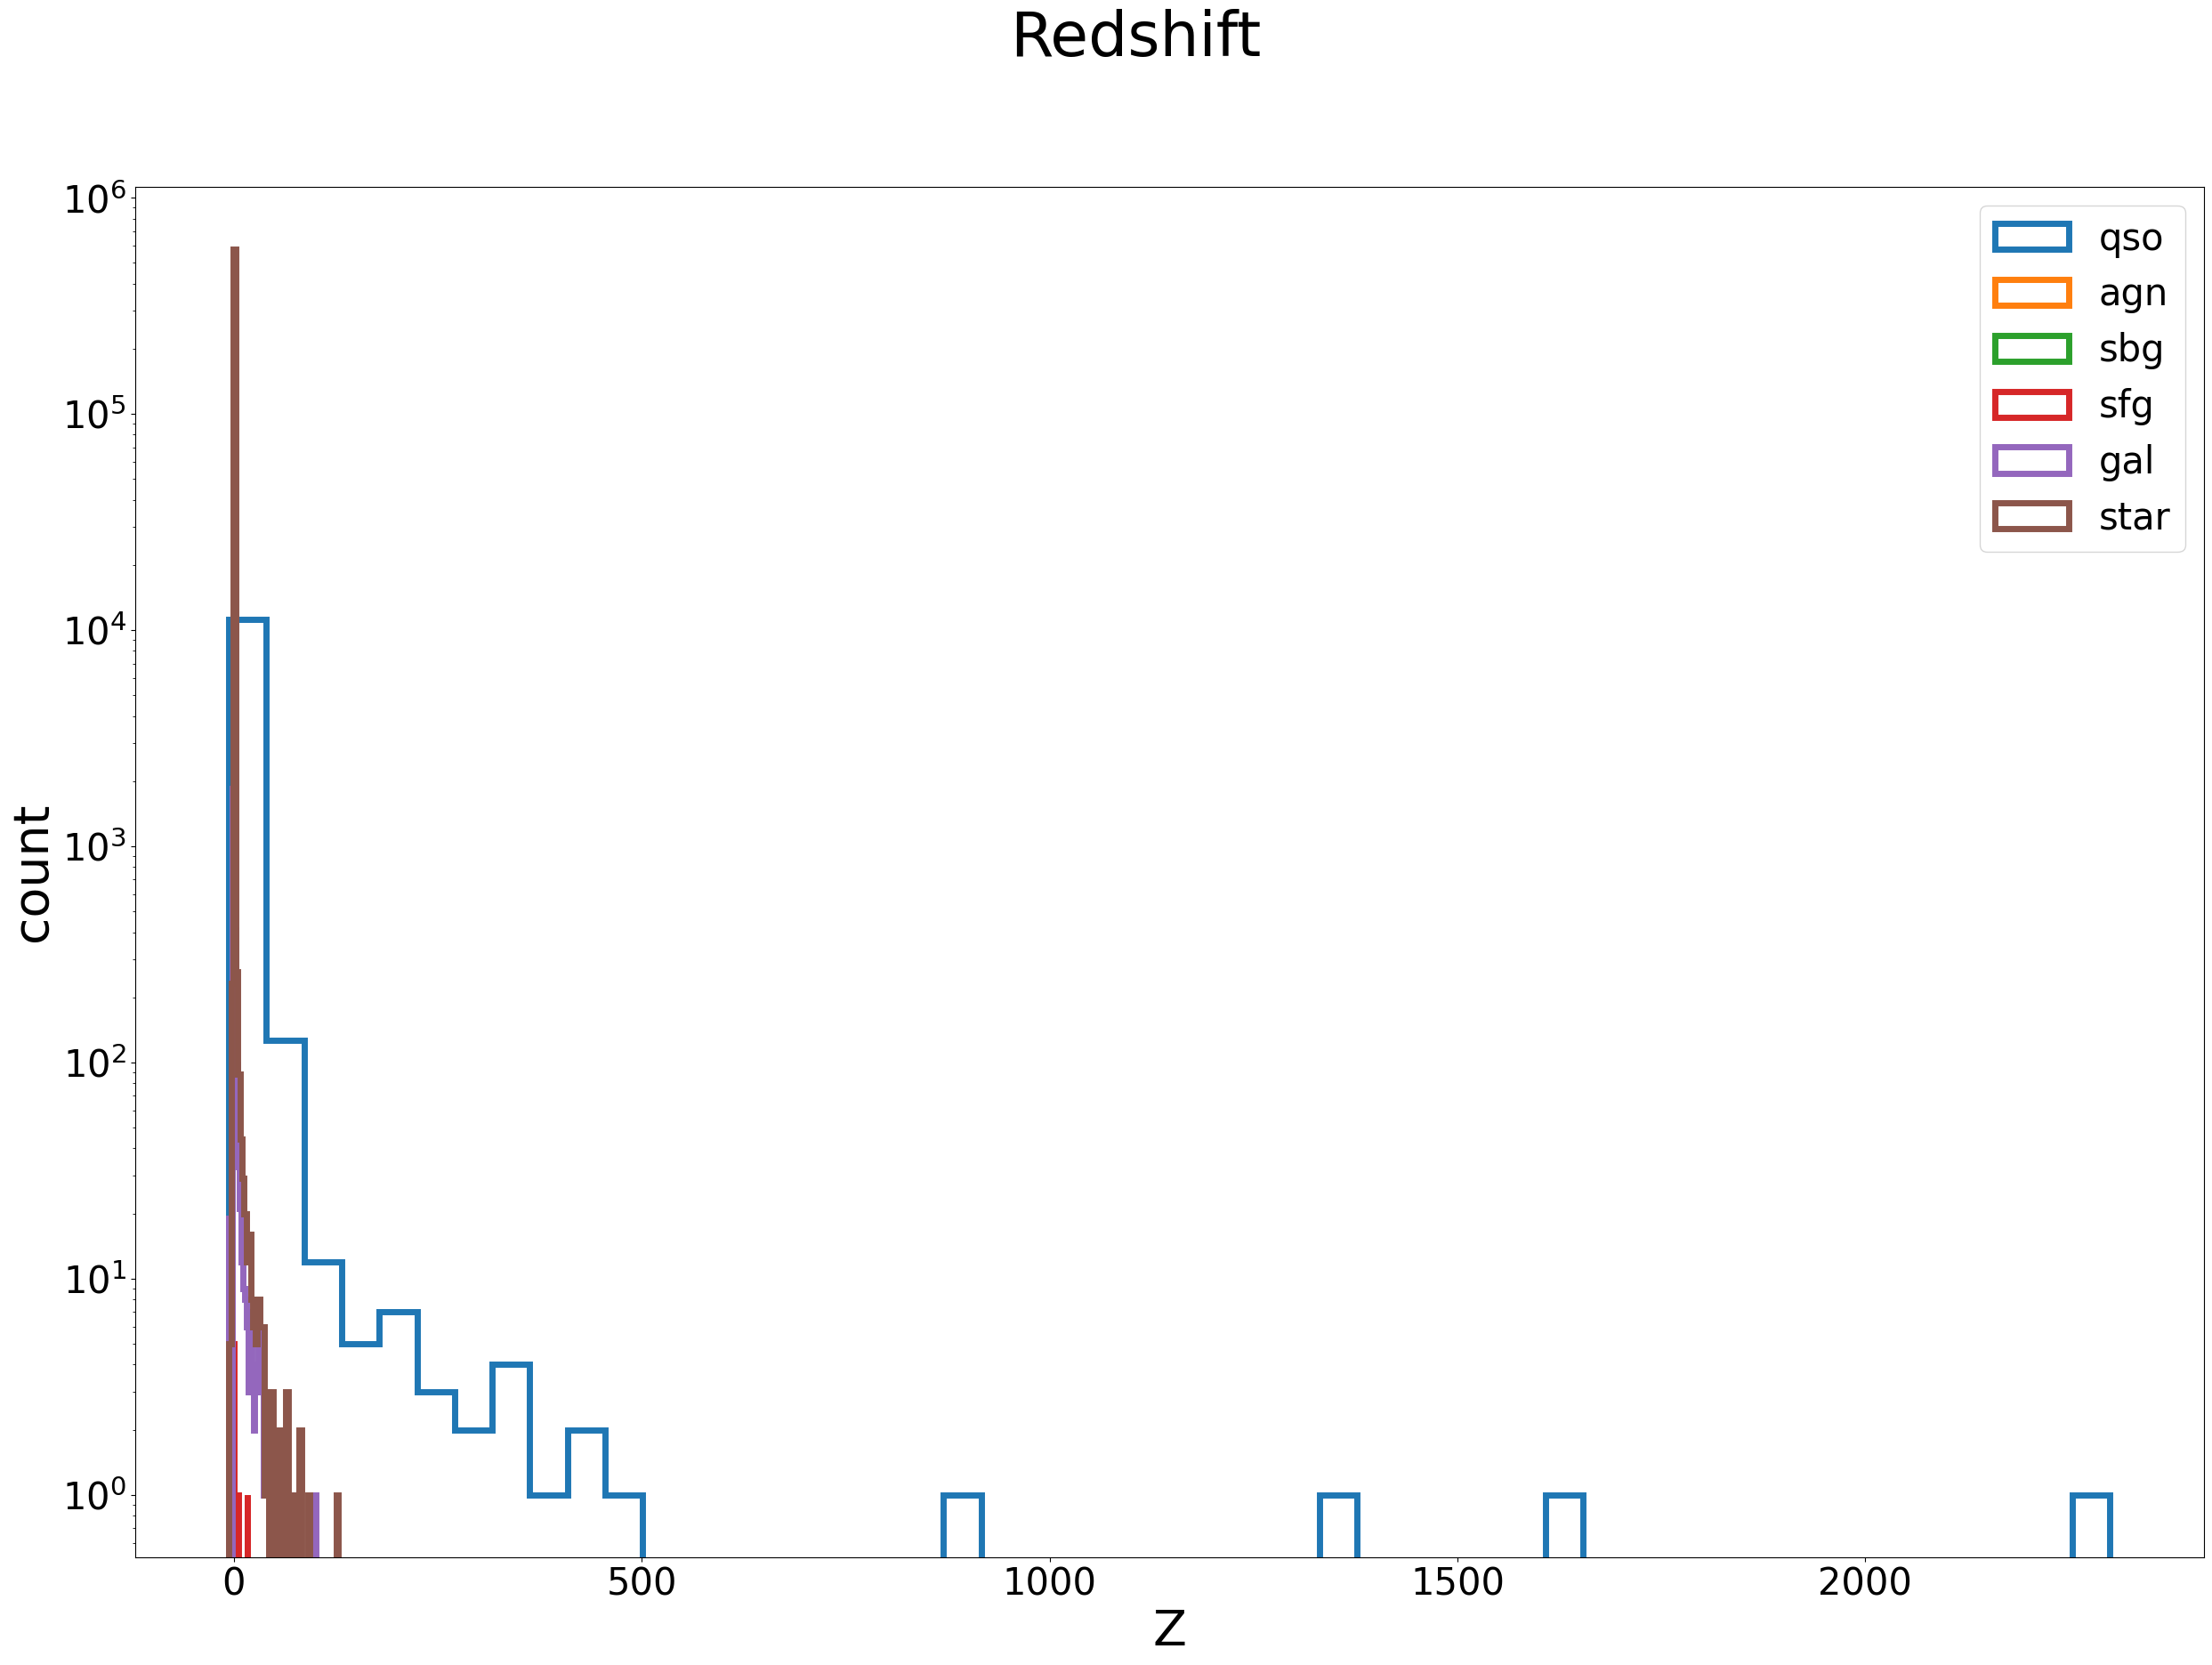

In [30]:

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
fig.suptitle("Redshift", fontsize=50)       
for i, name_class in enumerate(config.name_class):
    #if(not name_class == "star"):
    Histlog(ax,mass_data_class[i],'Z',name_class, histtype='step', fill=config.picture["hist"]["fill"], lw=5)
ax.legend(prop={'size': 30})
fig.set_size_inches(30,20)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

<h1>Processing pipline</h1>

In [4]:
from data_process import data_preparation

data = pd.DataFrame()
#data preparation
if(not config.flags['data_preprocessing']['work']):
    if(os.path.isfile(f'{config.path_ml_data}/{config.name_main_sample}_all.csv')):
        data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
    else:
        data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
else:
    data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)

read data qso
               RA        DEC         z     z_err   angDist  angDist.1   
0       166.53116 -17.520444  2.546282  0.000149  0.063532   0.069244  \
1       166.95578 -17.279537  2.706933  0.000162  0.037483   0.526276   
2         8.29727 -17.178208  2.906453  0.000079  0.047789   0.054932   
3       168.08451 -16.924625  2.807152  0.000094  0.082540   0.157929   
4       167.30094 -16.592488  2.311591  0.000203  0.141427   0.157660   
...           ...        ...       ...       ...       ...        ...   
387427  183.49273  67.869849  2.347018  0.000507  0.268947   0.245011   
387428  188.67065  67.870509  0.274328  0.000031  0.074282   0.120631   
387429  181.60952  67.874351  1.209410  0.000530  0.018842   0.125109   
387430  150.91964  67.875852  0.654613  0.000132  0.087496   0.039498   
387431  179.29461  67.878838  0.904611  0.000177  0.204578   0.227457   

            PQSO      PGal       PSS  nW1  ...  W1mproPM  e_W1mproPM   
0       0.999891  0.000000  0.000109 

In [8]:
data

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,mcd_d,mcd_g,fuzzy_err,fuzzy_dist,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
0,35.597190,3.837424,2.425549,0.000346,0.070777,0.141093,0.004211,0.000000,0.995789,13,...,1.497140,0.391963,0.657785,0.822581,1,0,0,0,0,0
1,202.978760,51.490139,1.148009,0.000996,0.260132,0.224687,0.004987,0.000059,0.994284,13,...,3.310463,0.116097,0.608089,0.656994,1,0,0,0,0,0
2,29.033507,-7.979351,0.900966,0.000251,0.075725,0.082019,1.000000,0.000000,0.000000,12,...,0.970834,0.295232,0.673998,0.872193,1,0,0,0,0,0
3,28.436473,11.498042,1.478283,0.000427,0.065327,0.185995,0.530827,0.021669,0.447499,13,...,2.518412,0.300082,0.638638,0.706857,1,0,0,0,0,0
4,247.647070,16.136115,0.333582,0.000051,0.033028,0.087339,0.999994,0.000006,0.000000,12,...,1.238894,0.353504,0.693267,0.830986,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089488,154.888350,17.979584,0.128058,0.000030,0.135050,0.327203,0.000000,0.039126,0.957413,12,...,0.480327,0.175302,0.645747,0.952209,0,0,0,0,1,0
1089489,244.012990,11.542923,0.144717,0.000024,0.054933,0.068760,0.000000,1.000000,0.000000,12,...,0.811006,0.243216,0.674289,0.857917,0,0,0,1,0,0
1089490,231.949200,9.711369,0.245408,0.000039,0.027507,0.812635,0.000097,0.005596,0.993802,12,...,1.085164,0.322539,0.669382,0.870532,0,0,0,0,1,0
1089491,146.748560,23.532810,0.290307,0.000043,0.095803,0.848273,0.000086,0.000090,0.997860,12,...,3.073659,0.164335,0.573223,0.710810,0,0,0,0,1,0


<h1>PIPELINE</h1>

In [12]:
data = pd.read_csv(f'{config.path_sample}/qso.csv', header = 0, sep = ',')
data

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,W1mproPM,e_W1mproPM,W2mproPM,e_W2mproPM,Gmag,e_Gmag,BPmag,e_BPmag,RPmag,e_RPmag
0,166.53116,-17.520444,2.546282,0.000149,0.063532,0.069244,0.999891,0.000000,0.000109,12,...,14.433,0.016,12.828,0.010,17.481936,0.003047,17.743029,0.009197,17.036100,0.010138
1,166.95578,-17.279537,2.706933,0.000162,0.037483,0.526276,0.376463,0.000000,0.623525,10,...,17.344,0.071,16.607,0.124,20.259129,0.006588,20.425865,0.102585,19.970352,0.105972
2,8.29727,-17.178208,2.906453,0.000079,0.047789,0.054932,0.999996,0.000000,0.000004,13,...,14.294,0.016,13.511,0.013,17.765369,0.003616,17.982643,0.015037,17.429415,0.015400
3,168.08451,-16.924625,2.807152,0.000094,0.082540,0.157929,1.000000,0.000000,0.000000,12,...,15.575,0.022,14.692,0.025,18.956263,0.003671,19.161470,0.032866,18.661314,0.031291
4,167.30094,-16.592488,2.311591,0.000203,0.141427,0.157660,1.000000,0.000000,0.000000,12,...,16.319,0.032,15.187,0.034,19.561516,0.007019,19.819702,0.061305,19.068604,0.055442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387427,183.49273,67.869849,2.347018,0.000507,0.268947,0.245011,0.007657,0.000240,0.991072,12,...,17.164,0.047,16.028,0.049,20.842554,0.017973,20.894686,0.172916,20.200535,0.209909
387428,188.67065,67.870509,0.274328,0.000031,0.074282,0.120631,0.946483,0.053517,0.000000,12,...,13.638,0.012,12.735,0.009,18.656752,0.006298,18.323277,0.025215,17.542183,0.017575
387429,181.60952,67.874351,1.209410,0.000530,0.018842,0.125109,1.000000,0.000000,0.000000,12,...,15.846,0.021,14.471,0.015,19.470741,0.006899,19.595501,0.059338,19.218256,0.048722
387430,150.91964,67.875852,0.654613,0.000132,0.087496,0.039498,1.000000,0.000000,0.000000,11,...,14.095,0.013,12.977,0.009,18.324120,0.005217,18.388796,0.021689,17.924681,0.022136


<h2>Deredded</h2>

In [13]:
from data_process import deredded

data_deredded = deredded(data,config)
data_deredded

['mags']
DEREDDED PROCESS
Input: 387432 | Output: 387300


,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,e_W1mproPM,W2mproPM,e_W2mproPM,Gmag,e_Gmag,BPmag,e_BPmag,RPmag,e_RPmag,E(B-V)
0,166.53116,-17.520444,2.546282,0.000149,0.063532,0.069244,0.999891,0.000000,0.000109,12,...,0.016,12.821646,0.010,17.373094,0.003047,17.604997,0.009197,16.956126,0.010138,0.046041
1,166.95578,-17.279537,2.706933,0.000162,0.037483,0.526276,0.376463,0.000000,0.623525,10,...,0.071,16.600179,0.124,20.142283,0.006588,20.277682,0.102585,19.884497,0.105972,0.049427
2,8.29727,-17.178208,2.906453,0.000079,0.047789,0.054932,0.999996,0.000000,0.000004,13,...,0.016,13.508201,0.013,17.717413,0.003616,17.921826,0.015037,17.394179,0.015400,0.020286
3,168.08451,-16.924625,2.807152,0.000094,0.082540,0.157929,1.000000,0.000000,0.000000,12,...,0.022,14.680604,0.025,18.761048,0.003671,18.913900,0.032866,18.517875,0.031291,0.082578
4,167.30094,-16.592488,2.311591,0.000203,0.141427,0.157660,1.000000,0.000000,0.000000,12,...,0.032,15.177342,0.034,19.396063,0.007019,19.609876,0.061305,18.947034,0.055442,0.069989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387427,183.49273,67.869849,2.347018,0.000507,0.268947,0.245011,0.007657,0.000240,0.991072,12,...,0.047,16.024961,0.049,20.790503,0.017973,20.828675,0.172916,20.162289,0.209909,0.022018
387428,188.67065,67.870509,0.274328,0.000031,0.074282,0.120631,0.946483,0.053517,0.000000,12,...,0.012,12.733135,0.009,18.624803,0.006298,18.282760,0.025215,17.518708,0.017575,0.013515
387429,181.60952,67.874351,1.209410,0.000530,0.018842,0.125109,1.000000,0.000000,0.000000,12,...,0.021,14.468940,0.015,19.435444,0.006899,19.550738,0.059338,19.192321,0.048722,0.014931
387430,150.91964,67.875852,0.654613,0.000132,0.087496,0.039498,1.000000,0.000000,0.000000,11,...,0.013,12.967437,0.009,18.160310,0.005217,18.181054,0.021689,17.804318,0.022136,0.069294


<b>E(B-V)</b> column values in <b><i>"cut": false</i></b> case

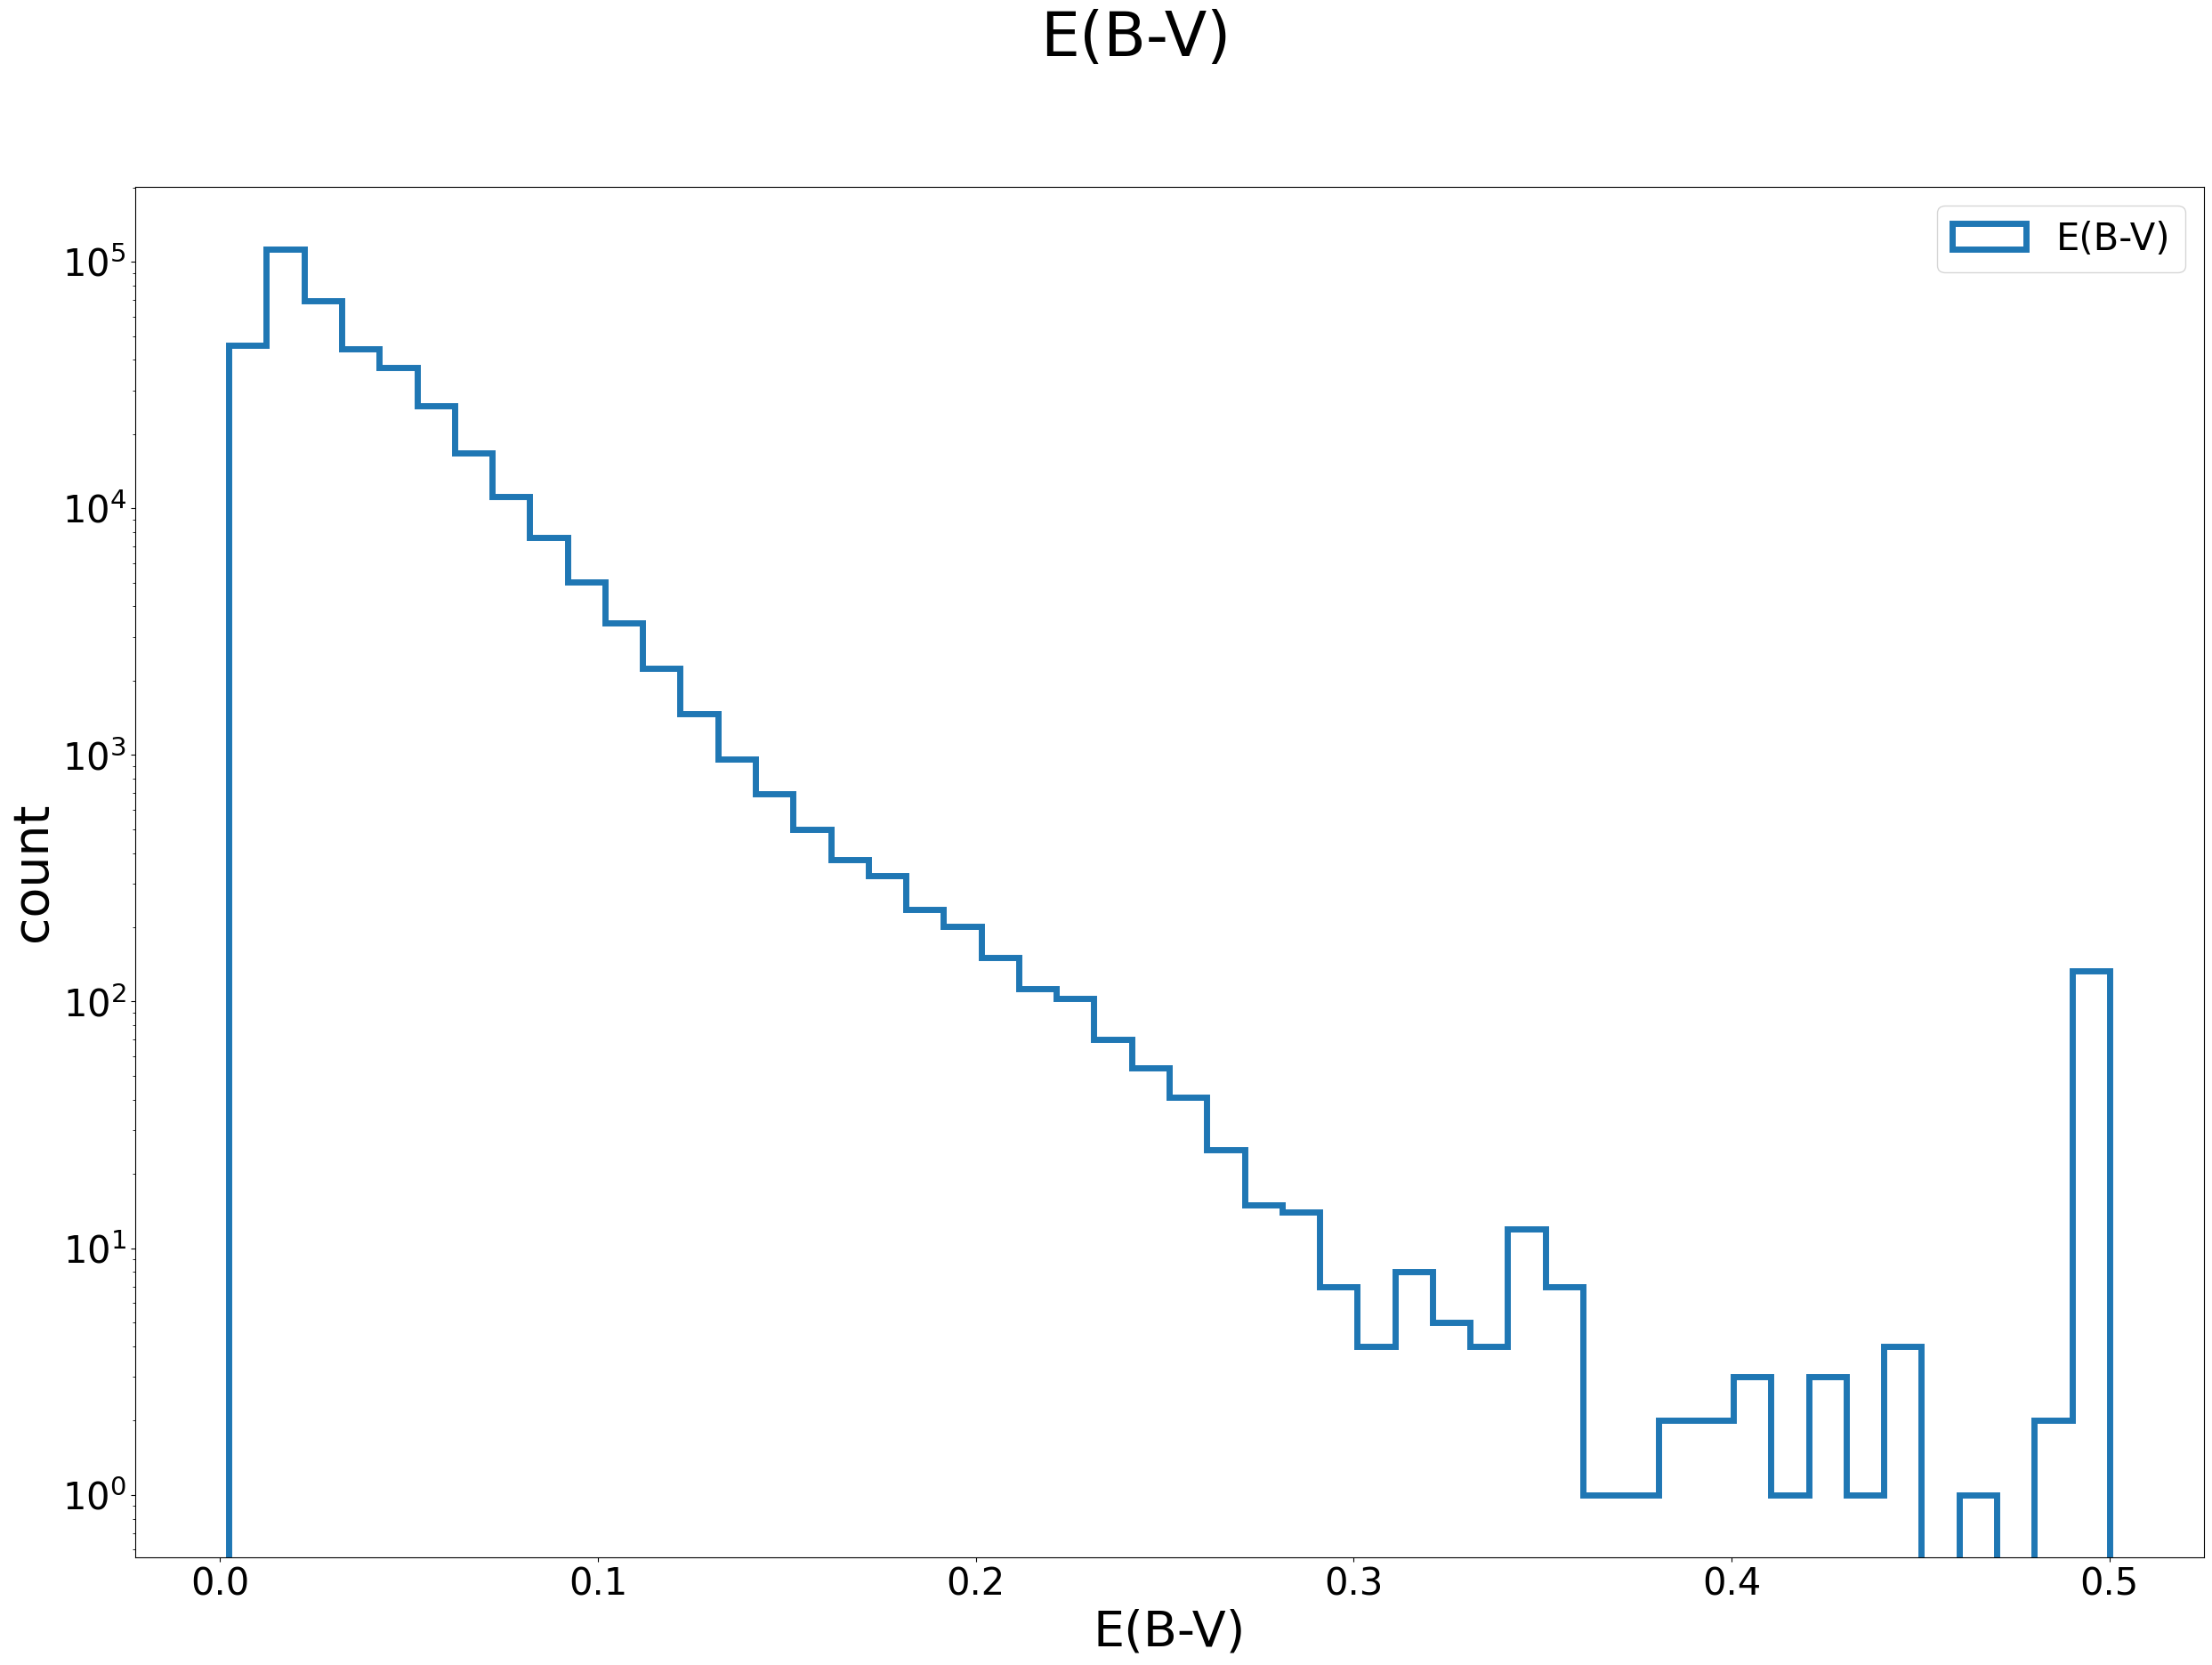

In [8]:

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
fig.suptitle("E(B-V)", fontsize=50)       
#for i, name_class in enumerate(config.name_class):
    #if(not name_class == "star"):
Histlog(ax,data_deredded["E(B-V)"],'E(B-V)',"E(B-V)", histtype='step', fill=config.picture["hist"]["fill"], lw=5)
ax.legend(prop={'size': 30})
fig.set_size_inches(30,20)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

<h2>Range cut</h2>

In [16]:

def range_cut(data):
    features = get_features(["mags"],config)
    range_cut_pd = pd.DataFrame(columns=["qso"],index=features)
    for i in range(len(config.features["data"]["photometry"]) // 2):
        range_cut_pd.loc[features[i], "qso"] = data.shape[0]-data[(data[config.features["data"]["photometry"][i*2]] > config.features["range"]["photometry"][i][0]) & (data[config.features["data"]["photometry"][i*2]] < config.features["range"]["photometry"][i][1])].shape[0]
    for i in range(len(config.features["data"]["photometry"]) // 2):
        data = data[(data[config.features["data"]["photometry"][i*2]] > config.features["range"]["photometry"][i][0]) & (data[config.features["data"]["photometry"][i*2]] < config.features["range"]["photometry"][i][1])]
    print(range_cut_pd)
    data = data.reset_index(drop=True)
    return data

data_range_cut = range_cut(data_deredded)
data_range_cut

['mags']
            qso
W1mproPM     72
W2mproPM    315
Gmag         15
BPmag     21325
RPmag      1937


,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,e_W1mproPM,W2mproPM,e_W2mproPM,Gmag,e_Gmag,BPmag,e_BPmag,RPmag,e_RPmag,E(B-V)
0,166.53116,-17.520444,2.546282,0.000149,0.063532,0.069244,0.999891,0.000000,0.000109,12,...,0.016,12.821646,0.010,17.373094,0.003047,17.604997,0.009197,16.956126,0.010138,0.046041
1,166.95578,-17.279537,2.706933,0.000162,0.037483,0.526276,0.376463,0.000000,0.623525,10,...,0.071,16.600179,0.124,20.142283,0.006588,20.277682,0.102585,19.884497,0.105972,0.049427
2,8.29727,-17.178208,2.906453,0.000079,0.047789,0.054932,0.999996,0.000000,0.000004,13,...,0.016,13.508201,0.013,17.717413,0.003616,17.921826,0.015037,17.394179,0.015400,0.020286
3,168.08451,-16.924625,2.807152,0.000094,0.082540,0.157929,1.000000,0.000000,0.000000,12,...,0.022,14.680604,0.025,18.761048,0.003671,18.913900,0.032866,18.517875,0.031291,0.082578
4,167.30094,-16.592488,2.311591,0.000203,0.141427,0.157660,1.000000,0.000000,0.000000,12,...,0.032,15.177342,0.034,19.396063,0.007019,19.609876,0.061305,18.947034,0.055442,0.069989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364540,183.49273,67.869849,2.347018,0.000507,0.268947,0.245011,0.007657,0.000240,0.991072,12,...,0.047,16.024961,0.049,20.790503,0.017973,20.828675,0.172916,20.162289,0.209909,0.022018
364541,188.67065,67.870509,0.274328,0.000031,0.074282,0.120631,0.946483,0.053517,0.000000,12,...,0.012,12.733135,0.009,18.624803,0.006298,18.282760,0.025215,17.518708,0.017575,0.013515
364542,181.60952,67.874351,1.209410,0.000530,0.018842,0.125109,1.000000,0.000000,0.000000,12,...,0.021,14.468940,0.015,19.435444,0.006899,19.550738,0.059338,19.192321,0.048722,0.014931
364543,150.91964,67.875852,0.654613,0.000132,0.087496,0.039498,1.000000,0.000000,0.000000,11,...,0.013,12.967437,0.009,18.160310,0.005217,18.181054,0.021689,17.804318,0.022136,0.069294


In [14]:
from data_process import get_features
get_features(["mags"],config)

['mags']


['W1mproPM', 'W2mproPM', 'Gmag', 'BPmag', 'RPmag']

<b>qso</b> range cut by photometry histogram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

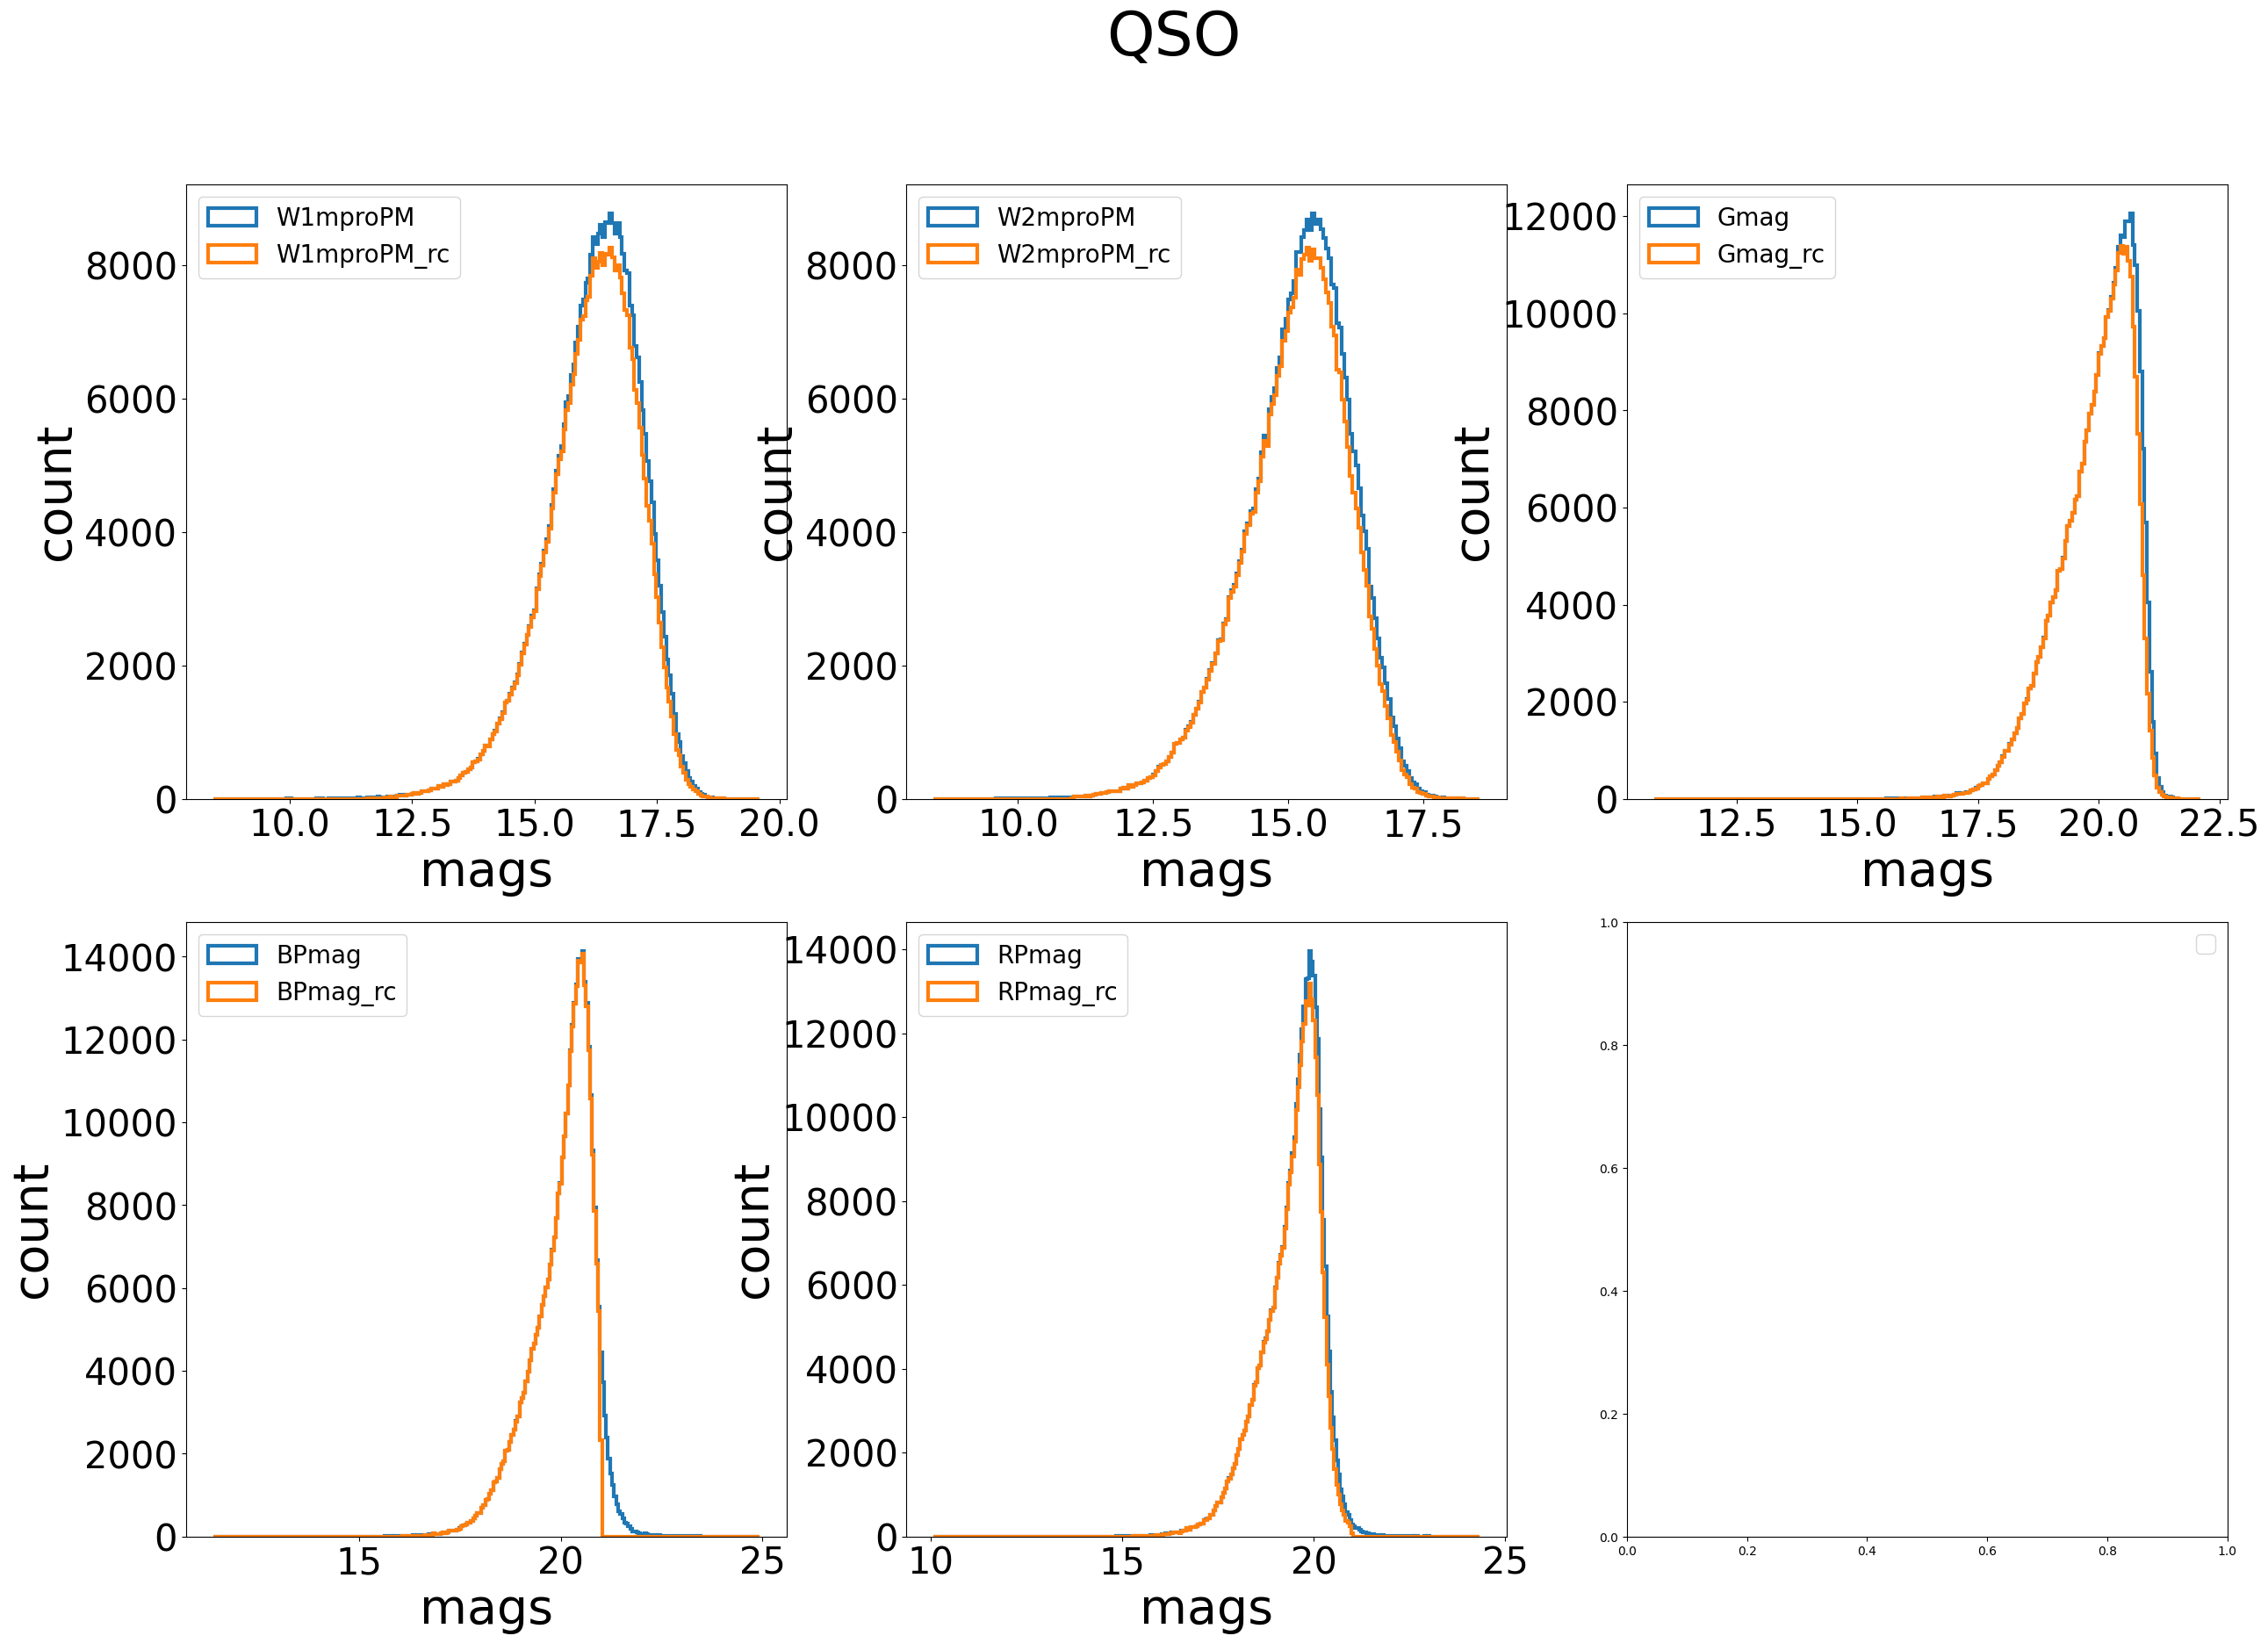

In [13]:
fig=plt.figure()
fig, axs = plt.subplots(2,3)

features = ['W1mproPM', 'W2mproPM', 'Gmag', 'BPmag', 'RPmag']
binwidth = 0.05

fig.suptitle("QSO", fontsize=50)       
for i in range(2):
    for j in range(3):
        if(i*3 + j < len(features)):
            Hist(axs[i,j],data_deredded[features[i*3+j]],"mags", features[i*3+j],
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),                
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)
            Hist(axs[i,j],data_range_cut[features[i*3+j]],"mags", f"{features[i*3+j]}_rc",
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)

        axs[i,j].legend(prop={'size': 20})
fig.set_size_inches(30,20)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()

<b>sbg</b> range cut by photometry histogram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

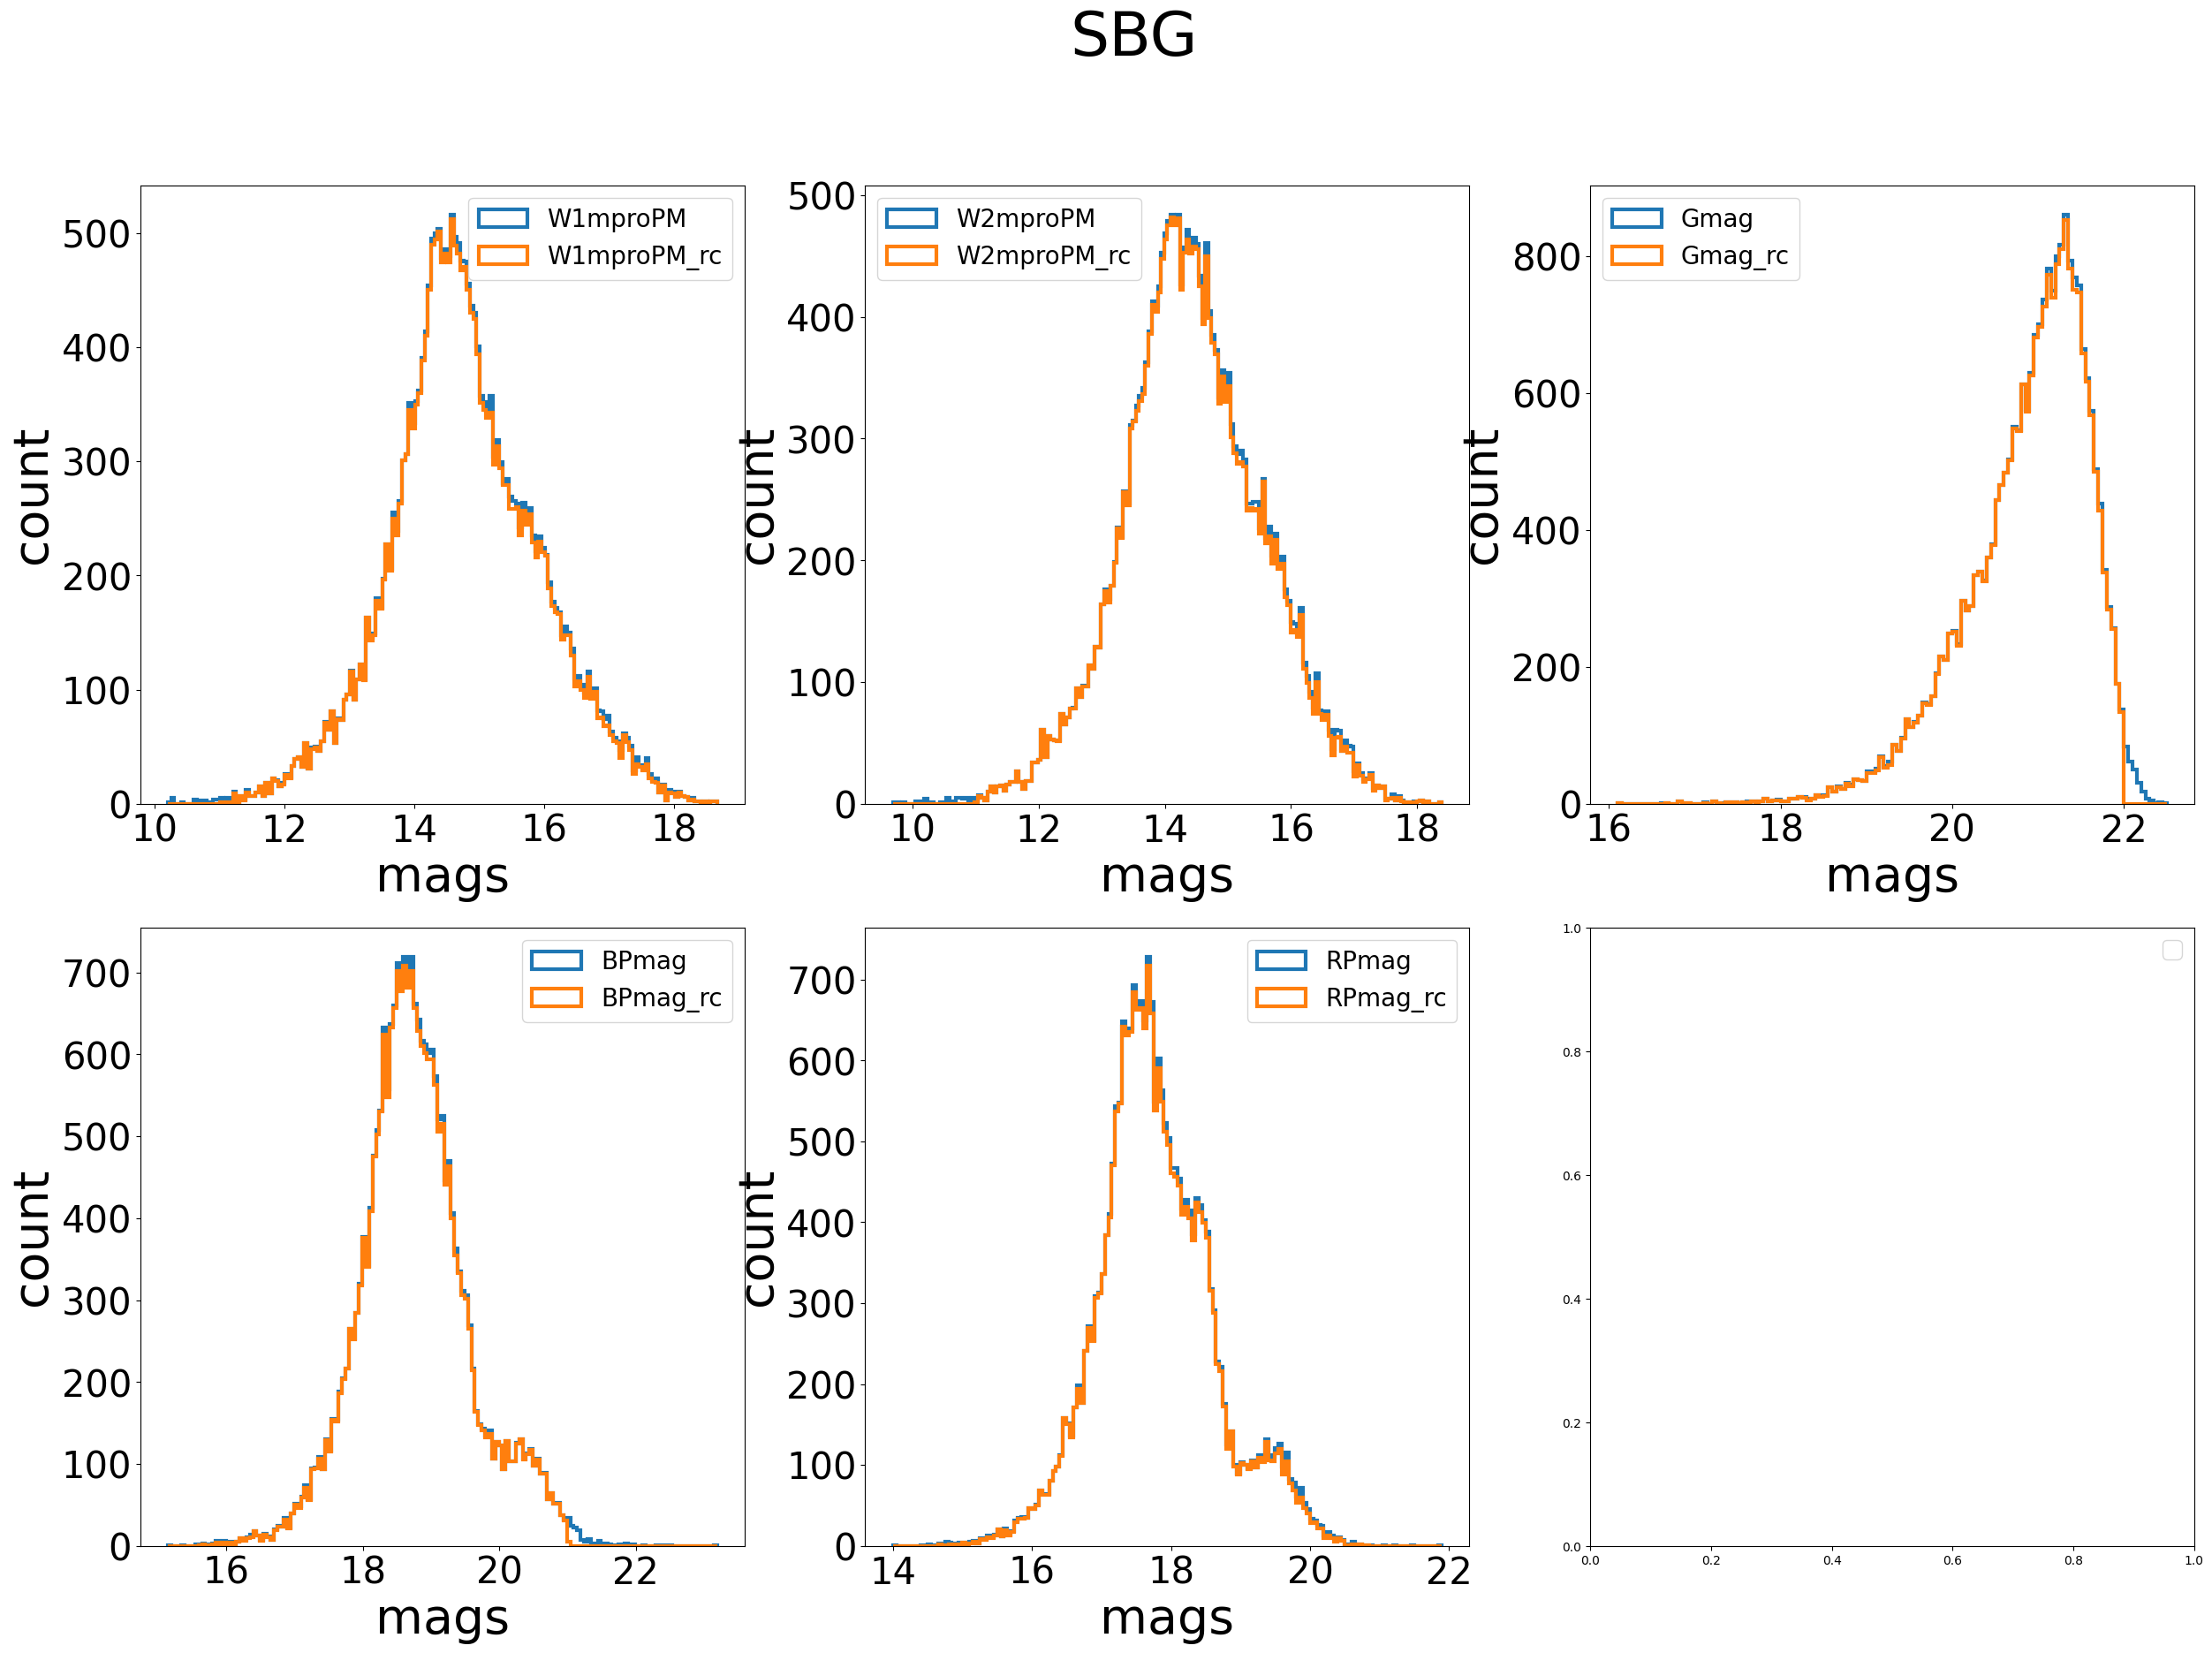

In [17]:
fig=plt.figure()
fig, axs = plt.subplots(2,3)

features = ['W1mproPM', 'W2mproPM', 'Gmag', 'BPmag', 'RPmag']
binwidth = 0.05

fig.suptitle("SBG", fontsize=50)       
for i in range(2):
    for j in range(3):
        if(i*3 + j < len(features)):
            Hist(axs[i,j],data_deredded[features[i*3+j]],"mags", features[i*3+j],
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),                
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)
            Hist(axs[i,j],data_range_cut[features[i*3+j]],"mags", f"{features[i*3+j]}_rc",
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)

        axs[i,j].legend(prop={'size': 20})
fig.set_size_inches(30,20)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()

<b>sfg</b> range cut by photometry histogram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

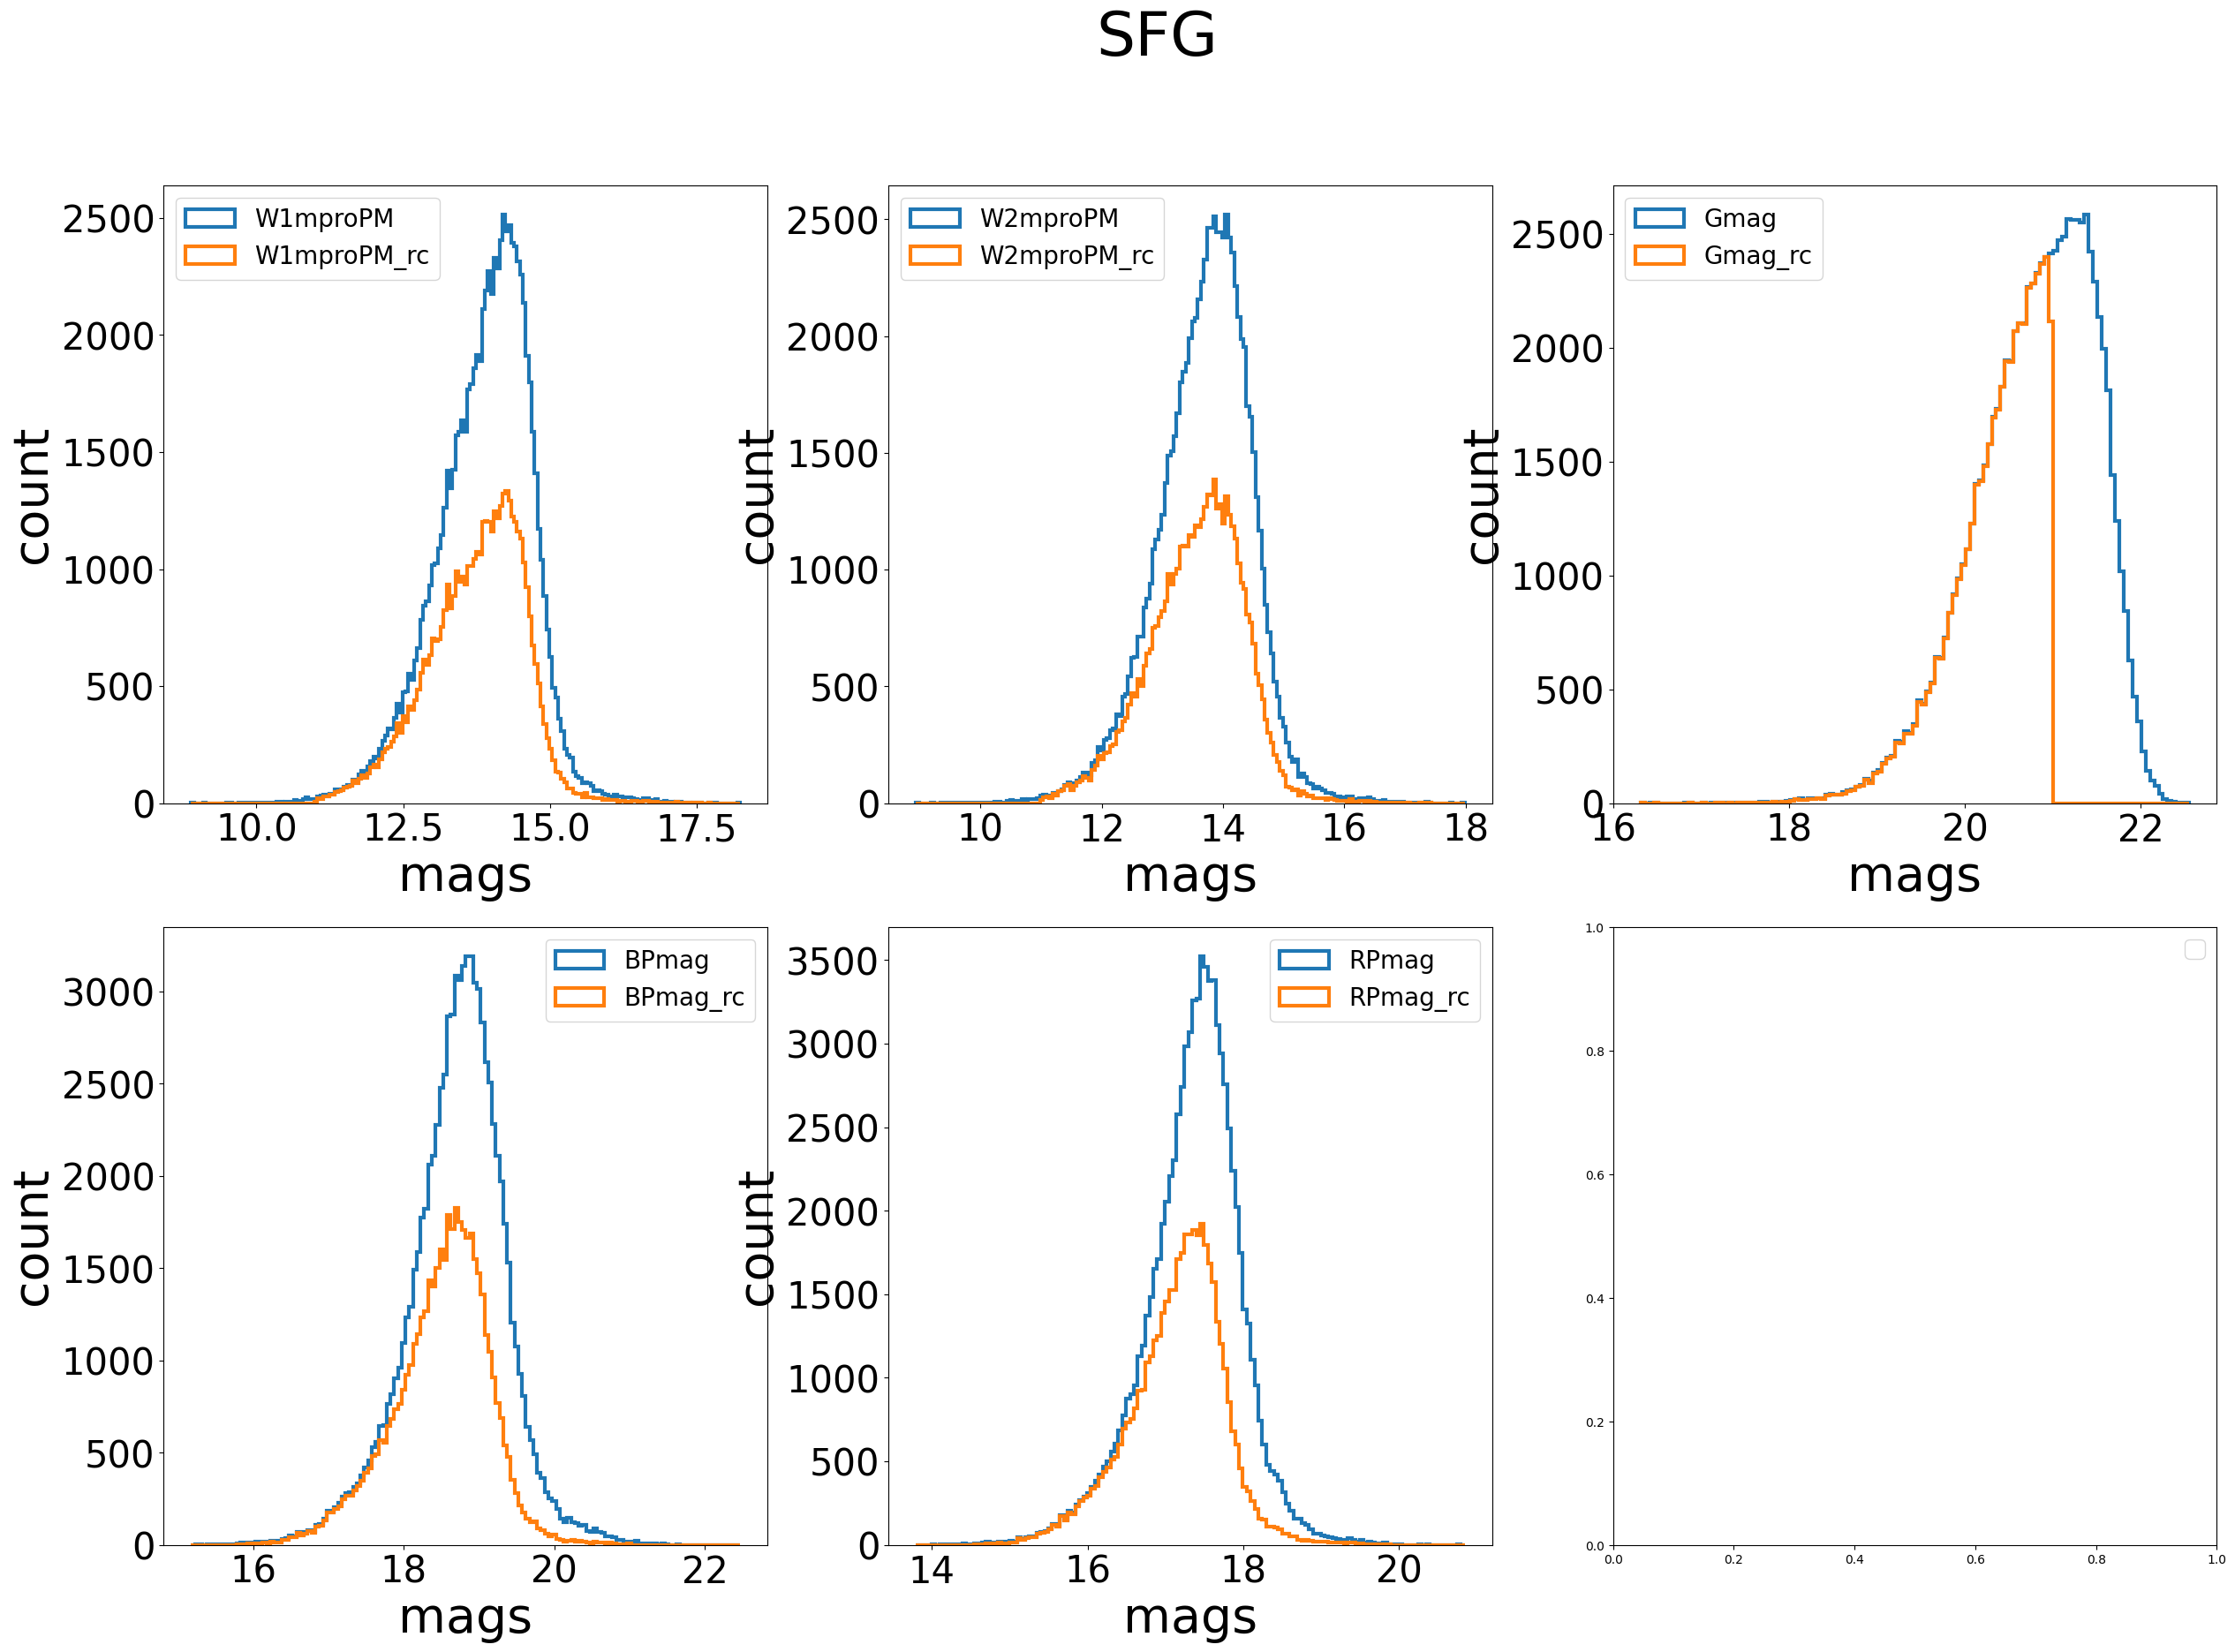

In [79]:
fig=plt.figure()
fig, axs = plt.subplots(2,3)

features = ['W1mproPM', 'W2mproPM', 'Gmag', 'BPmag', 'RPmag']
binwidth = 0.05

fig.suptitle("SFG", fontsize=50)       
for i in range(2):
    for j in range(3):
        if(i*3 + j < len(features)):
            Hist(axs[i,j],data_deredded[features[i*3+j]],"mags", features[i*3+j],
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),                
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)
            Hist(axs[i,j],data_range_cut[features[i*3+j]],"mags", f"{features[i*3+j]}_rc",
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)

        axs[i,j].legend(prop={'size': 20})
fig.set_size_inches(30,20)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()

<b>gal</b> range cut by photometry histogram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

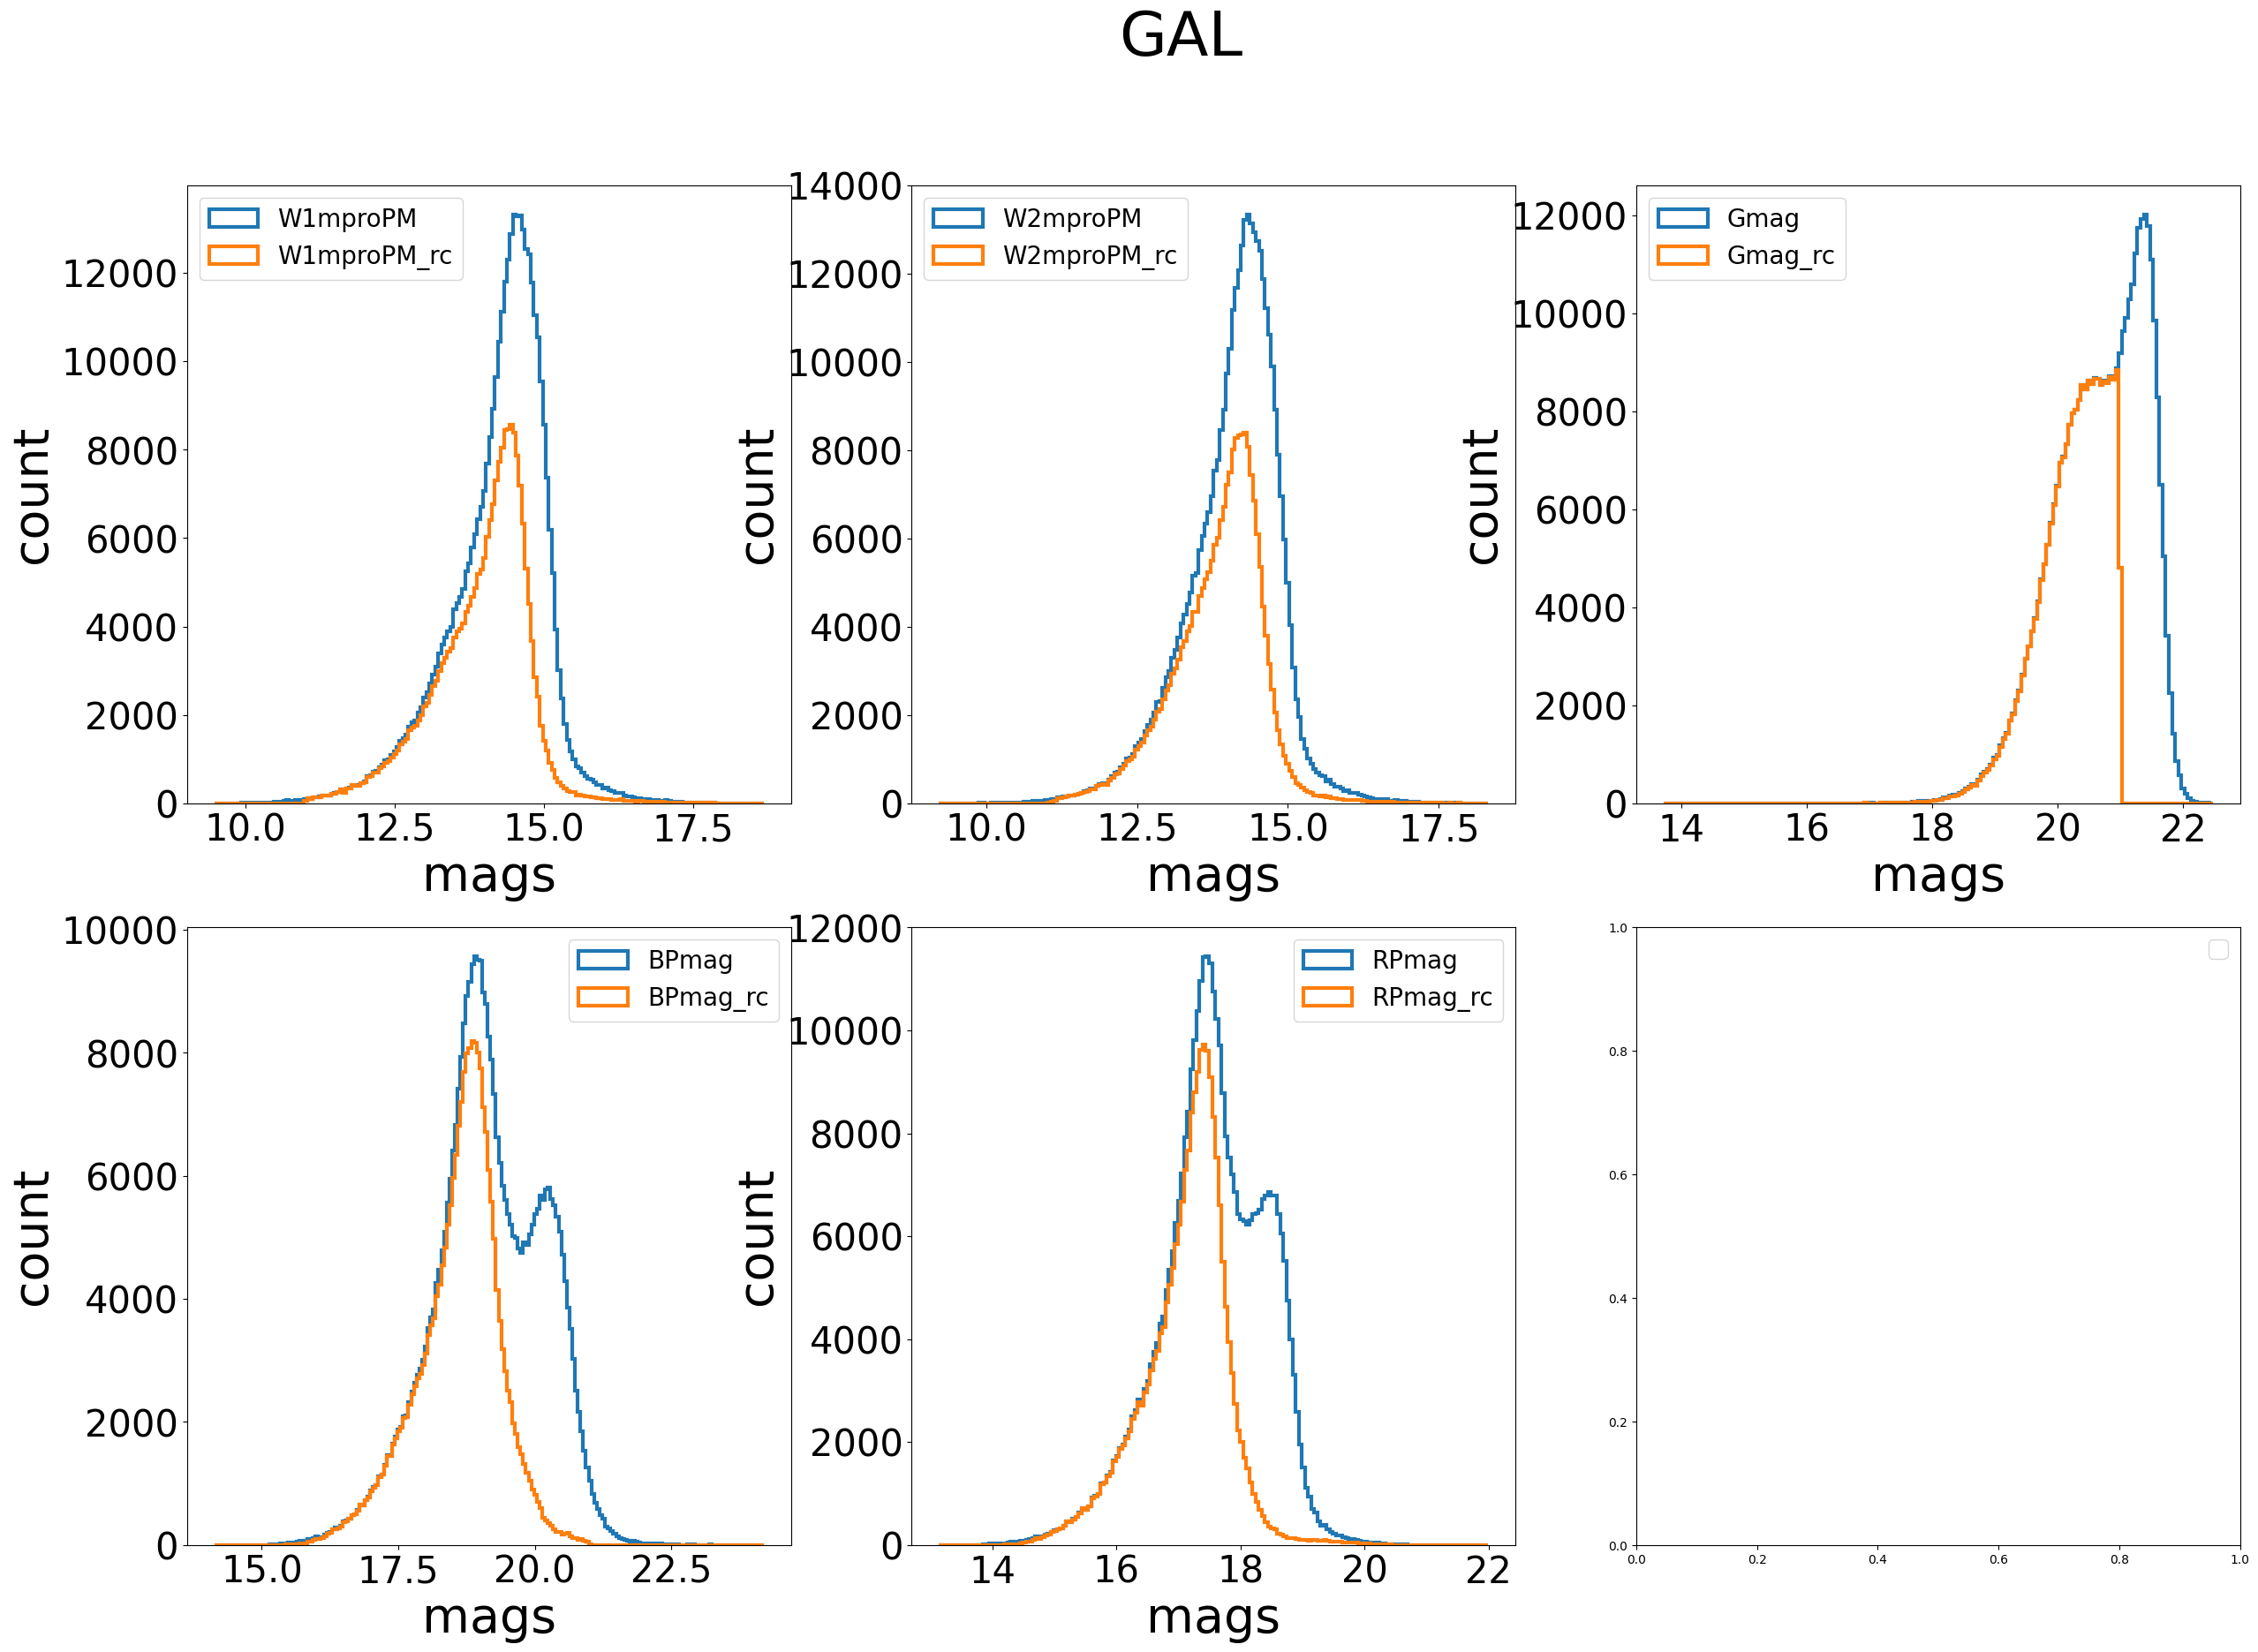

In [86]:
fig=plt.figure()
fig, axs = plt.subplots(2,3)

features = ['W1mproPM', 'W2mproPM', 'Gmag', 'BPmag', 'RPmag']
binwidth = 0.05

fig.suptitle("GAL", fontsize=50)       
for i in range(2):
    for j in range(3):
        if(i*3 + j < len(features)):
            Hist(axs[i,j],data_deredded[features[i*3+j]],"mags", features[i*3+j],
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),                
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)
            Hist(axs[i,j],data_range_cut[features[i*3+j]],"mags", f"{features[i*3+j]}_rc",
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)

        axs[i,j].legend(prop={'size': 20})
fig.set_size_inches(30,20)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

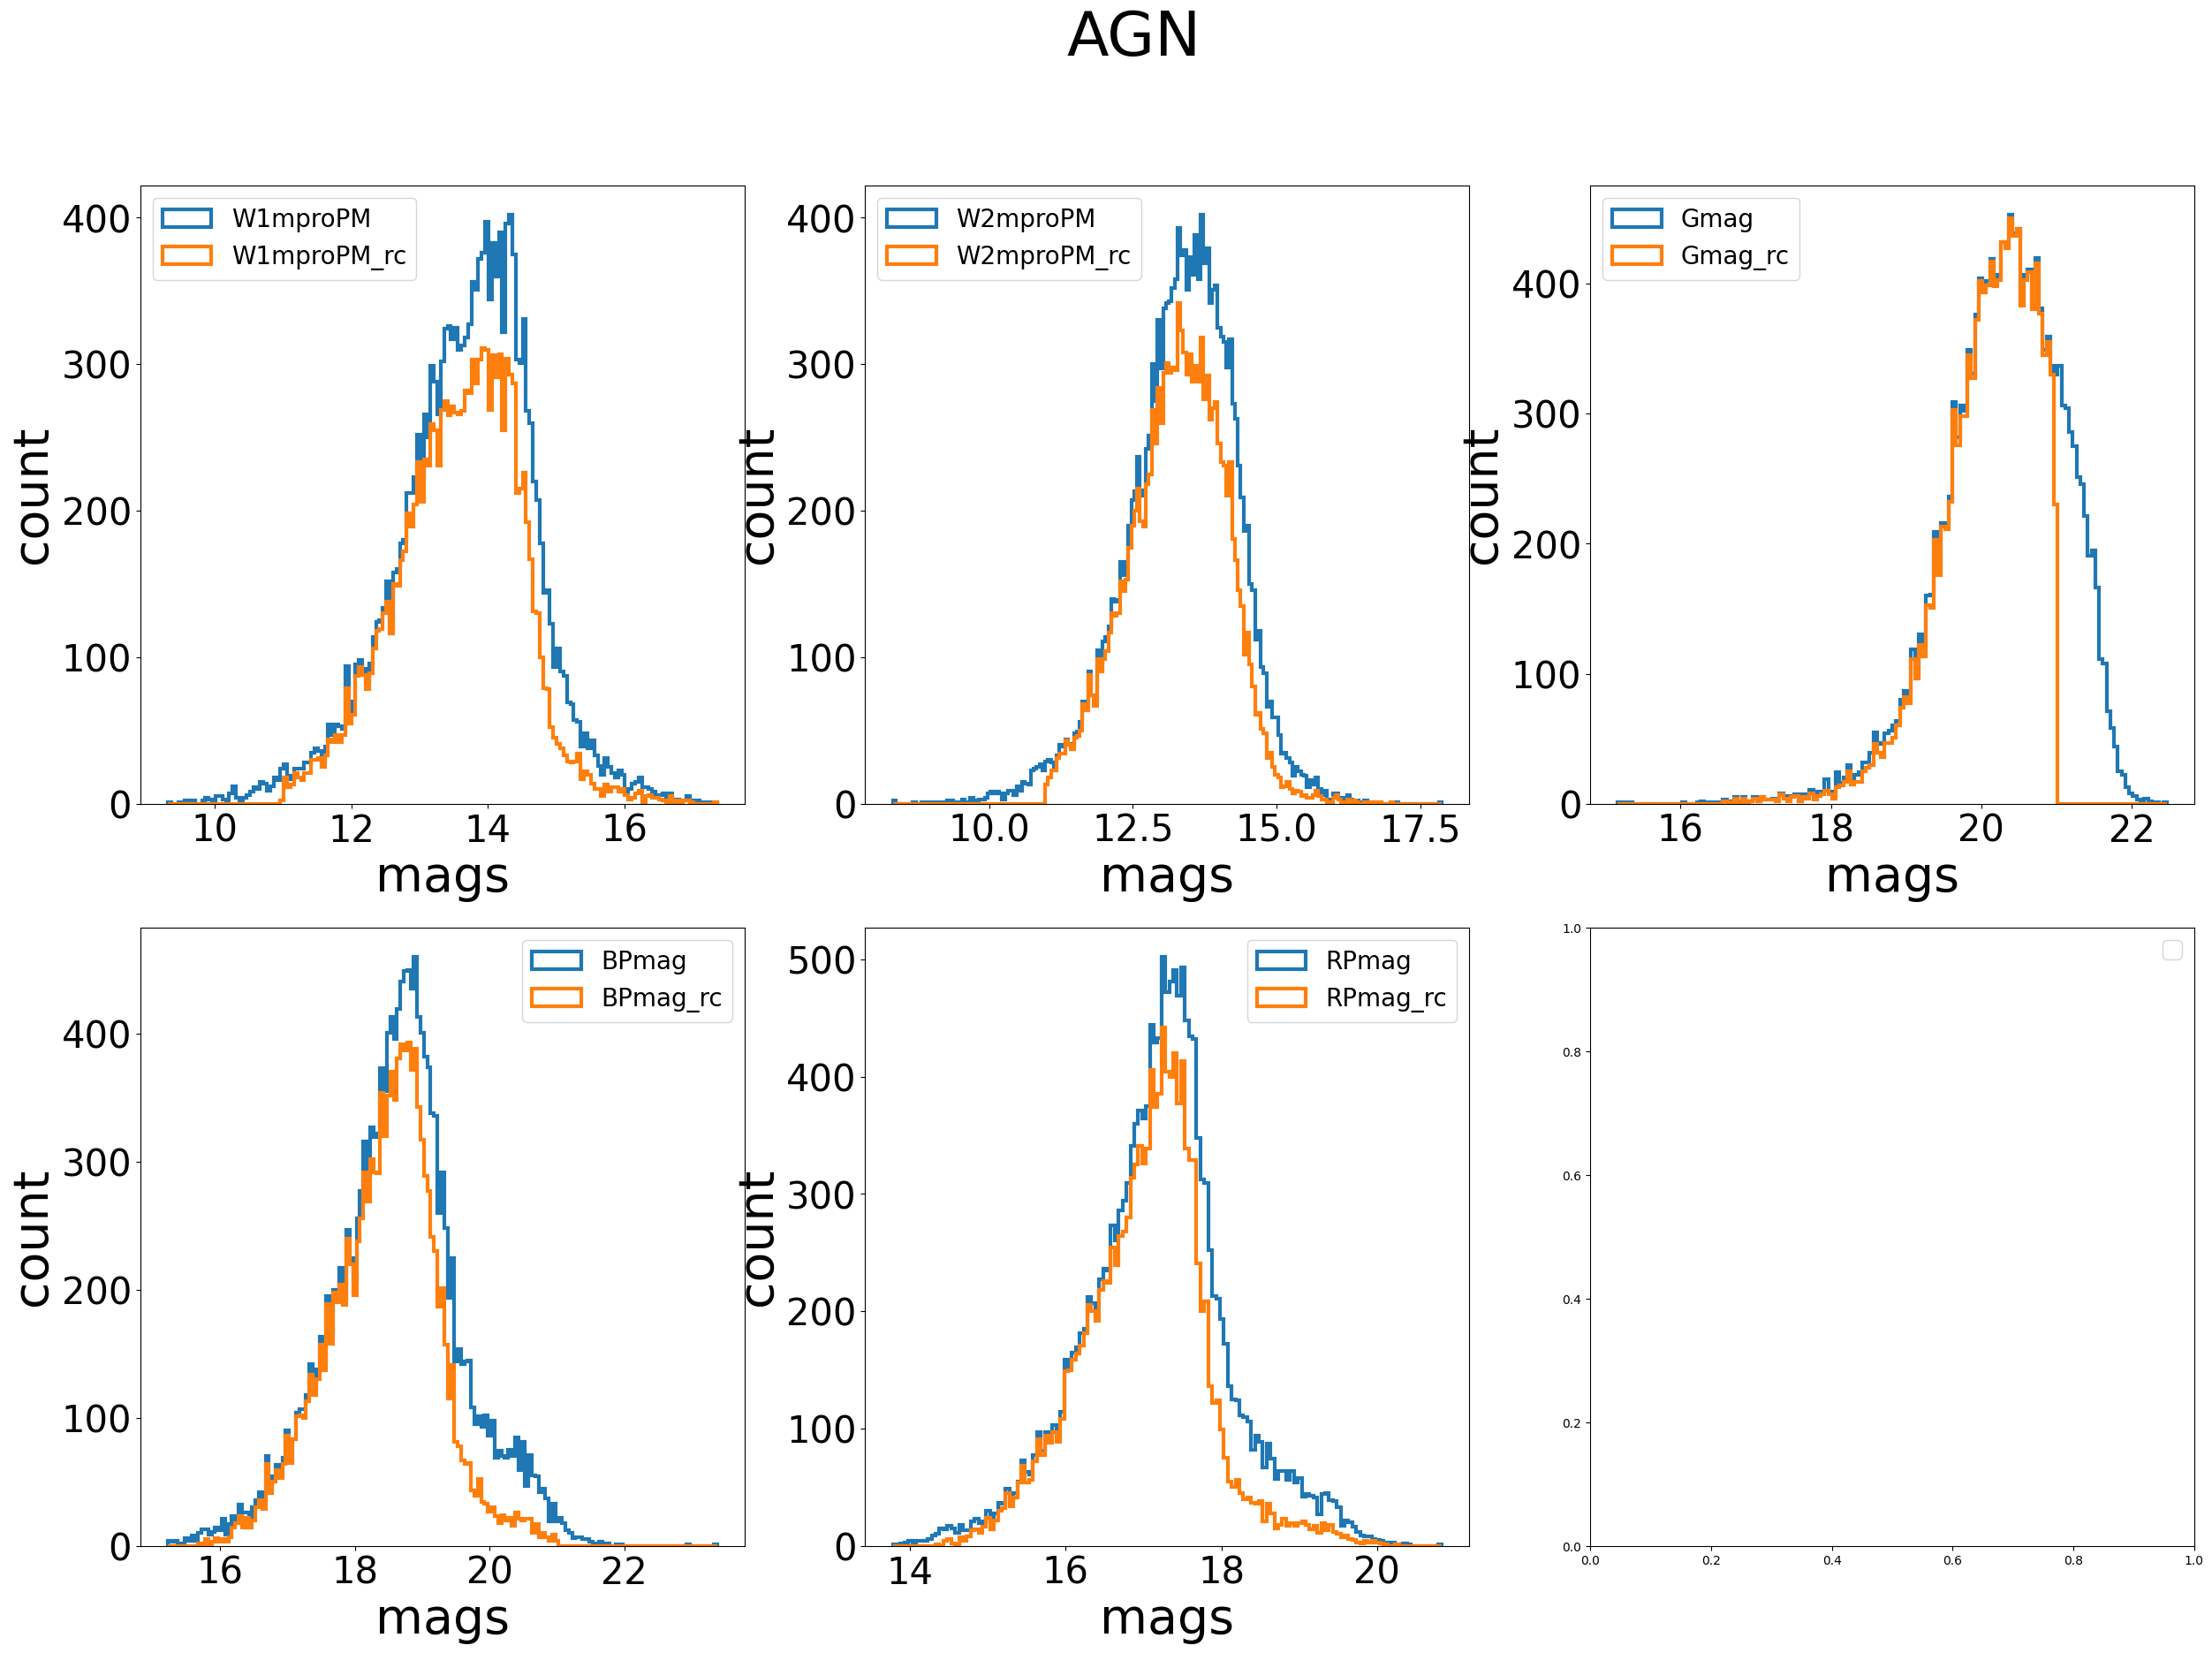

In [90]:
fig=plt.figure()
fig, axs = plt.subplots(2,3)

features = ['W1mproPM', 'W2mproPM', 'Gmag', 'BPmag', 'RPmag']
binwidth = 0.05

fig.suptitle("AGN", fontsize=50)       
for i in range(2):
    for j in range(3):
        if(i*3 + j < len(features)):
            Hist(axs[i,j],data_deredded[features[i*3+j]],"mags", features[i*3+j], 
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth), 
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)
            Hist(axs[i,j],data_range_cut[features[i*3+j]],"mags", f"{features[i*3+j]}_rc",
                bins=np.arange(min(data_deredded[features[i*3+j]]), max(data_deredded[features[i*3+j]]) + binwidth, step=binwidth),
                histtype='step', fill=config.picture["hist"]["fill"], lw=3)

        axs[i,j].legend(prop={'size': 20})
fig.set_size_inches(30,20)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()

<h2>Flux</h2>

In [17]:
from data_process import flux_var

def flux(data):
    data_flux_var, data_flux_color = flux_var(data[config.features["data"]["flux"]])
    if(config.flags['data_preprocessing']['main_sample']['flux']['var']):
        data = pd.concat([data,data_flux_var],axis=1)
    if(config.flags['data_preprocessing']['main_sample']['flux']['color']):
        data = pd.concat([data,data_flux_color],axis=1)
    
    return data

data_flux = flux(data_range_cut)
data_flux

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,BPmag,e_BPmag,RPmag,e_RPmag,E(B-V),var_FW1pm,var_FW2pm,var_FG,var_FBP,var_FRP
0,166.53116,-17.520444,2.546282,0.000149,0.063532,0.069244,0.999891,0.000000,0.000109,12,...,17.604997,0.009197,16.956126,0.010138,0.046041,0.051244,0.033282,0.025687,0.056502,0.059402
1,166.95578,-17.279537,2.706933,0.000162,0.037483,0.526276,0.376463,0.000000,0.623525,10,...,20.277682,0.102585,19.884497,0.105972,0.049427,0.208985,0.228070,0.092881,0.508627,0.506839
2,8.29727,-17.178208,2.906453,0.000079,0.047789,0.054932,0.999996,0.000000,0.000004,13,...,17.921826,0.015037,17.394179,0.015400,0.020286,0.052581,0.042095,0.034653,0.070714,0.070110
3,168.08451,-16.924625,2.807152,0.000094,0.082540,0.157929,1.000000,0.000000,0.000000,12,...,18.913900,0.032866,18.517875,0.031291,0.082578,0.070576,0.080742,0.048241,0.213276,0.202297
4,167.30094,-16.592488,2.311591,0.000203,0.141427,0.157660,1.000000,0.000000,0.000000,12,...,19.609876,0.061305,18.947034,0.055442,0.069989,0.102640,0.107095,0.099677,0.308945,0.283653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364540,183.49273,67.869849,2.347018,0.000507,0.268947,0.245011,0.007657,0.000240,0.991072,12,...,20.828675,0.172916,20.162289,0.209909,0.022018,0.147734,0.160706,0.136859,0.421312,0.511428
364541,188.67065,67.870509,0.274328,0.000031,0.074282,0.120631,0.946483,0.053517,0.000000,12,...,18.282760,0.025215,17.518708,0.017575,0.013515,0.037503,0.028832,0.100191,0.144142,0.097447
364542,181.60952,67.874351,1.209410,0.000530,0.018842,0.125109,1.000000,0.000000,0.000000,12,...,19.550738,0.059338,19.192321,0.048722,0.014931,0.067169,0.048880,0.113119,0.345266,0.279397
364543,150.91964,67.875852,0.654613,0.000132,0.087496,0.039498,1.000000,0.000000,0.000000,11,...,18.181054,0.021689,17.804318,0.022136,0.069294,0.041818,0.028840,0.089198,0.134359,0.140620


<h2>Color</h2>

In [18]:
from data_process import colors

def color(data):
    data_color, data_err = colors(data[config.features["data"]["photometry"]])
    if(config.flags['data_preprocessing']['main_sample']['color']['mags']):
        data = pd.concat([data,data_color],axis=1)
    if(config.flags['data_preprocessing']['main_sample']['color']['err']):
        data = pd.concat([data,data_err],axis=1)
    
    return data

data_color = color(data_flux)
data_color

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,e_W1mproPM&e_W2mproPM,e_W1mproPM&e_Gmag,e_W1mproPM&e_BPmag,e_W1mproPM&e_RPmag,e_W2mproPM&e_Gmag,e_W2mproPM&e_BPmag,e_W2mproPM&e_RPmag,e_Gmag&e_BPmag,e_Gmag&e_RPmag,e_BPmag&e_RPmag
0,166.53116,-17.520444,2.546282,0.000149,0.063532,0.069244,0.999891,0.000000,0.000109,12,...,0.018868,0.016288,0.018455,0.018941,0.010454,0.013586,0.014240,0.009689,0.010586,0.013688
1,166.95578,-17.279537,2.706933,0.000162,0.037483,0.526276,0.376463,0.000000,0.623525,10,...,0.142888,0.071305,0.124758,0.127558,0.124175,0.160934,0.163114,0.102796,0.106177,0.147492
2,8.29727,-17.178208,2.906453,0.000079,0.047789,0.054932,0.999996,0.000000,0.000004,13,...,0.020616,0.016404,0.021957,0.022207,0.013494,0.019877,0.020153,0.015466,0.015819,0.021524
3,168.08451,-16.924625,2.807152,0.000094,0.082540,0.157929,1.000000,0.000000,0.000000,12,...,0.033302,0.022304,0.039550,0.038251,0.025268,0.041294,0.040052,0.033070,0.031506,0.045380
4,167.30094,-16.592488,2.311591,0.000203,0.141427,0.157660,1.000000,0.000000,0.000000,12,...,0.046690,0.032761,0.069154,0.064014,0.034717,0.070102,0.065037,0.061706,0.055885,0.082657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364540,183.49273,67.869849,2.347018,0.000507,0.268947,0.245011,0.007657,0.000240,0.991072,12,...,0.067897,0.050319,0.179190,0.215106,0.052192,0.179725,0.215552,0.173848,0.210677,0.271959
364541,188.67065,67.870509,0.274328,0.000031,0.074282,0.120631,0.946483,0.053517,0.000000,12,...,0.015000,0.013552,0.027925,0.021281,0.010985,0.026773,0.019745,0.025990,0.018669,0.030736
364542,181.60952,67.874351,1.209410,0.000530,0.018842,0.125109,1.000000,0.000000,0.000000,12,...,0.025807,0.022104,0.062944,0.053055,0.016510,0.061205,0.050979,0.059738,0.049208,0.076778
364543,150.91964,67.875852,0.654613,0.000132,0.087496,0.039498,1.000000,0.000000,0.000000,11,...,0.015811,0.014008,0.025287,0.025671,0.010403,0.023482,0.023896,0.022308,0.022742,0.030991


In [19]:
from data_process import get_features

def data_issue(check):
    match check:
        case 'err':
            if(config.flags['data_preprocessing']['main_sample']['color']['work']):
                return get_features(["err_color"],config)
            else:
                raise Exception('cant made outlire by err, \ncheck flags["data_preprocessing"]["main_sample"]["color"]["work"] in config')
        case 'color':
            if(config.flags['data_preprocessing']['main_sample']['color']['work']):
                return get_features(["color"],config)
            else:
                raise Exception('cant made outlire by color, \ncheck flags["data_preprocessing"]["main_sample"]["color"]["work"] in config')
        case 'features':
            return config.features["data"]["photometry"]
        case _:
            raise Exception('wrong value flags["data_preprocessing"]["main_sample"]["weight"]["value"]')

<h2>Fuzzy dist&error</h2>

In [20]:
from data_process import fuzzy_dist,fuzzy_err,Normali

def fuzz(data):
    index = config.flags['data_preprocessing']['main_sample']['weight']['method'].index('fuzzy_err')
    data['fuzzy_err'] = fuzzy_err(data[data_issue(config.flags['data_preprocessing']['main_sample']['weight']['value'][index])])
    #print(name," complite fuzzy_err")
    
    index = config.flags['data_preprocessing']['main_sample']['weight']['method'].index('fuzzy_dist')
    data_dist, max = fuzzy_dist(data[data_issue(config.flags['data_preprocessing']['main_sample']['weight']['value'][index])])
    data['fuzzy_dist'] = Normali(data_dist, max)
    #print(name," complite fuzzy_dist")

fuzz(data_color)

data_color

['color']


,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,e_W1mproPM&e_BPmag,e_W1mproPM&e_RPmag,e_W2mproPM&e_Gmag,e_W2mproPM&e_BPmag,e_W2mproPM&e_RPmag,e_Gmag&e_BPmag,e_Gmag&e_RPmag,e_BPmag&e_RPmag,fuzzy_err,fuzzy_dist
0,166.53116,-17.520444,2.546282,0.000149,0.063532,0.069244,0.999891,0.000000,0.000109,12,...,0.018455,0.018941,0.010454,0.013586,0.014240,0.009689,0.010586,0.013688,0.711130,0.899605
1,166.95578,-17.279537,2.706933,0.000162,0.037483,0.526276,0.376463,0.000000,0.623525,10,...,0.124758,0.127558,0.124175,0.160934,0.163114,0.102796,0.106177,0.147492,0.629051,0.822488
2,8.29727,-17.178208,2.906453,0.000079,0.047789,0.054932,0.999996,0.000000,0.000004,13,...,0.021957,0.022207,0.013494,0.019877,0.020153,0.015466,0.015819,0.021524,0.706705,0.930559
3,168.08451,-16.924625,2.807152,0.000094,0.082540,0.157929,1.000000,0.000000,0.000000,12,...,0.039550,0.038251,0.025268,0.041294,0.040052,0.033070,0.031506,0.045380,0.691942,0.904133
4,167.30094,-16.592488,2.311591,0.000203,0.141427,0.157660,1.000000,0.000000,0.000000,12,...,0.069154,0.064014,0.034717,0.070102,0.065037,0.061706,0.055885,0.082657,0.676395,0.903264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364540,183.49273,67.869849,2.347018,0.000507,0.268947,0.245011,0.007657,0.000240,0.991072,12,...,0.179190,0.215106,0.052192,0.179725,0.215552,0.173848,0.210677,0.271959,0.639494,0.972342
364541,188.67065,67.870509,0.274328,0.000031,0.074282,0.120631,0.946483,0.053517,0.000000,12,...,0.027925,0.021281,0.010985,0.026773,0.019745,0.025990,0.018669,0.030736,0.708013,0.839206
364542,181.60952,67.874351,1.209410,0.000530,0.018842,0.125109,1.000000,0.000000,0.000000,12,...,0.062944,0.053055,0.016510,0.061205,0.050979,0.059738,0.049208,0.076778,0.688617,0.945775
364543,150.91964,67.875852,0.654613,0.000132,0.087496,0.039498,1.000000,0.000000,0.000000,11,...,0.025287,0.025671,0.010403,0.023482,0.023896,0.022308,0.022742,0.030991,0.707399,0.925566


<h2>MCD</h2>

In [28]:
from data_process import MCD

def mcd(data):
    data_count_input = data.shape[0]
    #
    mcd_d, gauss_d, outlire = MCD(data[data_issue(config.flags['data_preprocessing']['main_sample']['outlire']['value'])],0,config)
    #
    if(config.flags['data_preprocessing']['main_sample']['outlire']['add_param']['add']):
        mcd_d = pd.DataFrame(np.array(mcd_d), columns = ['mcd_d'])
        mcd_g = pd.DataFrame(np.array(gauss_d), columns = ['mcd_g'])
        data = pd.concat([data,mcd_d,mcd_g], axis=1)
    if(config.flags['data_preprocessing']['main_sample']['outlire']['cut']):
        data = data.drop(outlire)
    #
    print("MCD CUT PROCESS")
    print(f"Input: {data_count_input} | Output: {data.shape[0]}")
    
    return data

data_mcd = mcd(data_color)
data_mcd

['color']
M: 1.7548067890980283 | D: 0.9672043336182911 | sigma: 0.9834654714926656
MCD CUT PROCESS
Input: 364545 | Output: 364545


,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,e_W2mproPM&e_Gmag,e_W2mproPM&e_BPmag,e_W2mproPM&e_RPmag,e_Gmag&e_BPmag,e_Gmag&e_RPmag,e_BPmag&e_RPmag,fuzzy_err,fuzzy_dist,mcd_d,mcd_g
0,166.53116,-17.520444,2.546282,0.000149,0.063532,0.069244,0.999891,0.000000,0.000109,12,...,0.010454,0.013586,0.014240,0.009689,0.010586,0.013688,0.711130,0.899605,2.640043,0.270530
1,166.95578,-17.279537,2.706933,0.000162,0.037483,0.526276,0.376463,0.000000,0.623525,10,...,0.124175,0.160934,0.163114,0.102796,0.106177,0.147492,0.629051,0.822488,2.223549,0.362094
2,8.29727,-17.178208,2.906453,0.000079,0.047789,0.054932,0.999996,0.000000,0.000004,13,...,0.013494,0.019877,0.020153,0.015466,0.015819,0.021524,0.706705,0.930559,1.532640,0.395430
3,168.08451,-16.924625,2.807152,0.000094,0.082540,0.157929,1.000000,0.000000,0.000000,12,...,0.025268,0.041294,0.040052,0.033070,0.031506,0.045380,0.691942,0.904133,1.398720,0.379912
4,167.30094,-16.592488,2.311591,0.000203,0.141427,0.157660,1.000000,0.000000,0.000000,12,...,0.034717,0.070102,0.065037,0.061706,0.055885,0.082657,0.676395,0.903264,1.133499,0.332265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364540,183.49273,67.869849,2.347018,0.000507,0.268947,0.245011,0.007657,0.000240,0.991072,12,...,0.052192,0.179725,0.215552,0.173848,0.210677,0.271959,0.639494,0.972342,0.844047,0.264194
364541,188.67065,67.870509,0.274328,0.000031,0.074282,0.120631,0.946483,0.053517,0.000000,12,...,0.010985,0.026773,0.019745,0.025990,0.018669,0.030736,0.708013,0.839206,2.328627,0.342158
364542,181.60952,67.874351,1.209410,0.000530,0.018842,0.125109,1.000000,0.000000,0.000000,12,...,0.016510,0.061205,0.050979,0.059738,0.049208,0.076778,0.688617,0.945775,1.682448,0.404553
364543,150.91964,67.875852,0.654613,0.000132,0.087496,0.039498,1.000000,0.000000,0.000000,11,...,0.010403,0.023482,0.023896,0.022308,0.022742,0.030991,0.707399,0.925566,1.281949,0.361370


gauss distribution

In [9]:
import math
gauss_func = lambda x,m,sigma: math.e**(-((x-m)**2)/(2*sigma**2))/(sigma*math.sqrt(2*math.pi))


<b>mcd_d</b> gauss distribution

In [29]:
m = data_mcd.loc[:,"mcd_d"].mean()
sigma = data_mcd.loc[:,"mcd_d"].std(ddof=0)

sigma_mass = np.zeros(10)
for i in range(10):
    sigma_mass[i] = gauss_func(m+sigma*i,m,sigma)

data_mcd_cut_mass = []
for i in range(10):
    data_mcd_cut_mass.append(data_mcd[data_mcd["mcd_g"] < sigma_mass[i]])


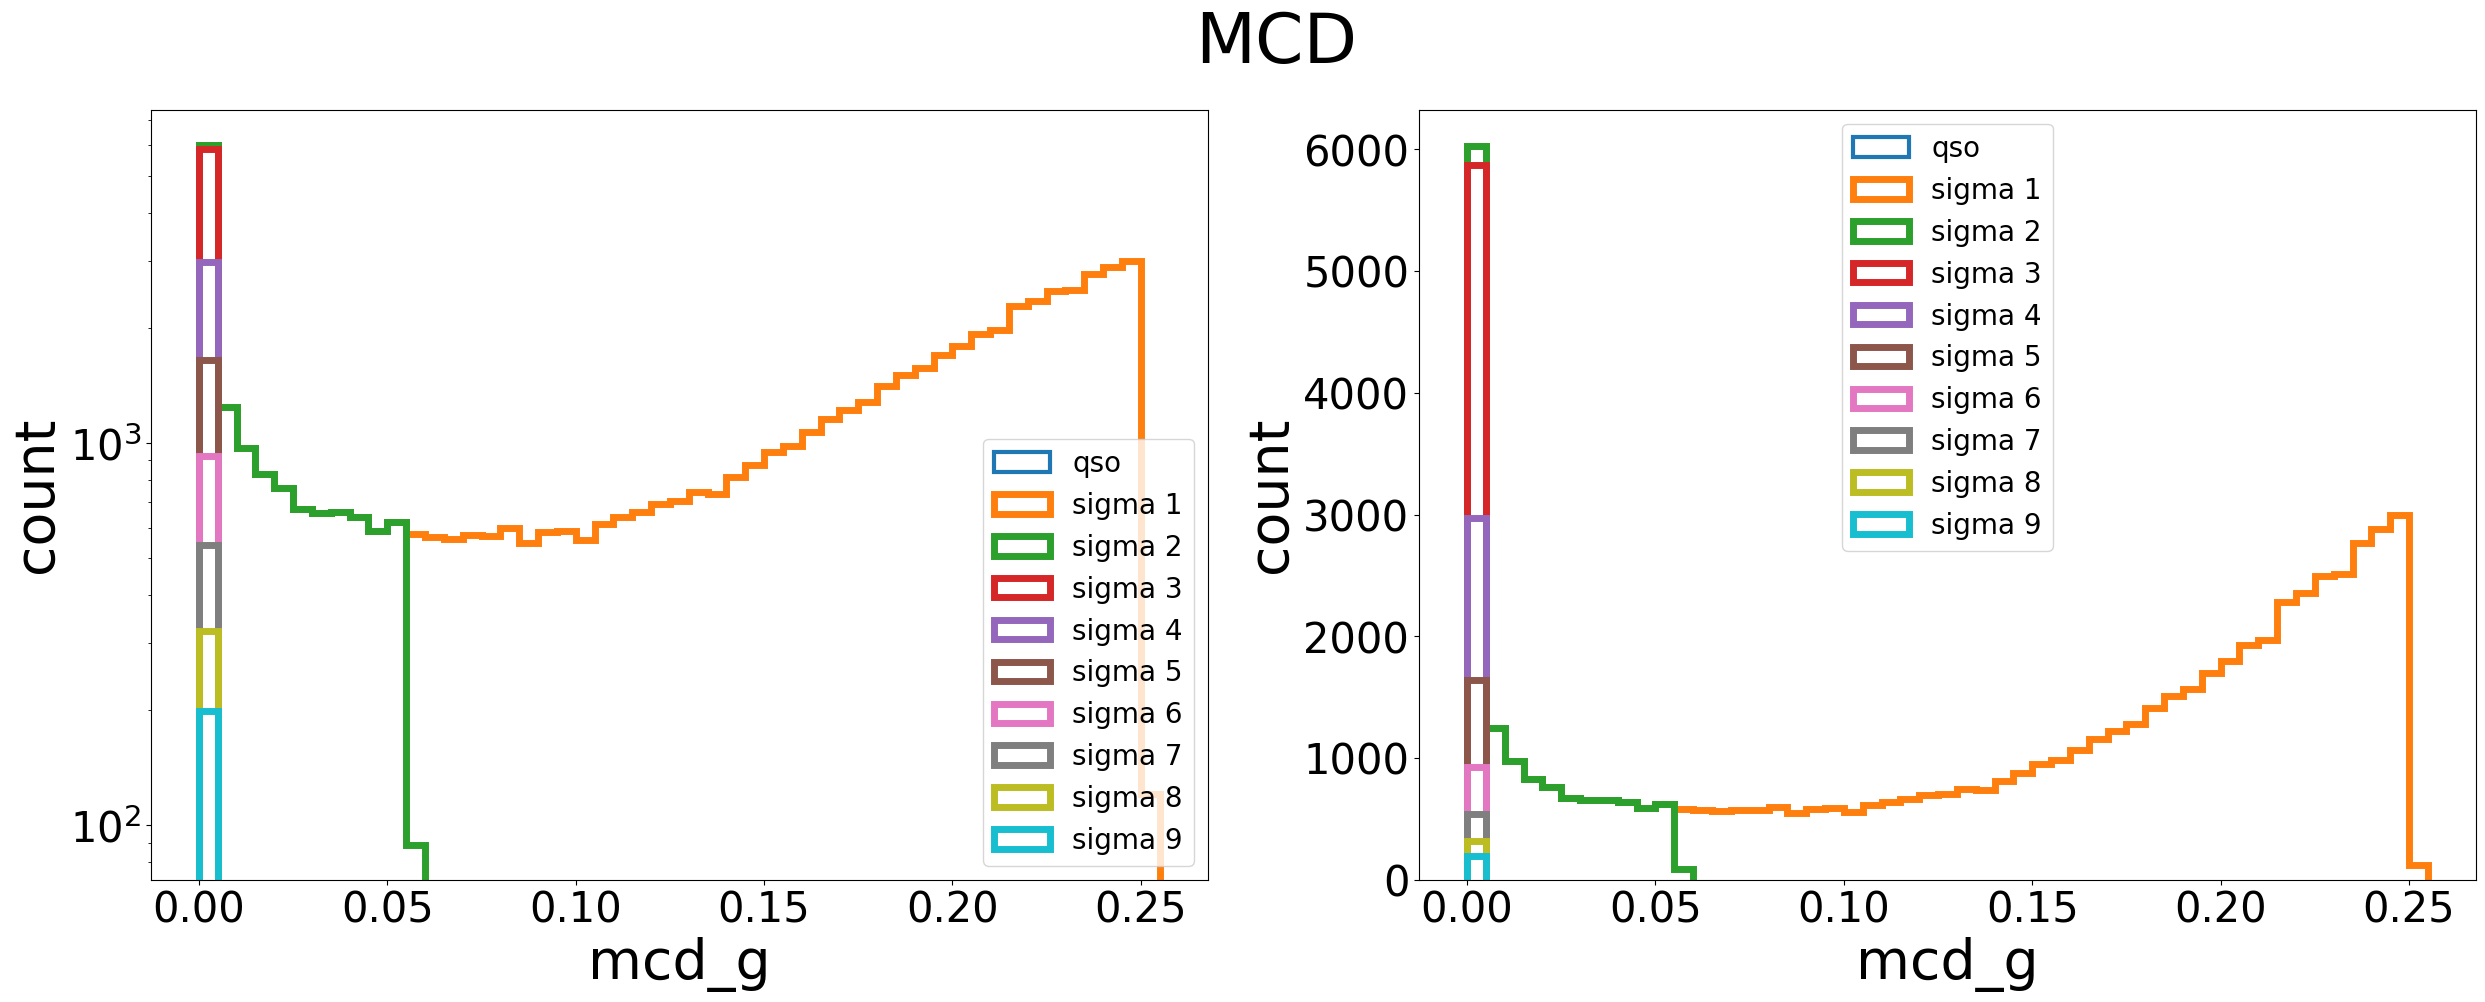

In [40]:
fig=plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.suptitle("MCD", fontsize=50)       
binwidth = 0.005

Histlog(ax1,data_mcd["mcd_g"],'mcd_g',"qso", 
        bins=np.arange(min(data_mcd_cut_mass[i]["mcd_g"]), max(data_mcd_cut_mass[i]["mcd_g"]) + binwidth, step=binwidth),           
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Histlog(ax1,data_mcd_cut_mass[i]["mcd_g"],'mcd_g',f"sigma {i}", 
            bins=np.arange(min(data_mcd_cut_mass[i]["mcd_g"]), max(data_mcd_cut_mass[i]["mcd_g"]) + binwidth, step=binwidth),                
            histtype='step', fill=config.picture["hist"]["fill"], lw=5)    
ax1.legend(prop={'size': 20})

Hist(ax2,data_mcd["mcd_g"],'mcd_g',"qso",
            bins=np.arange(min(data_mcd_cut_mass[i]["mcd_g"]), max(data_mcd_cut_mass[i]["mcd_g"]) + binwidth, step=binwidth),   
            histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Hist(ax2,data_mcd_cut_mass[i]["mcd_g"],'mcd_g',f"sigma {i}",
        bins=np.arange(min(data_mcd_cut_mass[i]["mcd_g"]), max(data_mcd_cut_mass[i]["mcd_g"]) + binwidth, step=binwidth),            
        histtype='step', fill=config.picture["hist"]["fill"], lw=5)    
ax2.legend(prop={'size': 20})

fig.set_size_inches(30,10)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

<b>fuzzy_dist</b> gauss distribution

In [47]:
fuzz_data = abs(data_mcd.loc[:,"fuzzy_dist"] - 1)

m = fuzz_data.mean()
sigma = fuzz_data.std(ddof=0)

sigma_mass = np.zeros(10)
for i in range(10):
    sigma_mass[i] = gauss_func(m+sigma*i,m,sigma)

fuzz_gauss = gauss_func(fuzz_data,m,sigma)

data_fuzz_cut_mass = []
for i in range(10):
    data_fuzz_cut_mass.append(data_mcd[fuzz_gauss < sigma_mass[i]])


<b>mcd_d</b> gauss distribution | sigma step histogram on <b>mcd_d</b>

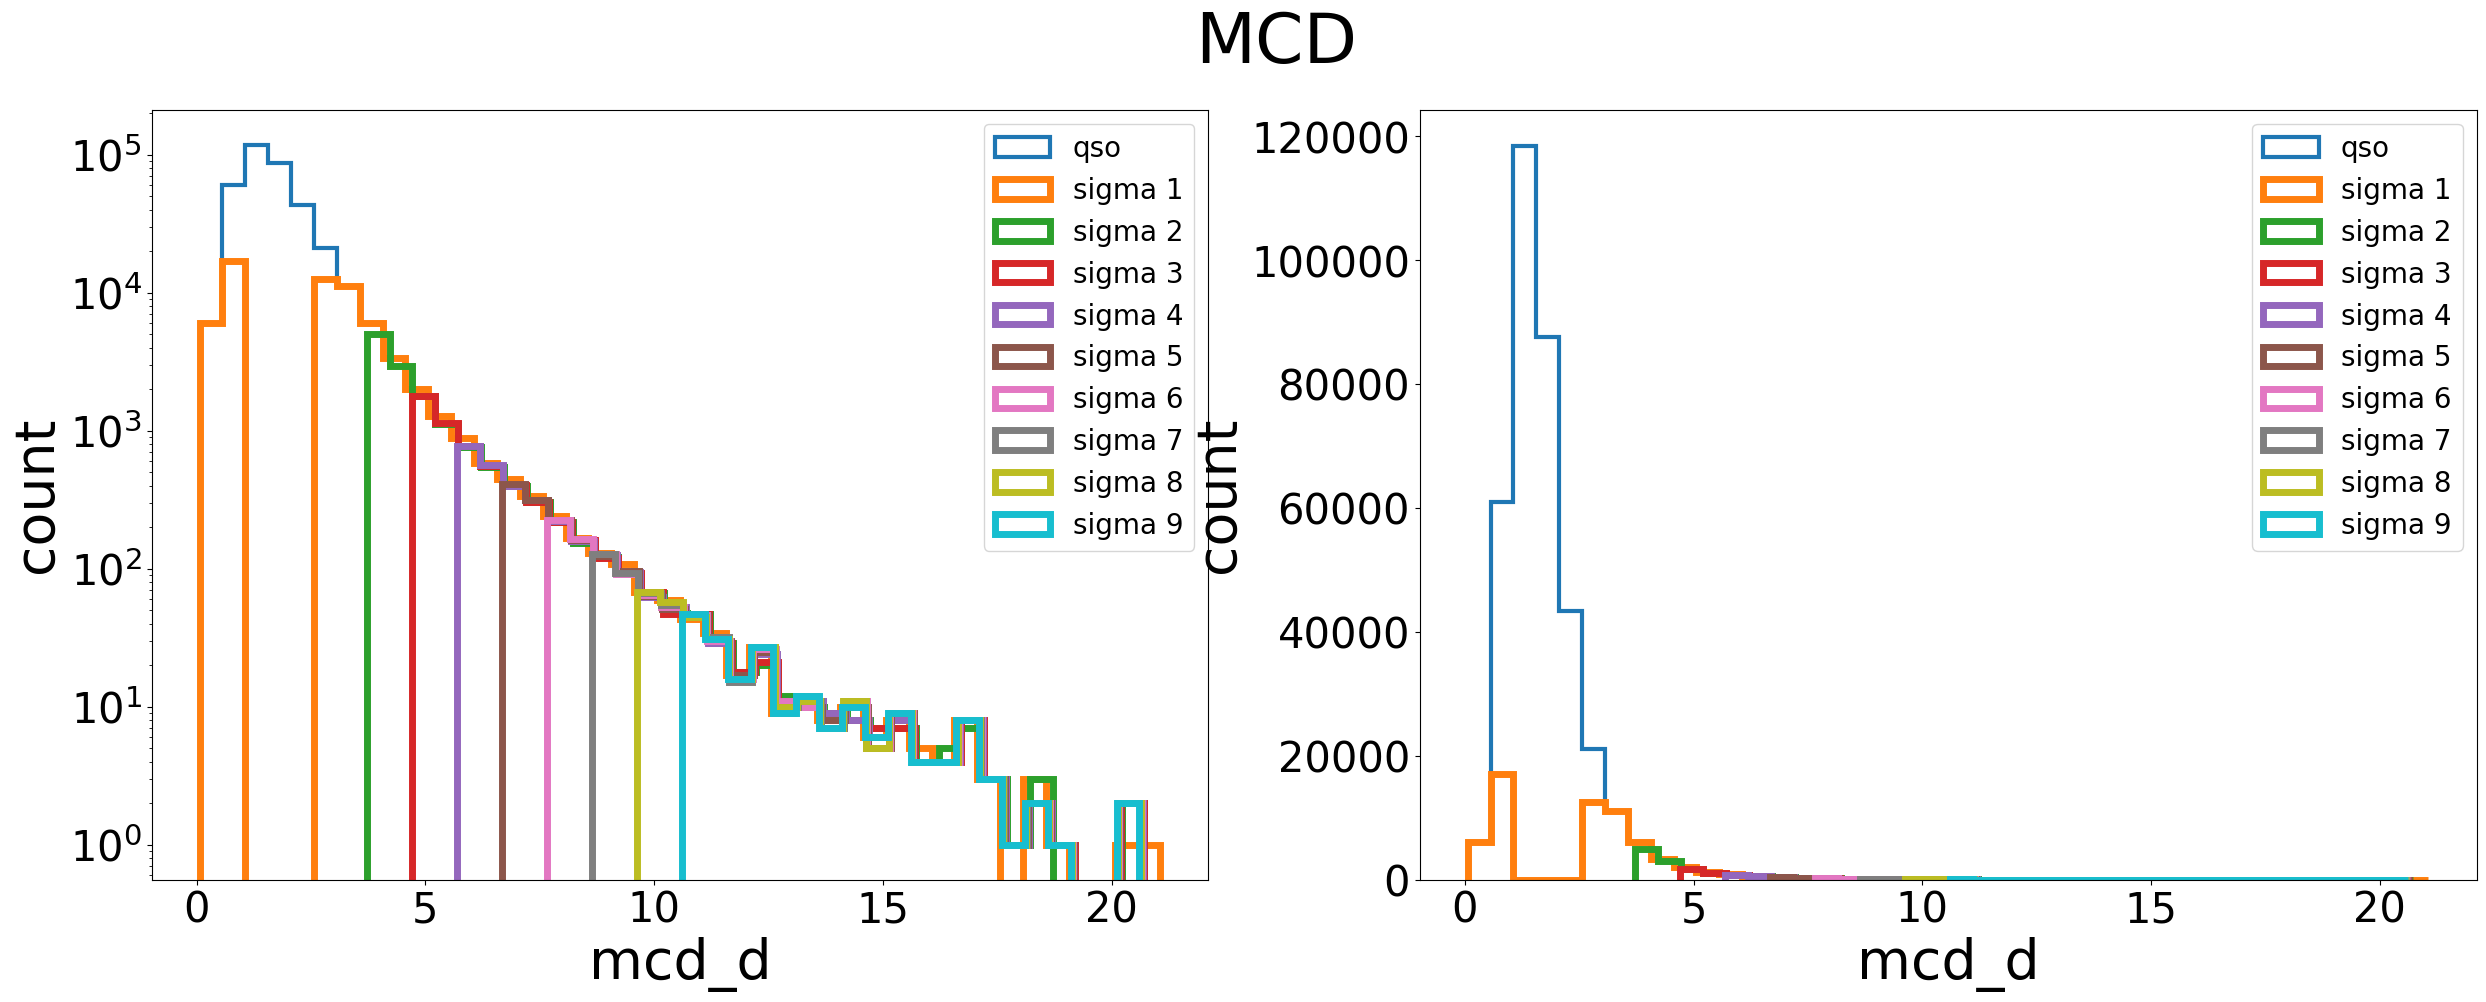

In [35]:
fig=plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.suptitle("MCD", fontsize=50)       

binwidth = 0.5

Histlog(ax1,data_mcd["mcd_d"],'mcd_d',"qso",
        bins=bins_(data_mcd["mcd_d"],binwidth),                        
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Histlog(ax1,data_mcd_cut_mass[i]["mcd_d"],'mcd_d',f"sigma {i}",
            bins=bins_(data_mcd_cut_mass[i]["mcd_d"],binwidth),            
            histtype='step', fill=config.picture["hist"]["fill"], lw=5)    
ax1.legend(prop={'size': 20})

Hist(ax2,data_mcd["mcd_d"],'mcd_d',"qso",
    bins = bins_(data_mcd["mcd_d"],binwidth),
    histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Hist(ax2,data_mcd_cut_mass[i]["mcd_d"],'mcd_d', f"sigma {i}",
        bins = bins_(data_mcd_cut_mass[i]["mcd_d"],binwidth),
        histtype='step', fill=config.picture["hist"]["fill"], lw=5)    
ax2.legend(prop={'size': 20})

fig.set_size_inches(30,10)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

<b>mcd_d</b> gauss distribution | sigma step histogram on <b>fuzzy_dist</b>

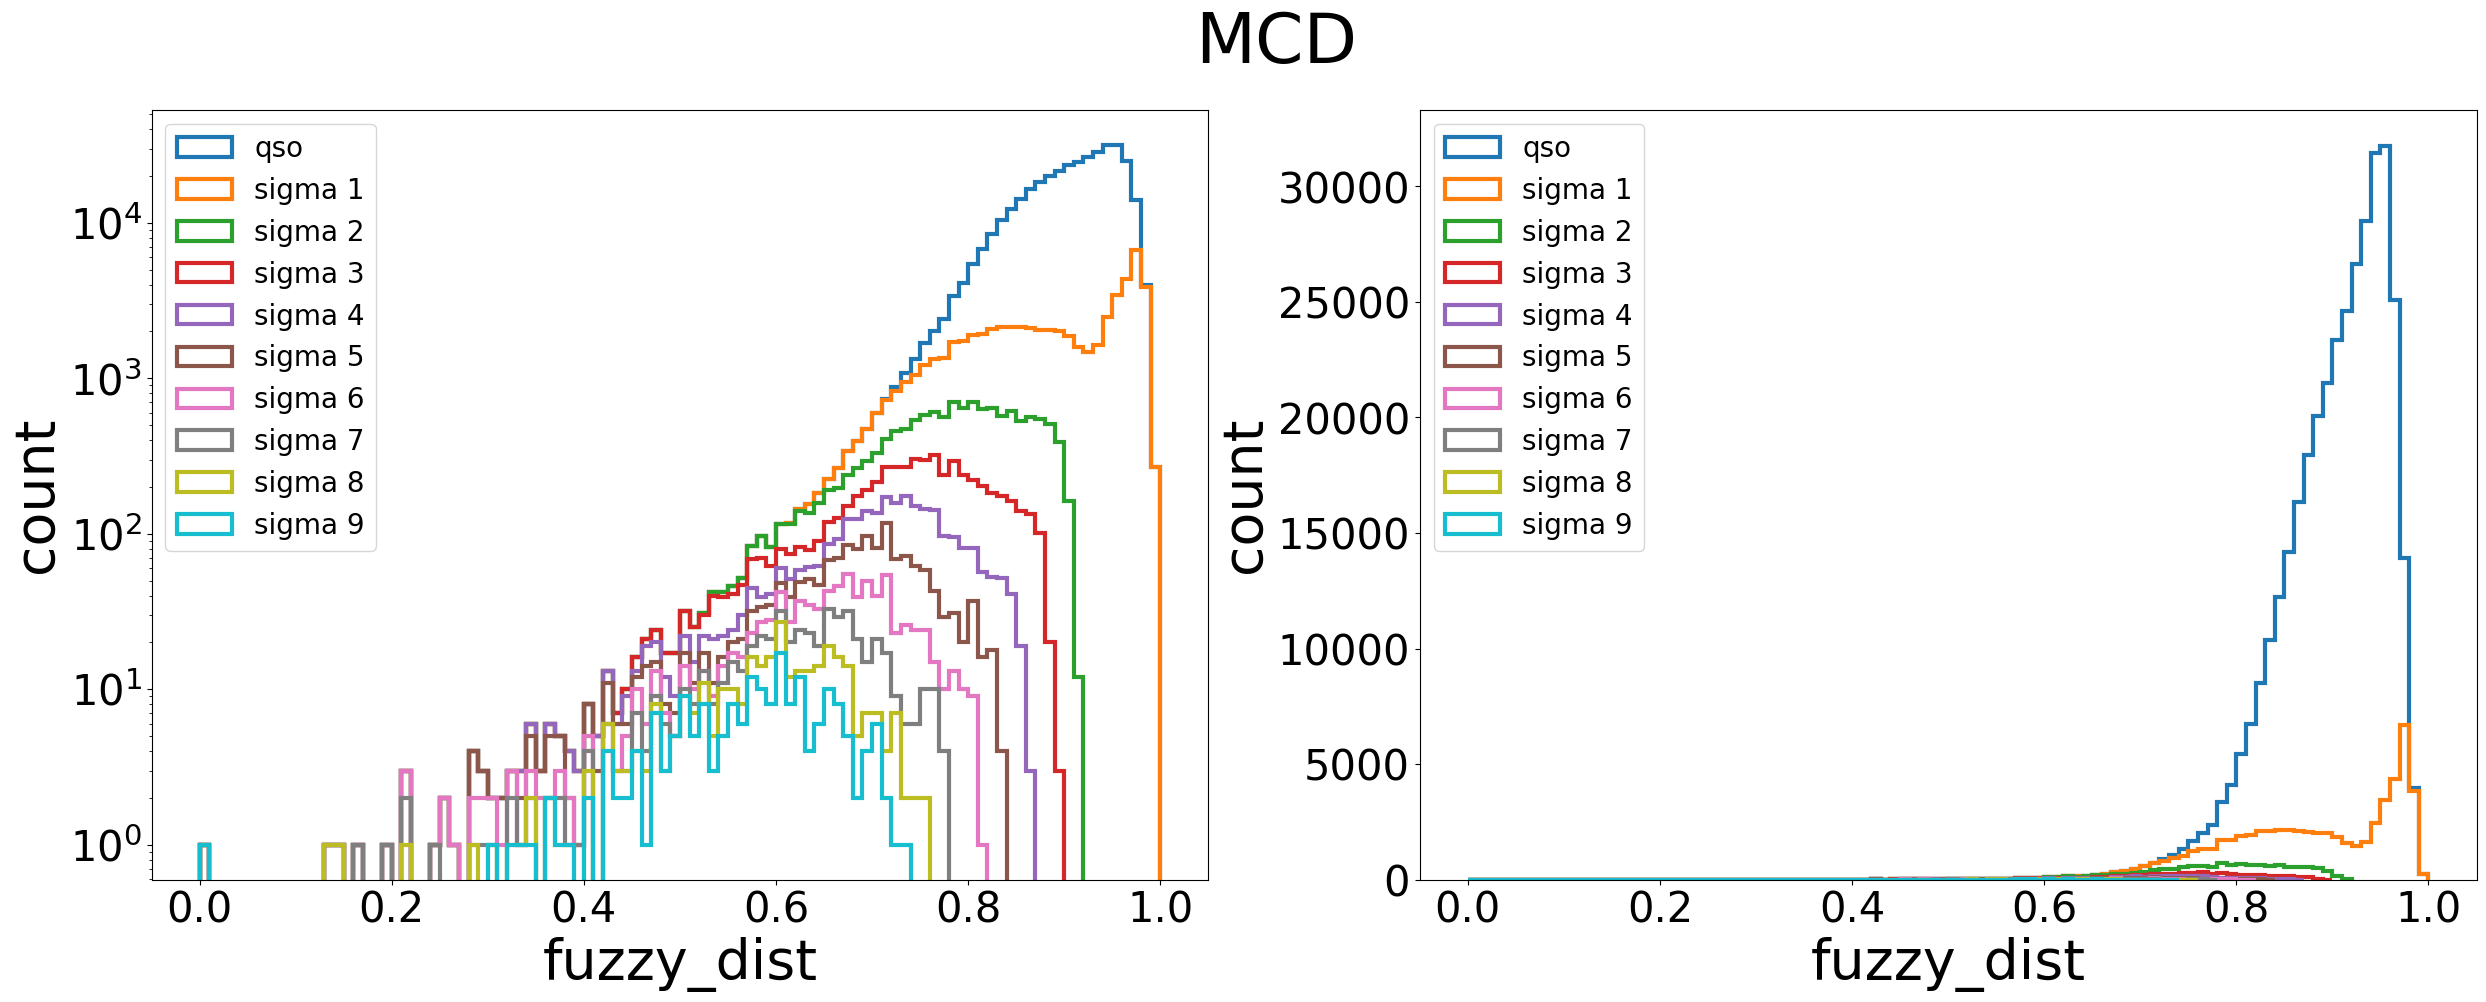

In [40]:
fig=plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.suptitle("MCD", fontsize=50)

binwidth = 0.01

Histlog(ax1,data_mcd["fuzzy_dist"],'fuzzy_dist',"qso", 
        bins = bins_(data_mcd["fuzzy_dist"],binwidth),
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Histlog(ax1,data_mcd_cut_mass[i]["fuzzy_dist"],'fuzzy_dist',f"sigma {i}", 
            bins = bins_(data_mcd_cut_mass[i]["fuzzy_dist"],binwidth),
            histtype='step', fill=config.picture["hist"]["fill"], lw=3)    
ax1.legend(prop={'size': 20})

Hist(ax2,data_mcd["fuzzy_dist"],'fuzzy_dist',"qso", 
    bins = bins_(data_mcd["fuzzy_dist"],binwidth), 
    histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Hist(ax2,data_mcd_cut_mass[i]["fuzzy_dist"],'fuzzy_dist',f"sigma {i}", 
        bins = bins_(data_mcd_cut_mass[i]["fuzzy_dist"],binwidth), 
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)    
ax2.legend(prop={'size': 20})

fig.set_size_inches(30,10)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

<b>fuzzy_dist</b> gauss distribution | sigma step histogram on <b>fuzzy_dist</b>

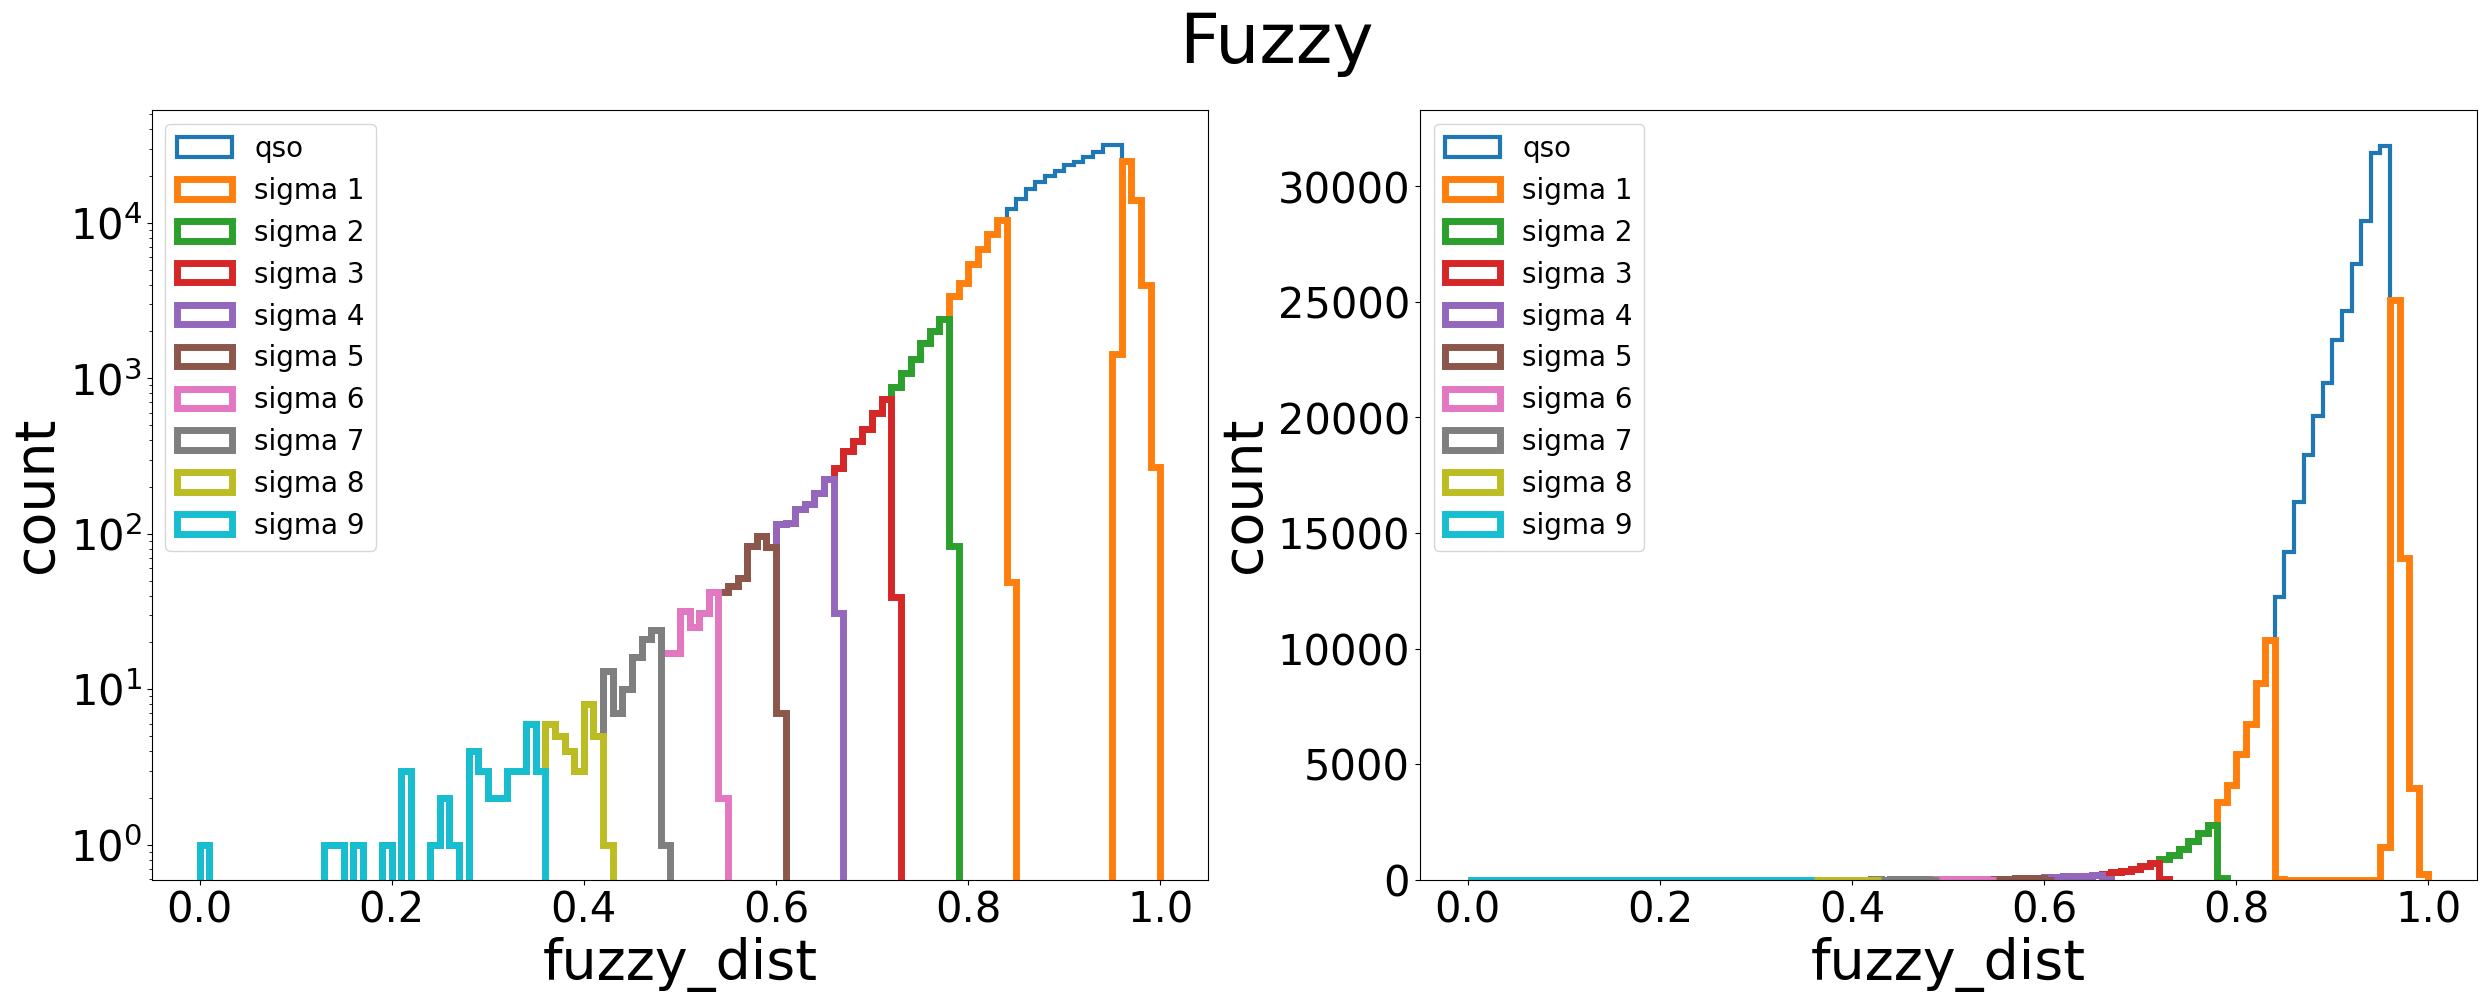

In [51]:
fig=plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.suptitle("Fuzzy", fontsize=50)       
#for i, name_class in enumerate(config.name_class):
    #if(not name_class == "star"):
binwidth = 0.01

Histlog(ax1,data_mcd["fuzzy_dist"],'fuzzy_dist',"qso", 
        bins = bins_(data_mcd["fuzzy_dist"],binwidth),
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Histlog(ax1,data_fuzz_cut_mass[i]["fuzzy_dist"],'fuzzy_dist',f"sigma {i}", 
            bins = bins_(data_fuzz_cut_mass[i]["fuzzy_dist"],binwidth),
            histtype='step', fill=config.picture["hist"]["fill"], lw=5)    
ax1.legend(prop={'size': 20})

Hist(ax2,data_mcd["fuzzy_dist"],'fuzzy_dist',"qso", 
    bins = bins_(data_mcd["fuzzy_dist"],binwidth),
    histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Hist(ax2,data_fuzz_cut_mass[i]["fuzzy_dist"],'fuzzy_dist',f"sigma {i}", 
         bins = bins_(data_fuzz_cut_mass[i]["fuzzy_dist"],binwidth),
         histtype='step', fill=config.picture["hist"]["fill"], lw=5)    
ax2.legend(prop={'size': 20})

fig.set_size_inches(30,10)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

<b>fuzzy_dist</b> gauss distribution | sigma step histogram on <b>mcd_d</b>

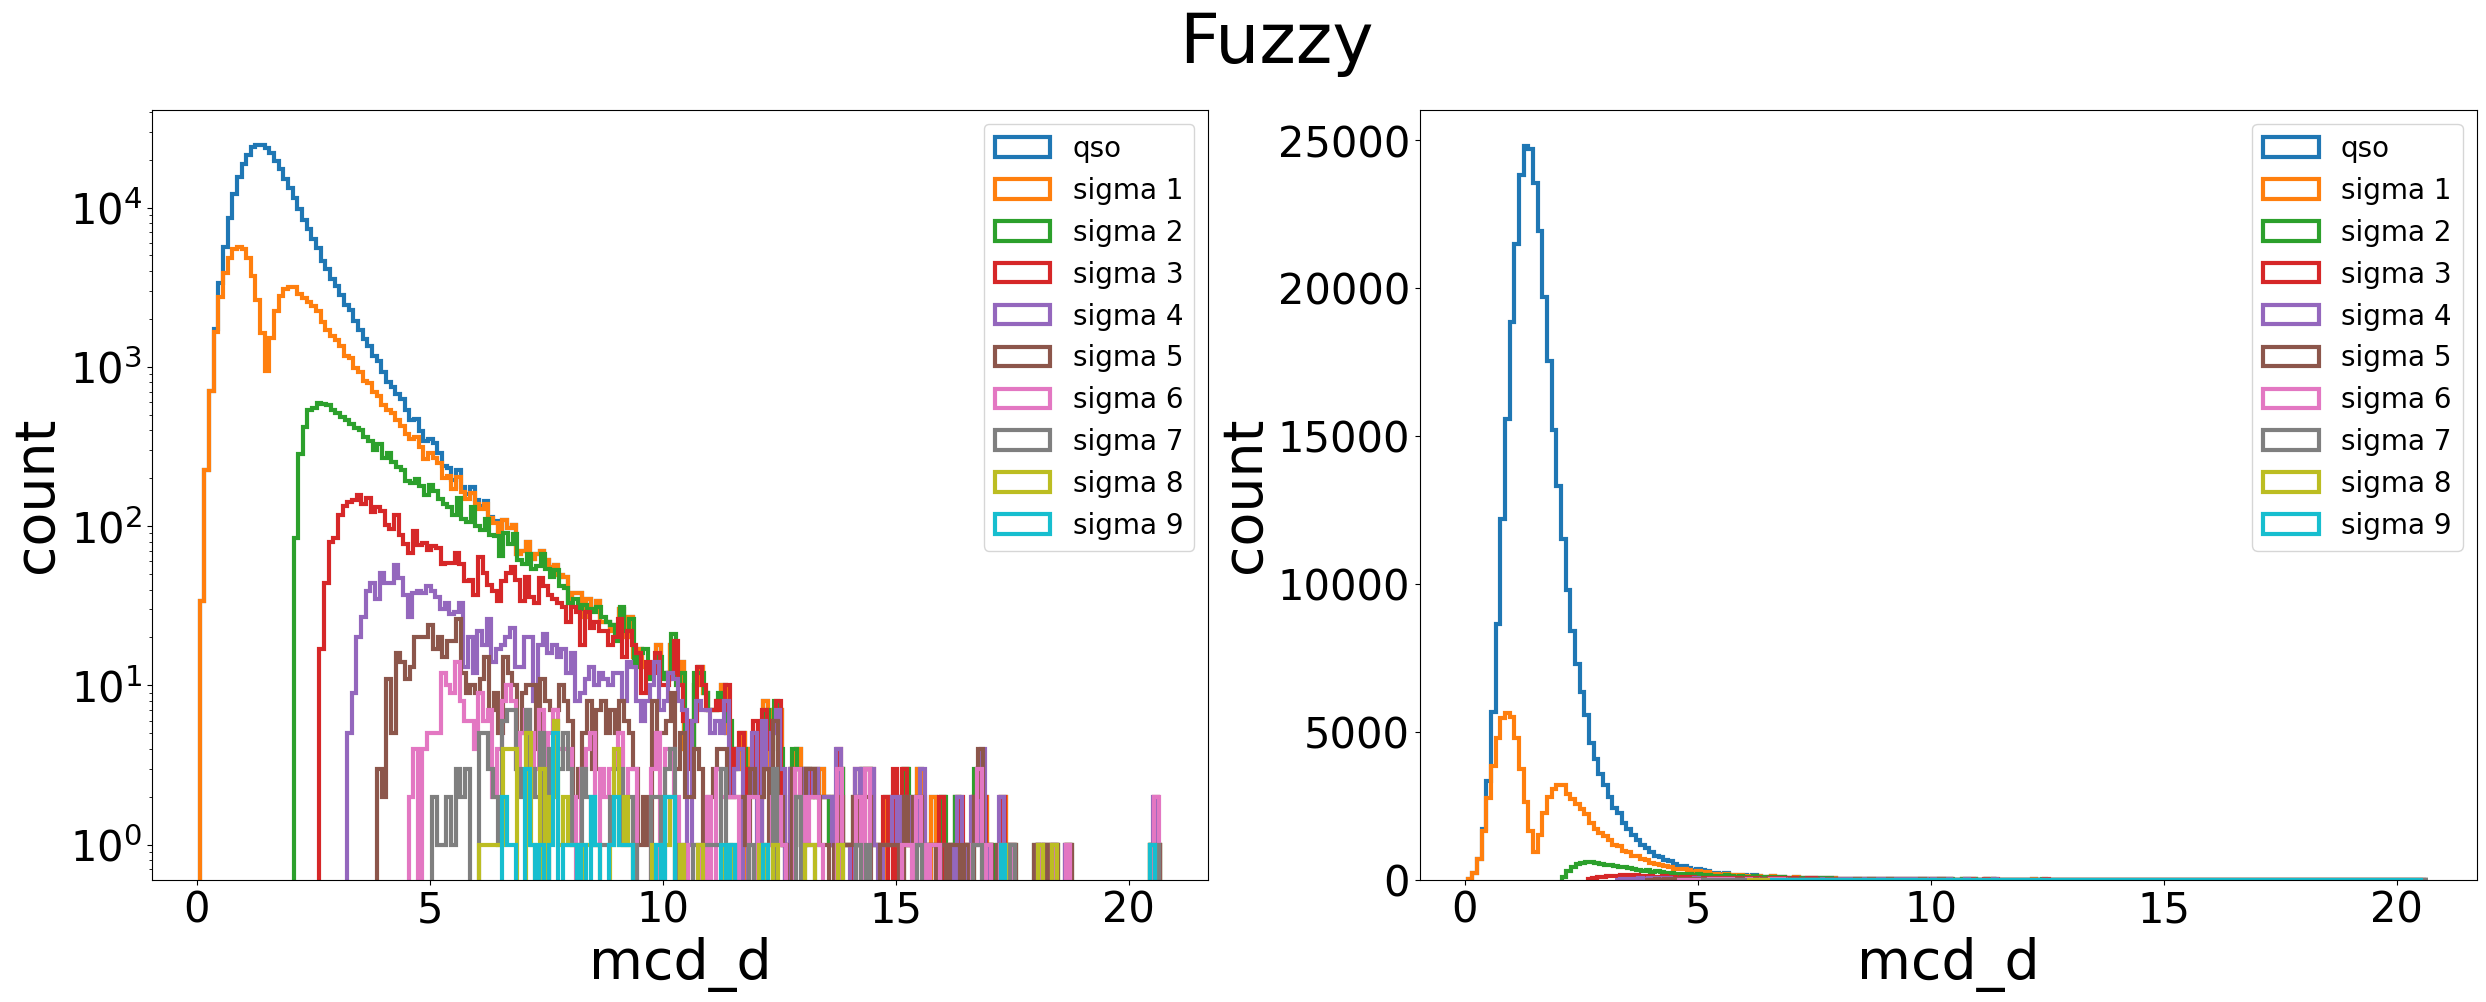

In [55]:
fig=plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.suptitle("Fuzzy", fontsize=50)       

binwidth = 0.1

Histlog(ax1,data_mcd["mcd_d"],'mcd_d',"qso", 
        bins = bins_(data_mcd["mcd_d"],binwidth),
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Histlog(ax1,data_fuzz_cut_mass[i]["mcd_d"],'mcd_d',f"sigma {i}", 
            bins = bins_(data_fuzz_cut_mass[i]["mcd_d"],binwidth),
            histtype='step', fill=config.picture["hist"]["fill"], lw=3)    
ax1.legend(prop={'size': 20})

Hist(ax2,data_mcd["mcd_d"],'mcd_d',"qso", 
     bins = bins_(data_mcd["mcd_d"],binwidth),
     histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Hist(ax2,data_fuzz_cut_mass[i]["mcd_d"],'mcd_d',f"sigma {i}", 
        bins = bins_(data_fuzz_cut_mass[i]["mcd_d"],binwidth),
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)    
ax2.legend(prop={'size': 20})

fig.set_size_inches(30,10)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

<b>fuzzy_dist</b> & <b>mcd_d</b> gauss distribution | sigma step histogram on <b>fuzzy_err</b>

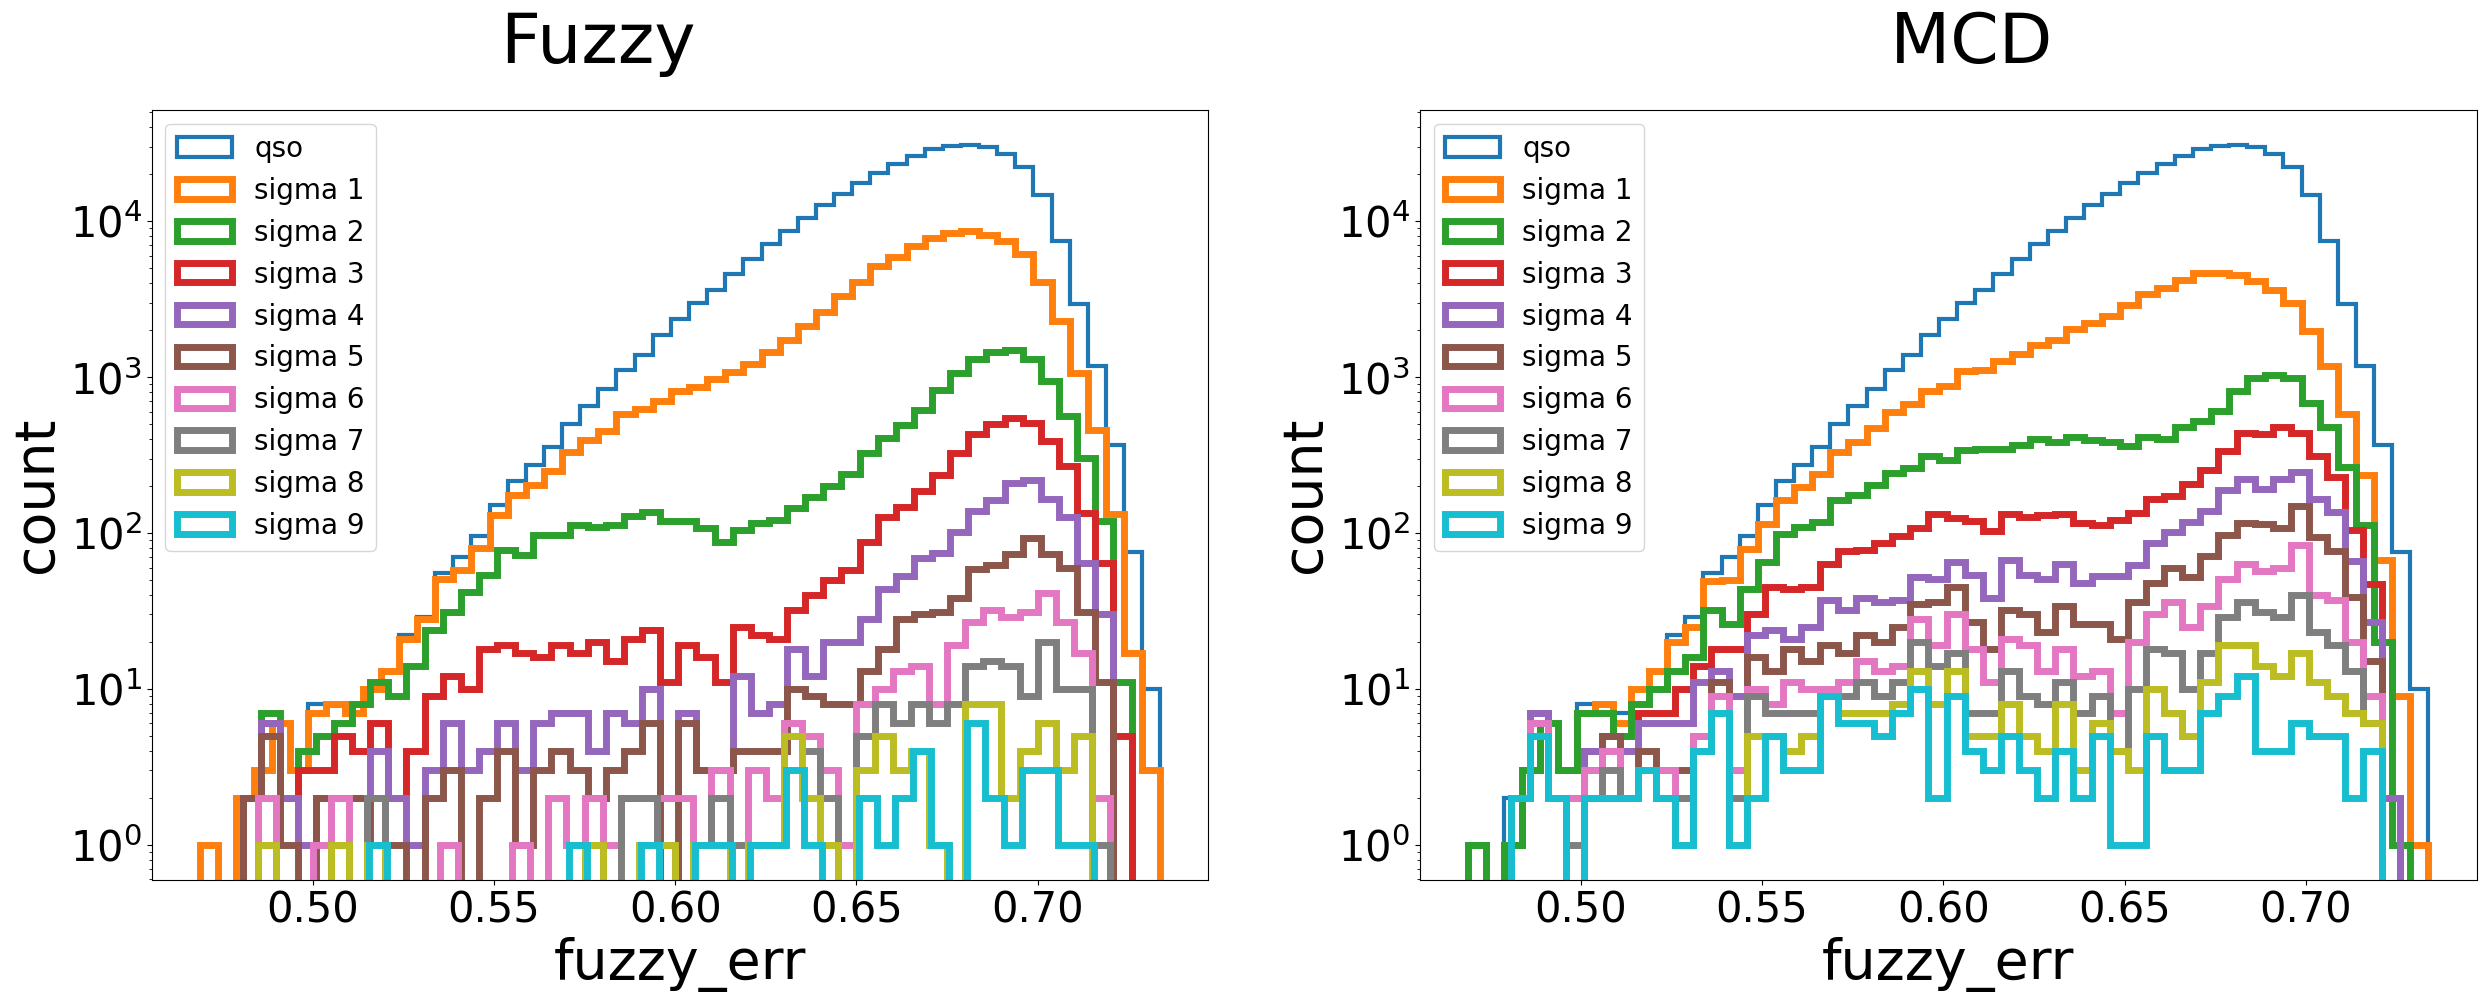

In [60]:
fig=plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.suptitle("Fuzzy                                                      MCD", fontsize=50)       
#for i, name_class in enumerate(config.name_class):
    #if(not name_class == "star"):
binwidth = 0.005

Histlog(ax1,data_mcd["fuzzy_err"],'"fuzzy_err"',"qso", 
        bins = bins_(data_mcd["fuzzy_err"],binwidth),
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Histlog(ax1,data_fuzz_cut_mass[i]["fuzzy_err"],'fuzzy_err',f"sigma {i}", 
            bins_(data_fuzz_cut_mass[i]["fuzzy_err"],binwidth),
            histtype='step', fill=config.picture["hist"]["fill"], lw=5)    
ax1.legend(prop={'size': 20})

Histlog(ax2,data_mcd["fuzzy_err"],'fuzzy_err',"qso", 
        bins = bins_(data_mcd["fuzzy_err"],binwidth),
        histtype='step', fill=config.picture["hist"]["fill"], lw=3)
for i in range(1,10,1):
    Histlog(ax2,data_mcd_cut_mass[i]["fuzzy_err"],'fuzzy_err',f"sigma {i}", 
            bins_(data_mcd_cut_mass[i]["fuzzy_err"],binwidth),
            histtype='step', fill=config.picture["hist"]["fill"], lw=5)    
ax2.legend(prop={'size': 20})

fig.set_size_inches(30,10)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

Basic statistic from sample

In [12]:
#data_statistic
if(config.statistic["metric"]):
    data.describe().transpose().to_csv(f'{config.path_stat}/{config.name_main_sample}_stat.log')

<h1>Machine Learning</h1>

In [7]:
from network import NN
from data_process import data_preparation, get_features

#network training
if(config.hyperparam["model_variable"]["work"]):
    #features from config
    #name from config
    print('Sample name: ', config.name_sample)
    print('Features: ', config.features["data"])
    #hyperparams from config
    batch_size = config.hyperparam['batch_size']
    num_ep = config.hyperparam['num_ep']
    optimizer = config.hyperparam['optimizer']
    loss = config.hyperparam['loss']
    validation_split = config.hyperparam['validation_split']
    #balanced class
    class_weights = None
    if(config.hyperparam["model_variable"]["balanced"]):
        from sklearn.utils import class_weight
        y = np.zeros(data.shape[0])
        cl = np.array(data[config.name_class_cls].values)
        #print(cl)
        for i in range(data.shape[0]):
            y[i] = np.argmax(cl[i,:])
        class_weights = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(y),y = y)))
        print("class weights",class_weights)
        del y

    print(data)

    print("Features mode list:\t",config.features["train"])
    features = get_features(config.features["train"],config)
    print("Features train values:\t",features)
    
    sample_weight = None
    if(config.hyperparam["model_variable"]["sample_weight"] in config.flags['data_preprocessing']['main_sample']['weight']['method']):
        #sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values
        sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values.T[0]
        print(sample_weight)

    try:
        data[features]
    except:
        raise Exception("data don't have initiated features, check config.features['train'] value and WARNINGs above")

    if(config.hyperparam["model_variable"]["work"]):
        NN(data[features],data[config.name_class_cls],data['z'],sample_weight,validation_split,batch_size,num_ep,optimizer,loss,class_weights,
        output_path_predict = config.path_predict,
        output_path_mod = config.path_model,
        output_path_weight = config.path_weight,
        path_save_eval = config.path_eval,
        config=config)

Sample name:  agn_sdss_diploma_sample_QSO_GAL_MCDcutderedded_weightbalanced_outlire_prob_2
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.5062172896501479, 1: 11.288913066003524, 2: 8.029990123675173, 3: 2.153590856618752, 4: 0.4819328218044707, 5: 0.7860835974071702}
                 RA        DEC         z     z_err   angDist  angDist.1   
0         35.597190   3.837424  2.425549  0.000346  0.070777   0.141093  \
1        202.978760  51.490139  1.148009  0.000996  0.260132   0.224687   
2         29.033507  -7.979351  0.900966  0.000251  0.075725   0.082019   
3         28.436473  11.498042  1.478283  0.000427  0.065327   0.185995   
4        247.647070  16.136115  0.333582  0.000051  0

<h1>Metric statistic<h1>

In [18]:
#statistic
from statistic import metric_statistic
if(config.statistic["metric"]):
    metric_statistic(config)

make metrics stat


In [ ]:
print(data)

In [42]:
from graphic import picture_confusion_matrix, picture_roc_prc, picture_hist, TSNE_pic, contam_dist_pic, multigridplot, picture_correlation_matrix


In [43]:
picture_correlation_matrix(data[get_features(config.features["train"],config)],"mags",config)

['var', 'color']


KeyError: "None of [Index(['var_FW1pm', 'var_FW2pm', 'var_FG', 'var_FBP', 'var_FRP',\n       'W1mproPM&W2mproPM', 'W1mproPM&Gmag', 'W1mproPM&BPmag',\n       'W1mproPM&RPmag', 'W2mproPM&Gmag', 'W2mproPM&BPmag', 'W2mproPM&RPmag',\n       'Gmag&BPmag', 'Gmag&RPmag', 'BPmag&RPmag'],\n      dtype='object')] are in the [columns]"

In [ ]:
TSNE_pic(data,config)

In [ ]:
contam_dist_pic(data,config)

In [26]:
multigridplot(data,get_features(config.features["train"],config),config)
















['color']
picture Multigrid plot: start
Features  qso_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  agn_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  sfg_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  sbg_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  gal_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  star_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
picture Multigrid plot: done


In [5]:
fconfig = open('config_agn_sdss.json')
config = Config(fconfig)
fconfig.close()
del fconfig

In [45]:
picture_roc_prc(config)

/home/lrikozavr/github/extragalactic_object_locate_with_ml/export/graphic.py:612: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f'{config.path_pic}/roc_prc/{config.name_sample}_class_kfold_summary_roc_prc.png')


picture ROC&PRC done


In [44]:
picture_confusion_matrix(config)

picture Confusion Matrix done


In [ ]:
picture_hist(data,config)

In [22]:
from graphic import redshift_estimation

redshift_estimation(config)